In [1]:
import os

import h2o
import joblib  # Import joblib for saving the model
import mlflow
import mlflow.xgboost
import numpy as np
import optuna
import pandas as pd
import pytorch_lightning as pl
import shap
import torch
import torch.nn as nn
import torch.nn.functional as F
import xgboost as xgb
from h2o.automl import H2OAutoML
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset


c:\Users\omsan\anaconda3\envs\eds_ml_2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.chdir(r"C:\Users\omsan\Desktop\Om\Mcgill\MMA 2023\Winter 2 2024\Enterpise ML Part 2\Group Project\Spotify-Music")


In [2]:
X_train_transformed, X_test_transformed, y_train, y_test = joblib.load(
    "../../data/processed/train_test_transformed_data.joblib"
)

## Training baseline Models using H20 AutoMl

In [9]:
# Start H2O cluster
h2o.init()

# Convert data to H2O format, ensuring target columns are properly converted
# Add target column name to the datasets before conversion
target_column = 'target'
X_train_transformed[target_column] = y_train.reset_index(drop=True)
X_test_transformed[target_column] = y_test.reset_index(drop=True)

train = h2o.H2OFrame(X_train_transformed)
test = h2o.H2OFrame(X_test_transformed)

# Ensure the target is treated as a categorical variable
train[target_column] = train[target_column].asfactor()
test[target_column] = test[target_column].asfactor()

# Run AutoML
aml = H2OAutoML(max_models=10, seed=42)
aml.train(x=train.columns[:-1], y=target_column, training_frame=train, leaderboard_frame=test)

# Get the leader model
leader = aml.leader

# Evaluate the leader model
performance = leader.model_performance(test)
print(performance)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,3 mins 51 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 10 days
H2O_cluster_name:,H2O_from_python_omsan_2rmq5i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.043 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
10:27:12.358: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%
ModelMetricsMultinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.3463799646263551
RMSE: 0.588540537793579
LogLoss: 0.9352500844094357
Null degrees of freedom: 5908
Residual degrees of freedom: 5805
Null deviance: 14242.961586886666
Residual deviance: 11052.78549755071
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actu

c:\Users\omsan\anaconda3\envs\eds_ml_2\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


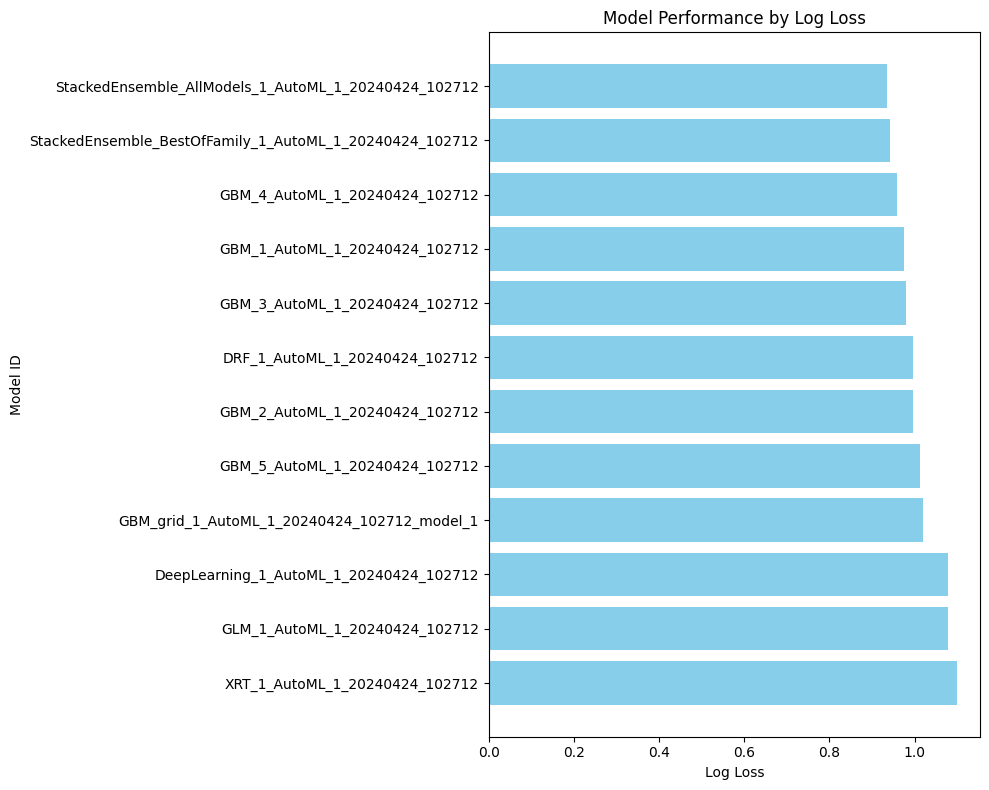

In [18]:
# Create a horizontal bar chart using the logloss
import matplotlib.pyplot as plt

# Assuming 'lb' is the leaderboard from H2OAutoML, but it needs to be defined or passed to this code block
# Convert leaderboard to a Pandas DataFrame
lb_df = aml.leaderboard.as_data_frame()  # Assuming 'aml' is the H2OAutoML object

# Sort the DataFrame by logloss in ascending order to get the best models at the top
lb_df_sorted = lb_df.sort_values(by='logloss', ascending=True)

# Plotting
plt.figure(figsize=(10, 8))  # Adjusted figure size to prevent chopping
plt.barh(lb_df_sorted['model_id'], lb_df_sorted['logloss'], color='skyblue')
plt.xlabel('Log Loss')
plt.ylabel('Model ID')
plt.title('Model Performance by Log Loss')
plt.gca().invert_yaxis()  # Invert y-axis to have the best model on top
plt.tight_layout()  # Adjust layout to make room for the elements

# Save the figure
plt.savefig(r'reports\figures\h2o_base_model_results.png', bbox_inches='tight')  # Added bbox_inches='tight' to prevent chopping
plt.show()

## Running XGBoost with Optuna

In [21]:


def objective(trial):
    with mlflow.start_run(nested=True):
        param = {
            "verbosity": 0,
            "objective": "multi:softmax",
            "num_class": len(np.unique(y_train)),
            "eval_metric": "mlogloss",
            "booster": trial.suggest_categorical(
                "booster", ["gbtree", "gblinear", "dart"]
            ),
            "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
            "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        }

        if param["booster"] == "gbtree" or param["booster"] == "dart":
            param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
            param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
            param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
            param["grow_policy"] = trial.suggest_categorical(
                "grow_policy", ["depthwise", "lossguide"]
            )

        if param["booster"] == "dart":
            param["sample_type"] = trial.suggest_categorical(
                "sample_type", ["uniform", "weighted"]
            )
            param["normalize_type"] = trial.suggest_categorical(
                "normalize_type", ["tree", "forest"]
            )
            param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
            param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

        mlflow.log_params(param)

        dtrain = xgb.DMatrix(X_train_transformed, label=y_train)
        dvalid = xgb.DMatrix(X_test_transformed, label=y_test)

        bst = xgb.train(
            param, dtrain, evals=[(dvalid, "validation")], early_stopping_rounds=10
        )
        mlflow.xgboost.log_model(bst, "model")

        preds = bst.predict(dvalid, output_margin=True)
        pred_labels = np.argmax(preds, axis=1)
        accuracy = accuracy_score(y_test, pred_labels)
        mlflow.log_metric("accuracy", accuracy)
        return accuracy


In [22]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

best_params = study.best_trial.params
print("Best trial:", study.best_trial.params)


# Train final model with adjusted labels
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train_transformed, y_train)

# Save the model
joblib.dump(final_model, "./models/xgb_optuna_model.joblib")

[I 2024-04-24 10:45:10,549] A new study created in memory with name: no-name-b099c9ad-87dc-4827-a362-bff7c5eb85b0


[0]	validation-mlogloss:1.21332
[1]	validation-mlogloss:1.16525
[2]	validation-mlogloss:1.14458
[3]	validation-mlogloss:1.13392
[4]	validation-mlogloss:1.12772
[5]	validation-mlogloss:1.12391
[6]	validation-mlogloss:1.12160
[7]	validation-mlogloss:1.11983
[8]	validation-mlogloss:1.11859
[9]	validation-mlogloss:1.11757


c:\Users\omsan\anaconda3\envs\eds_ml_2\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[I 2024-04-24 10:45:17,539] Trial 0 finished with value: 0.47419191064477917 and parameters: {'booster': 'gblinear', 'lambda': 3.616365673132892e-05, 'alpha': 0.0031463052039721793}. Best is trial 0 with value: 0.47419191064477917.


[0]	validation-mlogloss:1.38629
[1]	validation-mlogloss:1.38628
[2]	validation-mlogloss:1.38627
[3]	validation-mlogloss:1.38627
[4]	validation-mlogloss:1.38626
[5]	validation-mlogloss:1.38625
[6]	validation-mlogloss:1.38624
[7]	validation-mlogloss:1.38624
[8]	validation-mlogloss:1.38623
[9]	validation-mlogloss:1.38622


[I 2024-04-24 10:45:22,441] Trial 1 finished with value: 0.48586901336943644 and parameters: {'booster': 'dart', 'lambda': 1.0168146604135878e-05, 'alpha': 0.003700568205874134, 'max_depth': 8, 'eta': 1.966862312045866e-05, 'gamma': 5.87883991800702e-07, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.714568493992264e-06, 'skip_drop': 0.0003887984768062162}. Best is trial 1 with value: 0.48586901336943644.


[0]	validation-mlogloss:1.38629
[1]	validation-mlogloss:1.38628
[2]	validation-mlogloss:1.38627
[3]	validation-mlogloss:1.38626
[4]	validation-mlogloss:1.38625
[5]	validation-mlogloss:1.38625
[6]	validation-mlogloss:1.38624
[7]	validation-mlogloss:1.38623
[8]	validation-mlogloss:1.38622
[9]	validation-mlogloss:1.38622


[I 2024-04-24 10:45:26,179] Trial 2 finished with value: 0.4763919444914537 and parameters: {'booster': 'dart', 'lambda': 3.607253895108945e-05, 'alpha': 9.72071367962966e-07, 'max_depth': 6, 'eta': 2.4459540045971356e-05, 'gamma': 0.7081419157323988, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0010977723634004687, 'skip_drop': 0.05574972646683935}. Best is trial 1 with value: 0.48586901336943644.


[0]	validation-mlogloss:1.38629
[1]	validation-mlogloss:1.38629
[2]	validation-mlogloss:1.38629
[3]	validation-mlogloss:1.38629
[4]	validation-mlogloss:1.38629
[5]	validation-mlogloss:1.38629
[6]	validation-mlogloss:1.38629
[7]	validation-mlogloss:1.38629
[8]	validation-mlogloss:1.38629
[9]	validation-mlogloss:1.38629


[I 2024-04-24 10:45:30,397] Trial 3 finished with value: 0.37146725334235914 and parameters: {'booster': 'gbtree', 'lambda': 1.0866105233762134e-07, 'alpha': 0.0013614288653525871, 'max_depth': 8, 'eta': 4.636615333545053e-08, 'gamma': 0.29267639587611216, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.48586901336943644.


[0]	validation-mlogloss:1.38629
[1]	validation-mlogloss:1.38629
[2]	validation-mlogloss:1.38629
[3]	validation-mlogloss:1.38629
[4]	validation-mlogloss:1.38629
[5]	validation-mlogloss:1.38629
[6]	validation-mlogloss:1.38629
[7]	validation-mlogloss:1.38629
[8]	validation-mlogloss:1.38629
[9]	validation-mlogloss:1.38629


[I 2024-04-24 10:45:35,228] Trial 4 finished with value: 0.32678964291758333 and parameters: {'booster': 'gbtree', 'lambda': 3.310114060213713e-07, 'alpha': 6.245219734307639e-05, 'max_depth': 8, 'eta': 4.204369476734798e-08, 'gamma': 7.663256359199688e-08, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.48586901336943644.


[0]	validation-mlogloss:1.22372
[1]	validation-mlogloss:1.17879
[2]	validation-mlogloss:1.16061
[3]	validation-mlogloss:1.15273
[4]	validation-mlogloss:1.14830
[5]	validation-mlogloss:1.14561
[6]	validation-mlogloss:1.14401
[7]	validation-mlogloss:1.14292
[8]	validation-mlogloss:1.14209
[9]	validation-mlogloss:1.14145


[I 2024-04-24 10:45:38,821] Trial 5 finished with value: 0.46573024200372315 and parameters: {'booster': 'gblinear', 'lambda': 0.05477839278387422, 'alpha': 5.287984073948263e-07}. Best is trial 1 with value: 0.48586901336943644.


[0]	validation-mlogloss:1.38629
[1]	validation-mlogloss:1.38629
[2]	validation-mlogloss:1.38629
[3]	validation-mlogloss:1.38629
[4]	validation-mlogloss:1.38629
[5]	validation-mlogloss:1.38629
[6]	validation-mlogloss:1.38629
[7]	validation-mlogloss:1.38629
[8]	validation-mlogloss:1.38629
[9]	validation-mlogloss:1.38629


[I 2024-04-24 10:45:42,519] Trial 6 finished with value: 0.2836351328481977 and parameters: {'booster': 'dart', 'lambda': 8.452849516173491e-05, 'alpha': 8.606333773941023e-07, 'max_depth': 4, 'eta': 4.2746430031862986e-08, 'gamma': 3.7901751550701275e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 5.0284048207376526e-08, 'skip_drop': 1.8135984762211094e-08}. Best is trial 1 with value: 0.48586901336943644.


[0]	validation-mlogloss:1.38629
[1]	validation-mlogloss:1.38629
[2]	validation-mlogloss:1.38629
[3]	validation-mlogloss:1.38629
[4]	validation-mlogloss:1.38629
[5]	validation-mlogloss:1.38629
[6]	validation-mlogloss:1.38629
[7]	validation-mlogloss:1.38629
[8]	validation-mlogloss:1.38629
[9]	validation-mlogloss:1.38629


[I 2024-04-24 10:45:45,980] Trial 7 finished with value: 0.47436114401760027 and parameters: {'booster': 'gbtree', 'lambda': 0.008412689470917277, 'alpha': 0.018328429503136404, 'max_depth': 5, 'eta': 5.086395479170405e-07, 'gamma': 0.001080003978731823, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.48586901336943644.


[0]	validation-mlogloss:1.38620
[1]	validation-mlogloss:1.38610
[2]	validation-mlogloss:1.38601
[3]	validation-mlogloss:1.38591
[4]	validation-mlogloss:1.38582
[5]	validation-mlogloss:1.38572
[6]	validation-mlogloss:1.38562
[7]	validation-mlogloss:1.38553
[8]	validation-mlogloss:1.38543
[9]	validation-mlogloss:1.38534


[I 2024-04-24 10:45:49,524] Trial 8 finished with value: 0.4350990015231004 and parameters: {'booster': 'dart', 'lambda': 5.9404305019970974e-05, 'alpha': 8.24566272918049e-06, 'max_depth': 1, 'eta': 0.0004257217940192205, 'gamma': 2.5349093211707918e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.8221401894588869e-07, 'skip_drop': 8.434479142849959e-05}. Best is trial 1 with value: 0.48586901336943644.


[0]	validation-mlogloss:1.38625
[1]	validation-mlogloss:1.38620
[2]	validation-mlogloss:1.38616
[3]	validation-mlogloss:1.38611
[4]	validation-mlogloss:1.38607
[5]	validation-mlogloss:1.38602
[6]	validation-mlogloss:1.38597
[7]	validation-mlogloss:1.38593
[8]	validation-mlogloss:1.38588
[9]	validation-mlogloss:1.38584


[I 2024-04-24 10:45:54,192] Trial 9 finished with value: 0.4863767134878998 and parameters: {'booster': 'dart', 'lambda': 0.0009791657053554346, 'alpha': 8.755358130201e-06, 'max_depth': 8, 'eta': 0.0001276223334042062, 'gamma': 5.521533725220581e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.15348291548837964, 'skip_drop': 2.8474316770740983e-07}. Best is trial 9 with value: 0.4863767134878998.


[0]	validation-mlogloss:1.27829
[1]	validation-mlogloss:1.21536
[2]	validation-mlogloss:1.17117
[3]	validation-mlogloss:1.14066
[4]	validation-mlogloss:1.11475
[5]	validation-mlogloss:1.09916
[6]	validation-mlogloss:1.08647
[7]	validation-mlogloss:1.07597
[8]	validation-mlogloss:1.06620
[9]	validation-mlogloss:1.05846


[I 2024-04-24 10:45:59,738] Trial 10 finished with value: 0.5122694195295312 and parameters: {'booster': 'dart', 'lambda': 0.51068613251777, 'alpha': 0.8946052859306077, 'max_depth': 9, 'eta': 0.34481990103039006, 'gamma': 0.0014491745041074421, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.48191092438427924, 'skip_drop': 1.5010164761340387e-08}. Best is trial 10 with value: 0.5122694195295312.


[0]	validation-mlogloss:1.23643
[1]	validation-mlogloss:1.16251
[2]	validation-mlogloss:1.12120
[3]	validation-mlogloss:1.09312
[4]	validation-mlogloss:1.07274
[5]	validation-mlogloss:1.05953
[6]	validation-mlogloss:1.05205
[7]	validation-mlogloss:1.04484
[8]	validation-mlogloss:1.03706
[9]	validation-mlogloss:1.03412


[I 2024-04-24 10:46:05,174] Trial 11 finished with value: 0.520392621424945 and parameters: {'booster': 'dart', 'lambda': 0.78177332735126, 'alpha': 0.7778721931976074, 'max_depth': 9, 'eta': 0.518497977841214, 'gamma': 0.0017368704677711503, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.3168427688036721, 'skip_drop': 1.0318764861997163e-08}. Best is trial 11 with value: 0.520392621424945.


[0]	validation-mlogloss:1.20321
[1]	validation-mlogloss:1.15176
[2]	validation-mlogloss:1.11466
[3]	validation-mlogloss:1.09187
[4]	validation-mlogloss:1.09153
[5]	validation-mlogloss:1.10131
[6]	validation-mlogloss:1.09669
[7]	validation-mlogloss:1.08571
[8]	validation-mlogloss:1.07834
[9]	validation-mlogloss:1.07625


[I 2024-04-24 10:46:10,531] Trial 12 finished with value: 0.5198849213064817 and parameters: {'booster': 'dart', 'lambda': 0.36897055098983855, 'alpha': 0.9518708999265887, 'max_depth': 9, 'eta': 0.6886955087682342, 'gamma': 0.0016194875453626073, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.6942100585357787, 'skip_drop': 1.684682351691166e-08}. Best is trial 11 with value: 0.520392621424945.


[0]	validation-mlogloss:1.26642
[1]	validation-mlogloss:1.19776
[2]	validation-mlogloss:1.15144
[3]	validation-mlogloss:1.11616
[4]	validation-mlogloss:1.09220
[5]	validation-mlogloss:1.07377
[6]	validation-mlogloss:1.05966
[7]	validation-mlogloss:1.04978
[8]	validation-mlogloss:1.03880
[9]	validation-mlogloss:1.03157


[I 2024-04-24 10:46:15,752] Trial 13 finished with value: 0.5229311220172618 and parameters: {'booster': 'dart', 'lambda': 0.9557450210175233, 'alpha': 0.9993590189993768, 'max_depth': 9, 'eta': 0.3938511315621429, 'gamma': 0.004868936895098199, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.005830965492586627, 'skip_drop': 5.241860319930758e-06}. Best is trial 13 with value: 0.5229311220172618.


[0]	validation-mlogloss:1.38020
[1]	validation-mlogloss:1.37429
[2]	validation-mlogloss:1.36851
[3]	validation-mlogloss:1.36292
[4]	validation-mlogloss:1.35747
[5]	validation-mlogloss:1.35210
[6]	validation-mlogloss:1.34686
[7]	validation-mlogloss:1.34181
[8]	validation-mlogloss:1.33687
[9]	validation-mlogloss:1.33202


[I 2024-04-24 10:46:19,814] Trial 14 finished with value: 0.4870536469791843 and parameters: {'booster': 'dart', 'lambda': 0.008941150057098968, 'alpha': 0.09145373573142256, 'max_depth': 6, 'eta': 0.018901875205725737, 'gamma': 0.036567752028770946, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.002494246398752984, 'skip_drop': 5.515540864183565e-06}. Best is trial 13 with value: 0.5229311220172618.


[0]	validation-mlogloss:1.27161
[1]	validation-mlogloss:1.23151
[2]	validation-mlogloss:1.21302
[3]	validation-mlogloss:1.20356
[4]	validation-mlogloss:1.19835
[5]	validation-mlogloss:1.19530
[6]	validation-mlogloss:1.19343
[7]	validation-mlogloss:1.19222
[8]	validation-mlogloss:1.19137
[9]	validation-mlogloss:1.19077


[I 2024-04-24 10:46:23,427] Trial 15 finished with value: 0.4115755627009646 and parameters: {'booster': 'gblinear', 'lambda': 0.8682899488529765, 'alpha': 2.354980346213424e-08}. Best is trial 13 with value: 0.5229311220172618.


[0]	validation-mlogloss:1.38234
[1]	validation-mlogloss:1.37843
[2]	validation-mlogloss:1.37461
[3]	validation-mlogloss:1.37088
[4]	validation-mlogloss:1.36725
[5]	validation-mlogloss:1.36364
[6]	validation-mlogloss:1.36016
[7]	validation-mlogloss:1.35670
[8]	validation-mlogloss:1.35333
[9]	validation-mlogloss:1.35000


[I 2024-04-24 10:46:27,284] Trial 16 finished with value: 0.434591301404637 and parameters: {'booster': 'dart', 'lambda': 0.06203189450136557, 'alpha': 0.09374367035193563, 'max_depth': 2, 'eta': 0.015508755488071386, 'gamma': 0.015462448301527596, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.007748525947743177, 'skip_drop': 3.968800627008135e-06}. Best is trial 13 with value: 0.5229311220172618.


[0]	validation-mlogloss:1.37909
[1]	validation-mlogloss:1.37211
[2]	validation-mlogloss:1.36529
[3]	validation-mlogloss:1.35877
[4]	validation-mlogloss:1.35236
[5]	validation-mlogloss:1.34622
[6]	validation-mlogloss:1.34011
[7]	validation-mlogloss:1.33432
[8]	validation-mlogloss:1.32868
[9]	validation-mlogloss:1.32316


[I 2024-04-24 10:46:31,133] Trial 17 finished with value: 0.4911152479268912 and parameters: {'booster': 'dart', 'lambda': 0.0009615745613700154, 'alpha': 0.09737165554494406, 'max_depth': 7, 'eta': 0.02119331073580343, 'gamma': 0.00011943833917117411, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 2.7437713226774585e-05, 'skip_drop': 0.01748111765265703}. Best is trial 13 with value: 0.5229311220172618.


[0]	validation-mlogloss:1.18833
[1]	validation-mlogloss:1.13483
[2]	validation-mlogloss:1.11167
[3]	validation-mlogloss:1.09952
[4]	validation-mlogloss:1.09279
[5]	validation-mlogloss:1.08862
[6]	validation-mlogloss:1.08598
[7]	validation-mlogloss:1.08433
[8]	validation-mlogloss:1.08317
[9]	validation-mlogloss:1.08246


[I 2024-04-24 10:46:34,437] Trial 18 finished with value: 0.4885767473345744 and parameters: {'booster': 'gblinear', 'lambda': 1.8304660248437254e-06, 'alpha': 0.00033866061935009423}. Best is trial 13 with value: 0.5229311220172618.


[0]	validation-mlogloss:1.35502
[1]	validation-mlogloss:1.32783
[2]	validation-mlogloss:1.30471
[3]	validation-mlogloss:1.28450
[4]	validation-mlogloss:1.26642
[5]	validation-mlogloss:1.25057
[6]	validation-mlogloss:1.23626
[7]	validation-mlogloss:1.22369
[8]	validation-mlogloss:1.21227
[9]	validation-mlogloss:1.20230


[I 2024-04-24 10:46:37,836] Trial 19 finished with value: 0.4621763411744796 and parameters: {'booster': 'gbtree', 'lambda': 0.05447625233814107, 'alpha': 0.03133970877517122, 'max_depth': 3, 'eta': 0.1200079294182985, 'gamma': 0.021167774308414846, 'grow_policy': 'lossguide'}. Best is trial 13 with value: 0.5229311220172618.


[0]	validation-mlogloss:1.38571
[1]	validation-mlogloss:1.38513
[2]	validation-mlogloss:1.38455
[3]	validation-mlogloss:1.38397
[4]	validation-mlogloss:1.38340
[5]	validation-mlogloss:1.38282
[6]	validation-mlogloss:1.38224
[7]	validation-mlogloss:1.38167
[8]	validation-mlogloss:1.38109
[9]	validation-mlogloss:1.38052


[I 2024-04-24 10:46:43,188] Trial 20 finished with value: 0.4885767473345744 and parameters: {'booster': 'dart', 'lambda': 0.001919723338198519, 'alpha': 0.4807552472224563, 'max_depth': 9, 'eta': 0.0015924778603854624, 'gamma': 0.00011005192610562492, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.024759268167155093, 'skip_drop': 7.910970657116241e-07}. Best is trial 13 with value: 0.5229311220172618.


[0]	validation-mlogloss:1.18940
[1]	validation-mlogloss:1.14654
[2]	validation-mlogloss:1.11321
[3]	validation-mlogloss:1.09132
[4]	validation-mlogloss:1.10518
[5]	validation-mlogloss:1.11511
[6]	validation-mlogloss:1.11848
[7]	validation-mlogloss:1.11403
[8]	validation-mlogloss:1.10456
[9]	validation-mlogloss:1.11195


[I 2024-04-24 10:46:48,321] Trial 21 finished with value: 0.5163310204772381 and parameters: {'booster': 'dart', 'lambda': 0.24120097389843864, 'alpha': 0.8184086622187531, 'max_depth': 9, 'eta': 0.7636941766521699, 'gamma': 0.0017529360324395405, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.7747864286485853, 'skip_drop': 1.0100782835959221e-08}. Best is trial 13 with value: 0.5229311220172618.


[0]	validation-mlogloss:1.35502
[1]	validation-mlogloss:1.32790
[2]	validation-mlogloss:1.30407
[3]	validation-mlogloss:1.28295
[4]	validation-mlogloss:1.26413
[5]	validation-mlogloss:1.24712
[6]	validation-mlogloss:1.23195
[7]	validation-mlogloss:1.21720
[8]	validation-mlogloss:1.20394
[9]	validation-mlogloss:1.19207


[I 2024-04-24 10:46:52,460] Trial 22 finished with value: 0.4953460822474192 and parameters: {'booster': 'dart', 'lambda': 0.16354803769453422, 'alpha': 0.21573102263154872, 'max_depth': 7, 'eta': 0.09438504421496623, 'gamma': 0.000665667266683378, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0504312768869312, 'skip_drop': 2.29616596162029e-07}. Best is trial 13 with value: 0.5229311220172618.


[0]	validation-mlogloss:1.17910
[1]	validation-mlogloss:1.10583
[2]	validation-mlogloss:1.07346
[3]	validation-mlogloss:1.05516
[4]	validation-mlogloss:1.04014
[5]	validation-mlogloss:1.03593
[6]	validation-mlogloss:1.03482
[7]	validation-mlogloss:1.03676
[8]	validation-mlogloss:1.03073
[9]	validation-mlogloss:1.03399


[I 2024-04-24 10:46:57,455] Trial 23 finished with value: 0.5231003553900829 and parameters: {'booster': 'dart', 'lambda': 0.7874314396771137, 'alpha': 0.014568158667797454, 'max_depth': 9, 'eta': 0.8309978813664699, 'gamma': 0.006570960809186622, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.00042832107265106177, 'skip_drop': 0.00012096478559484572}. Best is trial 23 with value: 0.5231003553900829.


[0]	validation-mlogloss:1.38446
[1]	validation-mlogloss:1.38263
[2]	validation-mlogloss:1.38082
[3]	validation-mlogloss:1.37903
[4]	validation-mlogloss:1.37725
[5]	validation-mlogloss:1.37549
[6]	validation-mlogloss:1.37374
[7]	validation-mlogloss:1.37202
[8]	validation-mlogloss:1.37029
[9]	validation-mlogloss:1.36859


[I 2024-04-24 10:47:01,665] Trial 24 finished with value: 0.48756134709764765 and parameters: {'booster': 'dart', 'lambda': 1.2795777534958105e-08, 'alpha': 0.017981665468364546, 'max_depth': 7, 'eta': 0.005370549624523104, 'gamma': 0.06930595097205054, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0002275093241089181, 'skip_drop': 0.0003175086153021377}. Best is trial 23 with value: 0.5231003553900829.


[0]	validation-mlogloss:1.35734
[1]	validation-mlogloss:1.33141
[2]	validation-mlogloss:1.30851
[3]	validation-mlogloss:1.28808
[4]	validation-mlogloss:1.26957
[5]	validation-mlogloss:1.25271
[6]	validation-mlogloss:1.23741
[7]	validation-mlogloss:1.22261
[8]	validation-mlogloss:1.20923
[9]	validation-mlogloss:1.19650


[I 2024-04-24 10:47:07,111] Trial 25 finished with value: 0.5065154848536131 and parameters: {'booster': 'dart', 'lambda': 0.013034396068598785, 'alpha': 0.010345535731057587, 'max_depth': 9, 'eta': 0.08032791868649455, 'gamma': 0.008909017975465427, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.00011946642986297806, 'skip_drop': 0.0030725178444505883}. Best is trial 23 with value: 0.5231003553900829.


[0]	validation-mlogloss:1.33108
[1]	validation-mlogloss:1.28807
[2]	validation-mlogloss:1.25321
[3]	validation-mlogloss:1.22395
[4]	validation-mlogloss:1.20007
[5]	validation-mlogloss:1.17974
[6]	validation-mlogloss:1.16227
[7]	validation-mlogloss:1.14750
[8]	validation-mlogloss:1.13537
[9]	validation-mlogloss:1.12395


[I 2024-04-24 10:47:10,910] Trial 26 finished with value: 0.5024538839059063 and parameters: {'booster': 'dart', 'lambda': 0.9012229427655013, 'alpha': 0.1582593062473609, 'max_depth': 6, 'eta': 0.18341998562183018, 'gamma': 0.006203032924781947, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.000938885709736579, 'skip_drop': 0.9897158471004247}. Best is trial 23 with value: 0.5231003553900829.


[0]	validation-mlogloss:1.18245
[1]	validation-mlogloss:1.10783
[2]	validation-mlogloss:1.07618
[3]	validation-mlogloss:1.05534
[4]	validation-mlogloss:1.04786
[5]	validation-mlogloss:1.04061
[6]	validation-mlogloss:1.03627
[7]	validation-mlogloss:1.03625
[8]	validation-mlogloss:1.03414
[9]	validation-mlogloss:1.03621


[I 2024-04-24 10:47:15,420] Trial 27 finished with value: 0.5143002200033847 and parameters: {'booster': 'dart', 'lambda': 0.12790031619487327, 'alpha': 0.000708654719232567, 'max_depth': 8, 'eta': 0.8306761532800141, 'gamma': 0.00032440154783954336, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.5116666561075853e-05, 'skip_drop': 3.058000287508857e-05}. Best is trial 23 with value: 0.5231003553900829.


[0]	validation-mlogloss:1.38556
[1]	validation-mlogloss:1.38482
[2]	validation-mlogloss:1.38408
[3]	validation-mlogloss:1.38335
[4]	validation-mlogloss:1.38262
[5]	validation-mlogloss:1.38189
[6]	validation-mlogloss:1.38117
[7]	validation-mlogloss:1.38044
[8]	validation-mlogloss:1.37972
[9]	validation-mlogloss:1.37900


[I 2024-04-24 10:47:19,241] Trial 28 finished with value: 0.48739211372482655 and parameters: {'booster': 'gbtree', 'lambda': 0.01958109057713308, 'alpha': 0.06192510278311268, 'max_depth': 7, 'eta': 0.002159091797469882, 'gamma': 0.0732666343972616, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.5231003553900829.


[0]	validation-mlogloss:1.21648
[1]	validation-mlogloss:1.16989
[2]	validation-mlogloss:1.15106
[3]	validation-mlogloss:1.14196
[4]	validation-mlogloss:1.13618
[5]	validation-mlogloss:1.13268
[6]	validation-mlogloss:1.13028
[7]	validation-mlogloss:1.12866
[8]	validation-mlogloss:1.12759
[9]	validation-mlogloss:1.12688


[I 2024-04-24 10:47:22,596] Trial 29 finished with value: 0.46911490946014556 and parameters: {'booster': 'gblinear', 'lambda': 0.002109525885992932, 'alpha': 0.0035703943248775317}. Best is trial 23 with value: 0.5231003553900829.


[0]	validation-mlogloss:1.18884
[1]	validation-mlogloss:1.13484
[2]	validation-mlogloss:1.11140
[3]	validation-mlogloss:1.09961
[4]	validation-mlogloss:1.09273
[5]	validation-mlogloss:1.08861
[6]	validation-mlogloss:1.08601
[7]	validation-mlogloss:1.08429
[8]	validation-mlogloss:1.08323
[9]	validation-mlogloss:1.08236


[I 2024-04-24 10:47:26,014] Trial 30 finished with value: 0.4885767473345744 and parameters: {'booster': 'gblinear', 'lambda': 0.000217152769270714, 'alpha': 0.00017128717189783549}. Best is trial 23 with value: 0.5231003553900829.


[0]	validation-mlogloss:1.21608
[1]	validation-mlogloss:1.13968
[2]	validation-mlogloss:1.09986
[3]	validation-mlogloss:1.07489
[4]	validation-mlogloss:1.05727
[5]	validation-mlogloss:1.04049
[6]	validation-mlogloss:1.03764
[7]	validation-mlogloss:1.03036
[8]	validation-mlogloss:1.02481
[9]	validation-mlogloss:1.02113


[I 2024-04-24 10:47:31,433] Trial 31 finished with value: 0.5302081570485699 and parameters: {'booster': 'dart', 'lambda': 0.2466646631920292, 'alpha': 0.3492750183753086, 'max_depth': 9, 'eta': 0.6124390069652733, 'gamma': 0.003140387481611292, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.06331714117666479, 'skip_drop': 5.1444476436155456e-08}. Best is trial 31 with value: 0.5302081570485699.


[0]	validation-mlogloss:1.37034
[1]	validation-mlogloss:1.35546
[2]	validation-mlogloss:1.34154
[3]	validation-mlogloss:1.32854
[4]	validation-mlogloss:1.31617
[5]	validation-mlogloss:1.30451
[6]	validation-mlogloss:1.29350
[7]	validation-mlogloss:1.28289
[8]	validation-mlogloss:1.27299
[9]	validation-mlogloss:1.26352


[I 2024-04-24 10:47:36,754] Trial 32 finished with value: 0.4990692164494838 and parameters: {'booster': 'dart', 'lambda': 0.18334225620121453, 'alpha': 0.2695881515490529, 'max_depth': 9, 'eta': 0.043831235501753406, 'gamma': 0.006411589163505913, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.022022910793131626, 'skip_drop': 1.3101461098971308e-07}. Best is trial 31 with value: 0.5302081570485699.


[0]	validation-mlogloss:1.32488
[1]	validation-mlogloss:1.27818
[2]	validation-mlogloss:1.24159
[3]	validation-mlogloss:1.20944
[4]	validation-mlogloss:1.18396
[5]	validation-mlogloss:1.16132
[6]	validation-mlogloss:1.14321
[7]	validation-mlogloss:1.12768
[8]	validation-mlogloss:1.11301
[9]	validation-mlogloss:1.10163


[I 2024-04-24 10:47:41,253] Trial 33 finished with value: 0.5126078862751735 and parameters: {'booster': 'dart', 'lambda': 0.7851413768165209, 'alpha': 0.007345061744936048, 'max_depth': 8, 'eta': 0.18648715946867098, 'gamma': 0.0036954003532666565, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.08735079076346572, 'skip_drop': 1.0807730683511257e-05}. Best is trial 31 with value: 0.5302081570485699.


[0]	validation-mlogloss:1.19659
[1]	validation-mlogloss:1.11887
[2]	validation-mlogloss:1.08198
[3]	validation-mlogloss:1.05713
[4]	validation-mlogloss:1.04907
[5]	validation-mlogloss:1.04129
[6]	validation-mlogloss:1.03722
[7]	validation-mlogloss:1.03170
[8]	validation-mlogloss:1.03150
[9]	validation-mlogloss:1.02700


[I 2024-04-24 10:47:46,568] Trial 34 finished with value: 0.5168387205957015 and parameters: {'booster': 'dart', 'lambda': 0.02839740872038223, 'alpha': 0.3799953130233016, 'max_depth': 9, 'eta': 0.7198791391248845, 'gamma': 0.0002586190674073316, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.007010308834386422, 'skip_drop': 1.6019511831770573e-06}. Best is trial 31 with value: 0.5302081570485699.


[0]	validation-mlogloss:1.37125
[1]	validation-mlogloss:1.35716
[2]	validation-mlogloss:1.34405
[3]	validation-mlogloss:1.33176
[4]	validation-mlogloss:1.31991
[5]	validation-mlogloss:1.30896
[6]	validation-mlogloss:1.29833
[7]	validation-mlogloss:1.28843
[8]	validation-mlogloss:1.27897
[9]	validation-mlogloss:1.26998


[I 2024-04-24 10:47:51,062] Trial 35 finished with value: 0.4929768150279235 and parameters: {'booster': 'dart', 'lambda': 0.09101767591207455, 'alpha': 0.038370640211223994, 'max_depth': 8, 'eta': 0.042459022507107626, 'gamma': 0.16010840641293028, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.006699915446287352, 'skip_drop': 5.8410809284224355e-08}. Best is trial 31 with value: 0.5302081570485699.


[0]	validation-mlogloss:1.38404
[1]	validation-mlogloss:1.38184
[2]	validation-mlogloss:1.37966
[3]	validation-mlogloss:1.37748
[4]	validation-mlogloss:1.37532
[5]	validation-mlogloss:1.37320
[6]	validation-mlogloss:1.37108
[7]	validation-mlogloss:1.36897
[8]	validation-mlogloss:1.36686
[9]	validation-mlogloss:1.36479


[I 2024-04-24 10:47:56,451] Trial 36 finished with value: 0.4862074801150787 and parameters: {'booster': 'dart', 'lambda': 0.3143022792571134, 'alpha': 0.002844573917888709, 'max_depth': 9, 'eta': 0.0060851666406752086, 'gamma': 0.00048656756097318254, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.1572790720095217, 'skip_drop': 0.0007591893663215939}. Best is trial 31 with value: 0.5302081570485699.


[0]	validation-mlogloss:1.38629
[1]	validation-mlogloss:1.38629
[2]	validation-mlogloss:1.38629
[3]	validation-mlogloss:1.38629
[4]	validation-mlogloss:1.38629
[5]	validation-mlogloss:1.38629
[6]	validation-mlogloss:1.38628
[7]	validation-mlogloss:1.38628
[8]	validation-mlogloss:1.38628
[9]	validation-mlogloss:1.38628


[I 2024-04-24 10:48:00,388] Trial 37 finished with value: 0.48586901336943644 and parameters: {'booster': 'gbtree', 'lambda': 9.383902929959984e-06, 'alpha': 0.26088772507421454, 'max_depth': 7, 'eta': 4.148651939397896e-06, 'gamma': 2.7870769891258512e-05, 'grow_policy': 'lossguide'}. Best is trial 31 with value: 0.5302081570485699.


[0]	validation-mlogloss:1.30418
[1]	validation-mlogloss:1.24772
[2]	validation-mlogloss:1.20635
[3]	validation-mlogloss:1.17245
[4]	validation-mlogloss:1.14459
[5]	validation-mlogloss:1.12053
[6]	validation-mlogloss:1.10376
[7]	validation-mlogloss:1.08876
[8]	validation-mlogloss:1.07719
[9]	validation-mlogloss:1.06713


[I 2024-04-24 10:48:04,495] Trial 38 finished with value: 0.5236080555085463 and parameters: {'booster': 'dart', 'lambda': 0.005181761537736771, 'alpha': 0.03641314080708019, 'max_depth': 8, 'eta': 0.2518313239256498, 'gamma': 0.002988102170931734, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.00047650574082998395, 'skip_drop': 6.35654891808052e-05}. Best is trial 31 with value: 0.5302081570485699.


[0]	validation-mlogloss:1.32452
[1]	validation-mlogloss:1.27747
[2]	validation-mlogloss:1.23999
[3]	validation-mlogloss:1.20850
[4]	validation-mlogloss:1.18223
[5]	validation-mlogloss:1.16130
[6]	validation-mlogloss:1.14242
[7]	validation-mlogloss:1.12530
[8]	validation-mlogloss:1.11111
[9]	validation-mlogloss:1.09927


[I 2024-04-24 10:48:08,577] Trial 39 finished with value: 0.5109155525469623 and parameters: {'booster': 'dart', 'lambda': 0.00273227132118162, 'alpha': 0.0011056145385963754, 'max_depth': 8, 'eta': 0.18508169805477126, 'gamma': 0.1775541038071449, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0004411070723095094, 'skip_drop': 6.962134095252908e-05}. Best is trial 31 with value: 0.5302081570485699.


[0]	validation-mlogloss:1.38629
[1]	validation-mlogloss:1.38629
[2]	validation-mlogloss:1.38629
[3]	validation-mlogloss:1.38628
[4]	validation-mlogloss:1.38628
[5]	validation-mlogloss:1.38628
[6]	validation-mlogloss:1.38627
[7]	validation-mlogloss:1.38627
[8]	validation-mlogloss:1.38627
[9]	validation-mlogloss:1.38626


[I 2024-04-24 10:48:12,042] Trial 40 finished with value: 0.47605347774581147 and parameters: {'booster': 'gbtree', 'lambda': 0.00027432140224438055, 'alpha': 3.487600302841377e-05, 'max_depth': 5, 'eta': 9.736221091973649e-06, 'gamma': 0.9420489413462446, 'grow_policy': 'depthwise'}. Best is trial 31 with value: 0.5302081570485699.


[0]	validation-mlogloss:1.27922
[1]	validation-mlogloss:1.21199
[2]	validation-mlogloss:1.16387
[3]	validation-mlogloss:1.12808
[4]	validation-mlogloss:1.10157
[5]	validation-mlogloss:1.08327
[6]	validation-mlogloss:1.06829
[7]	validation-mlogloss:1.05646
[8]	validation-mlogloss:1.04447
[9]	validation-mlogloss:1.03635


[I 2024-04-24 10:48:16,210] Trial 41 finished with value: 0.5303773904213911 and parameters: {'booster': 'dart', 'lambda': 0.03943562312835868, 'alpha': 0.03236588506740903, 'max_depth': 9, 'eta': 0.33079802673706493, 'gamma': 0.003351172905927786, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 5.0484268409017925e-05, 'skip_drop': 2.0502182700753785e-05}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.29276
[1]	validation-mlogloss:1.23146
[2]	validation-mlogloss:1.18472
[3]	validation-mlogloss:1.15016
[4]	validation-mlogloss:1.12280
[5]	validation-mlogloss:1.10130
[6]	validation-mlogloss:1.08605
[7]	validation-mlogloss:1.07221
[8]	validation-mlogloss:1.06168
[9]	validation-mlogloss:1.05074


[I 2024-04-24 10:48:20,214] Trial 42 finished with value: 0.5215772550346929 and parameters: {'booster': 'dart', 'lambda': 0.033239471421500695, 'alpha': 0.007835114459850015, 'max_depth': 8, 'eta': 0.2918156718465808, 'gamma': 0.003401000465108407, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 3.94058188075174e-05, 'skip_drop': 3.692819782183353e-05}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.36864
[1]	validation-mlogloss:1.35231
[2]	validation-mlogloss:1.33724
[3]	validation-mlogloss:1.32323
[4]	validation-mlogloss:1.31004
[5]	validation-mlogloss:1.29762
[6]	validation-mlogloss:1.28595
[7]	validation-mlogloss:1.27504
[8]	validation-mlogloss:1.26471
[9]	validation-mlogloss:1.25477


[I 2024-04-24 10:48:24,174] Trial 43 finished with value: 0.4906075478084278 and parameters: {'booster': 'dart', 'lambda': 0.09875163799218534, 'alpha': 0.026095179392139782, 'max_depth': 8, 'eta': 0.04994311975920382, 'gamma': 0.024770553116846474, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.3668149192041443e-06, 'skip_drop': 1.5192827956204703e-05}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.17292
[1]	validation-mlogloss:1.10247
[2]	validation-mlogloss:1.07653
[3]	validation-mlogloss:1.06360
[4]	validation-mlogloss:1.06239
[5]	validation-mlogloss:1.05614
[6]	validation-mlogloss:1.05454
[7]	validation-mlogloss:1.05687
[8]	validation-mlogloss:1.05880
[9]	validation-mlogloss:1.05777


[I 2024-04-24 10:48:28,199] Trial 44 finished with value: 0.517515654086986 and parameters: {'booster': 'dart', 'lambda': 0.006253263372011985, 'alpha': 0.05542967959983071, 'max_depth': 9, 'eta': 0.9229647077799749, 'gamma': 0.011412989426440676, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.688925357709326e-06, 'skip_drop': 0.00027019049657398274}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.30219
[1]	validation-mlogloss:1.24448
[2]	validation-mlogloss:1.20310
[3]	validation-mlogloss:1.16850
[4]	validation-mlogloss:1.14118
[5]	validation-mlogloss:1.11891
[6]	validation-mlogloss:1.10149
[7]	validation-mlogloss:1.08702
[8]	validation-mlogloss:1.07573
[9]	validation-mlogloss:1.06577


[I 2024-04-24 10:48:32,066] Trial 45 finished with value: 0.5171771873413437 and parameters: {'booster': 'dart', 'lambda': 0.3939051641859283, 'alpha': 0.012144762674423134, 'max_depth': 8, 'eta': 0.26221606010327475, 'gamma': 1.496031502088723e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0023208315503775545, 'skip_drop': 0.0015405921748462752}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.38629
[1]	validation-mlogloss:1.38629
[2]	validation-mlogloss:1.38629
[3]	validation-mlogloss:1.38629
[4]	validation-mlogloss:1.38629
[5]	validation-mlogloss:1.38629
[6]	validation-mlogloss:1.38629
[7]	validation-mlogloss:1.38629
[8]	validation-mlogloss:1.38629
[9]	validation-mlogloss:1.38629


[I 2024-04-24 10:48:36,046] Trial 46 finished with value: 0.47199187679810456 and parameters: {'booster': 'dart', 'lambda': 0.03392128264085705, 'alpha': 0.13240207153301217, 'max_depth': 9, 'eta': 1.4171264707061063e-07, 'gamma': 3.864672254100785e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 8.203831135268177e-05, 'skip_drop': 1.6321915649065786e-06}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.26090
[1]	validation-mlogloss:1.22043
[2]	validation-mlogloss:1.20249
[3]	validation-mlogloss:1.19364
[4]	validation-mlogloss:1.18897
[5]	validation-mlogloss:1.18615
[6]	validation-mlogloss:1.18441
[7]	validation-mlogloss:1.18327
[8]	validation-mlogloss:1.18246
[9]	validation-mlogloss:1.18187


[I 2024-04-24 10:48:39,418] Trial 47 finished with value: 0.42443729903536975 and parameters: {'booster': 'gblinear', 'lambda': 0.33377802770512854, 'alpha': 0.0023026289913501284}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.38303
[1]	validation-mlogloss:1.37980
[2]	validation-mlogloss:1.37661
[3]	validation-mlogloss:1.37346
[4]	validation-mlogloss:1.37040
[5]	validation-mlogloss:1.36736
[6]	validation-mlogloss:1.36434
[7]	validation-mlogloss:1.36134
[8]	validation-mlogloss:1.35841
[9]	validation-mlogloss:1.35552


[I 2024-04-24 10:48:45,835] Trial 48 finished with value: 0.4931460484007446 and parameters: {'booster': 'dart', 'lambda': 0.007262250870329723, 'alpha': 0.4311506865404914, 'max_depth': 9, 'eta': 0.008870324571837876, 'gamma': 0.003781111508837886, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0008466446843186788, 'skip_drop': 1.8804839579088816e-05}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.38623
[1]	validation-mlogloss:1.38617
[2]	validation-mlogloss:1.38611
[3]	validation-mlogloss:1.38605
[4]	validation-mlogloss:1.38599
[5]	validation-mlogloss:1.38593
[6]	validation-mlogloss:1.38587
[7]	validation-mlogloss:1.38581
[8]	validation-mlogloss:1.38575
[9]	validation-mlogloss:1.38569


[I 2024-04-24 10:48:49,659] Trial 49 finished with value: 0.46488407513961755 and parameters: {'booster': 'dart', 'lambda': 0.05616560034864364, 'alpha': 5.838529834062072e-08, 'max_depth': 4, 'eta': 0.0002054826154798543, 'gamma': 0.06618712798704618, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 8.702030500703814e-06, 'skip_drop': 0.00014870934433294284}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.38628
[1]	validation-mlogloss:1.38626
[2]	validation-mlogloss:1.38625
[3]	validation-mlogloss:1.38623
[4]	validation-mlogloss:1.38622
[5]	validation-mlogloss:1.38620
[6]	validation-mlogloss:1.38619
[7]	validation-mlogloss:1.38617
[8]	validation-mlogloss:1.38616
[9]	validation-mlogloss:1.38614


[I 2024-04-24 10:48:53,677] Trial 50 finished with value: 0.4863767134878998 and parameters: {'booster': 'dart', 'lambda': 0.004331471492148142, 'alpha': 2.8093008459838855e-06, 'max_depth': 8, 'eta': 4.216495886452202e-05, 'gamma': 8.701558326155256e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.00032453482700366213, 'skip_drop': 0.004018357829065622}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.29449
[1]	validation-mlogloss:1.23365
[2]	validation-mlogloss:1.18769
[3]	validation-mlogloss:1.15385
[4]	validation-mlogloss:1.12710
[5]	validation-mlogloss:1.10495
[6]	validation-mlogloss:1.08894
[7]	validation-mlogloss:1.07407
[8]	validation-mlogloss:1.06372
[9]	validation-mlogloss:1.05424


[I 2024-04-24 10:48:57,803] Trial 51 finished with value: 0.524623455745473 and parameters: {'booster': 'dart', 'lambda': 0.022494048545874692, 'alpha': 0.0067277813654348, 'max_depth': 8, 'eta': 0.2855935691846329, 'gamma': 0.0029257046757450926, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 3.161128070993568e-05, 'skip_drop': 4.539657158319756e-05}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.27883
[1]	validation-mlogloss:1.21390
[2]	validation-mlogloss:1.16616
[3]	validation-mlogloss:1.13188
[4]	validation-mlogloss:1.10445
[5]	validation-mlogloss:1.08562
[6]	validation-mlogloss:1.07000
[7]	validation-mlogloss:1.05789
[8]	validation-mlogloss:1.04925
[9]	validation-mlogloss:1.04109


[I 2024-04-24 10:49:01,913] Trial 52 finished with value: 0.5185310543239127 and parameters: {'booster': 'dart', 'lambda': 0.018234600240277895, 'alpha': 0.0054695961841718654, 'max_depth': 8, 'eta': 0.34355095432449073, 'gamma': 0.0015285573249830293, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 9.355514975617264e-05, 'skip_drop': 9.636983903507117e-05}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.35564
[1]	validation-mlogloss:1.32873
[2]	validation-mlogloss:1.30466
[3]	validation-mlogloss:1.28369
[4]	validation-mlogloss:1.26473
[5]	validation-mlogloss:1.24736
[6]	validation-mlogloss:1.23167
[7]	validation-mlogloss:1.21694
[8]	validation-mlogloss:1.20346
[9]	validation-mlogloss:1.19023


[I 2024-04-24 10:49:05,949] Trial 53 finished with value: 0.5083770519546454 and parameters: {'booster': 'dart', 'lambda': 0.15166568446678966, 'alpha': 0.04255572667072882, 'max_depth': 9, 'eta': 0.08477842483140698, 'gamma': 0.0005295639756597344, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 8.015677179988363e-06, 'skip_drop': 7.3205999204065415e-06}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.28500
[1]	validation-mlogloss:1.22116
[2]	validation-mlogloss:1.17624
[3]	validation-mlogloss:1.14189
[4]	validation-mlogloss:1.11597
[5]	validation-mlogloss:1.09615
[6]	validation-mlogloss:1.08252
[7]	validation-mlogloss:1.07027
[8]	validation-mlogloss:1.06034
[9]	validation-mlogloss:1.05287


[I 2024-04-24 10:49:09,832] Trial 54 finished with value: 0.5158233203587748 and parameters: {'booster': 'dart', 'lambda': 0.0006335970067793317, 'alpha': 0.019667303241892507, 'max_depth': 7, 'eta': 0.33748135541016405, 'gamma': 0.003129866508043268, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 5.714899049935864e-07, 'skip_drop': 6.41280731082631e-05}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.37762
[1]	validation-mlogloss:1.36931
[2]	validation-mlogloss:1.36123
[3]	validation-mlogloss:1.35340
[4]	validation-mlogloss:1.34594
[5]	validation-mlogloss:1.33873
[6]	validation-mlogloss:1.33176
[7]	validation-mlogloss:1.32497
[8]	validation-mlogloss:1.31832
[9]	validation-mlogloss:1.31185


[I 2024-04-24 10:49:13,984] Trial 55 finished with value: 0.5022846505330851 and parameters: {'booster': 'dart', 'lambda': 0.6179064131538528, 'alpha': 0.1414177947081392, 'max_depth': 9, 'eta': 0.02371215307655564, 'gamma': 0.0002066646665190013, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 4.961584326540961e-05, 'skip_drop': 0.0006344655033972826}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.34419
[1]	validation-mlogloss:1.30909
[2]	validation-mlogloss:1.27919
[3]	validation-mlogloss:1.25394
[4]	validation-mlogloss:1.23163
[5]	validation-mlogloss:1.21156
[6]	validation-mlogloss:1.19291
[7]	validation-mlogloss:1.17728
[8]	validation-mlogloss:1.16244
[9]	validation-mlogloss:1.14973


[I 2024-04-24 10:49:17,892] Trial 56 finished with value: 0.5093924521915721 and parameters: {'booster': 'dart', 'lambda': 1.536504297937026e-05, 'alpha': 0.07737805435338148, 'max_depth': 8, 'eta': 0.1223510781433696, 'gamma': 0.0009889113375054618, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.00198670914342254, 'skip_drop': 7.251501178126446e-07}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.29736
[1]	validation-mlogloss:1.24603
[2]	validation-mlogloss:1.21280
[3]	validation-mlogloss:1.19264
[4]	validation-mlogloss:1.17823
[5]	validation-mlogloss:1.16830
[6]	validation-mlogloss:1.16061
[7]	validation-mlogloss:1.15406
[8]	validation-mlogloss:1.14926
[9]	validation-mlogloss:1.14536


[I 2024-04-24 10:49:21,220] Trial 57 finished with value: 0.45016077170418006 and parameters: {'booster': 'gbtree', 'lambda': 0.06451842753794988, 'alpha': 0.000469274294102455, 'max_depth': 1, 'eta': 0.46700968275181914, 'gamma': 0.014522879179962502, 'grow_policy': 'lossguide'}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.37377
[1]	validation-mlogloss:1.36187
[2]	validation-mlogloss:1.35086
[3]	validation-mlogloss:1.34017
[4]	validation-mlogloss:1.33003
[5]	validation-mlogloss:1.32018
[6]	validation-mlogloss:1.31091
[7]	validation-mlogloss:1.30199
[8]	validation-mlogloss:1.29338
[9]	validation-mlogloss:1.28533


[I 2024-04-24 10:49:25,513] Trial 58 finished with value: 0.5007615501776951 and parameters: {'booster': 'dart', 'lambda': 0.30823782717215253, 'alpha': 0.5813986891948951, 'max_depth': 9, 'eta': 0.034418220928613, 'gamma': 0.03483557827605397, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.00030808428111443737, 'skip_drop': 3.081556808755145e-06}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.21040
[1]	validation-mlogloss:1.16192
[2]	validation-mlogloss:1.14238
[3]	validation-mlogloss:1.13326
[4]	validation-mlogloss:1.12830
[5]	validation-mlogloss:1.12539
[6]	validation-mlogloss:1.12352
[7]	validation-mlogloss:1.12226
[8]	validation-mlogloss:1.12136
[9]	validation-mlogloss:1.12066


[I 2024-04-24 10:49:28,787] Trial 59 finished with value: 0.47114570993399896 and parameters: {'booster': 'gblinear', 'lambda': 0.01195980602116813, 'alpha': 0.001392277679241172}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.36289
[1]	validation-mlogloss:1.34162
[2]	validation-mlogloss:1.32252
[3]	validation-mlogloss:1.30508
[4]	validation-mlogloss:1.28917
[5]	validation-mlogloss:1.27417
[6]	validation-mlogloss:1.26054
[7]	validation-mlogloss:1.24764
[8]	validation-mlogloss:1.23574
[9]	validation-mlogloss:1.22463


[I 2024-04-24 10:49:32,884] Trial 60 finished with value: 0.49094601455407005 and parameters: {'booster': 'dart', 'lambda': 0.9991241149739986, 'alpha': 0.9399387033805388, 'max_depth': 6, 'eta': 0.0752794262697163, 'gamma': 0.0022823093671547954, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.6525036625712727e-08, 'skip_drop': 3.2991676776306894e-05}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.28756
[1]	validation-mlogloss:1.22483
[2]	validation-mlogloss:1.17798
[3]	validation-mlogloss:1.14307
[4]	validation-mlogloss:1.11713
[5]	validation-mlogloss:1.09534
[6]	validation-mlogloss:1.07936
[7]	validation-mlogloss:1.06557
[8]	validation-mlogloss:1.05389
[9]	validation-mlogloss:1.04486


[I 2024-04-24 10:49:36,972] Trial 61 finished with value: 0.5220849551531562 and parameters: {'booster': 'dart', 'lambda': 0.03200932861306736, 'alpha': 0.005546422519622271, 'max_depth': 8, 'eta': 0.31057116189933287, 'gamma': 0.006059886269543644, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 3.0385619385954704e-05, 'skip_drop': 4.437058611893289e-05}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.26638
[1]	validation-mlogloss:1.19680
[2]	validation-mlogloss:1.15011
[3]	validation-mlogloss:1.11484
[4]	validation-mlogloss:1.09262
[5]	validation-mlogloss:1.07401
[6]	validation-mlogloss:1.06062
[7]	validation-mlogloss:1.04916
[8]	validation-mlogloss:1.04034
[9]	validation-mlogloss:1.03527


[I 2024-04-24 10:49:43,423] Trial 62 finished with value: 0.5234388221357251 and parameters: {'booster': 'dart', 'lambda': 0.18443024305740952, 'alpha': 0.01569046351102426, 'max_depth': 8, 'eta': 0.392000042052988, 'gamma': 0.006815977993143383, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.00016086117355024104, 'skip_drop': 0.00017125946612955604}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.38629
[1]	validation-mlogloss:1.38629
[2]	validation-mlogloss:1.38629
[3]	validation-mlogloss:1.38629
[4]	validation-mlogloss:1.38629
[5]	validation-mlogloss:1.38629
[6]	validation-mlogloss:1.38629
[7]	validation-mlogloss:1.38629
[8]	validation-mlogloss:1.38629
[9]	validation-mlogloss:1.38629


[I 2024-04-24 10:49:48,641] Trial 63 finished with value: 0.24521915721780335 and parameters: {'booster': 'dart', 'lambda': 0.10194023229927561, 'alpha': 0.01948718166717031, 'max_depth': 9, 'eta': 1.6127093051921544e-08, 'gamma': 0.0008712696153038798, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0001598758019277233, 'skip_drop': 0.0001466343170955848}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.17576
[1]	validation-mlogloss:1.10869
[2]	validation-mlogloss:1.07935
[3]	validation-mlogloss:1.06681
[4]	validation-mlogloss:1.05724
[5]	validation-mlogloss:1.05324
[6]	validation-mlogloss:1.05072
[7]	validation-mlogloss:1.04766
[8]	validation-mlogloss:1.04496
[9]	validation-mlogloss:1.04529


[I 2024-04-24 10:49:53,444] Trial 64 finished with value: 0.5107463191741412 and parameters: {'booster': 'dart', 'lambda': 0.2678432207674209, 'alpha': 0.07178859418071604, 'max_depth': 7, 'eta': 0.9236132226373959, 'gamma': 0.01104292739695915, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0006044700277905648, 'skip_drop': 0.00021843643002661322}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.32540
[1]	validation-mlogloss:1.27801
[2]	validation-mlogloss:1.24062
[3]	validation-mlogloss:1.21015
[4]	validation-mlogloss:1.18445
[5]	validation-mlogloss:1.16207
[6]	validation-mlogloss:1.14306
[7]	validation-mlogloss:1.12593
[8]	validation-mlogloss:1.11001
[9]	validation-mlogloss:1.09792


[I 2024-04-24 10:50:00,326] Trial 65 finished with value: 0.5176848874598071 and parameters: {'booster': 'dart', 'lambda': 0.494642199316684, 'alpha': 0.014092858049233261, 'max_depth': 9, 'eta': 0.17805270067903517, 'gamma': 0.4476068430932547, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.012455798246193975, 'skip_drop': 3.766632002264657e-08}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.23935
[1]	validation-mlogloss:1.16566
[2]	validation-mlogloss:1.12015
[3]	validation-mlogloss:1.09035
[4]	validation-mlogloss:1.07226
[5]	validation-mlogloss:1.05590
[6]	validation-mlogloss:1.04691
[7]	validation-mlogloss:1.03935
[8]	validation-mlogloss:1.03446
[9]	validation-mlogloss:1.03124


[I 2024-04-24 10:50:04,863] Trial 66 finished with value: 0.5202233880521239 and parameters: {'booster': 'dart', 'lambda': 0.15551720034499925, 'alpha': 0.25187940580454443, 'max_depth': 8, 'eta': 0.511915119694174, 'gamma': 0.04222059416699167, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.668214967289279e-05, 'skip_drop': 0.0007122118934315532}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.34647
[1]	validation-mlogloss:1.31250
[2]	validation-mlogloss:1.28381
[3]	validation-mlogloss:1.25956
[4]	validation-mlogloss:1.23801
[5]	validation-mlogloss:1.21745
[6]	validation-mlogloss:1.20032
[7]	validation-mlogloss:1.18465
[8]	validation-mlogloss:1.17119
[9]	validation-mlogloss:1.15806


[I 2024-04-24 10:50:09,569] Trial 67 finished with value: 0.5056693179895075 and parameters: {'booster': 'dart', 'lambda': 0.05602369140078617, 'alpha': 0.03885288028628282, 'max_depth': 7, 'eta': 0.12166391589418142, 'gamma': 5.703645255274853e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0018795002418431613, 'skip_drop': 2.089341918854973e-05}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.38056
[1]	validation-mlogloss:1.37505
[2]	validation-mlogloss:1.36963
[3]	validation-mlogloss:1.36426
[4]	validation-mlogloss:1.35909
[5]	validation-mlogloss:1.35393
[6]	validation-mlogloss:1.34899
[7]	validation-mlogloss:1.34413
[8]	validation-mlogloss:1.33939
[9]	validation-mlogloss:1.33477


[I 2024-04-24 10:50:14,169] Trial 68 finished with value: 0.49331528177356576 and parameters: {'booster': 'dart', 'lambda': 4.0542077651181515e-07, 'alpha': 0.13371315209105103, 'max_depth': 9, 'eta': 0.015392929685448963, 'gamma': 0.006166651897033857, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0036365639226955565, 'skip_drop': 5.76563474828906e-06}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.26513
[1]	validation-mlogloss:1.22460
[2]	validation-mlogloss:1.20664
[3]	validation-mlogloss:1.19737
[4]	validation-mlogloss:1.19235
[5]	validation-mlogloss:1.18944
[6]	validation-mlogloss:1.18764
[7]	validation-mlogloss:1.18646
[8]	validation-mlogloss:1.18565
[9]	validation-mlogloss:1.18506


[I 2024-04-24 10:50:17,956] Trial 69 finished with value: 0.41732949737688274 and parameters: {'booster': 'gblinear', 'lambda': 0.5487271943840515, 'alpha': 8.92798171275498e-05}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.28159
[1]	validation-mlogloss:1.22497
[2]	validation-mlogloss:1.19113
[3]	validation-mlogloss:1.16748
[4]	validation-mlogloss:1.15140
[5]	validation-mlogloss:1.14011
[6]	validation-mlogloss:1.13080
[7]	validation-mlogloss:1.12385
[8]	validation-mlogloss:1.11838
[9]	validation-mlogloss:1.11420


[I 2024-04-24 10:50:21,628] Trial 70 finished with value: 0.4818074124217296 and parameters: {'booster': 'gbtree', 'lambda': 0.20247455220546703, 'alpha': 0.002127901306439868, 'max_depth': 2, 'eta': 0.4841254310249428, 'gamma': 1.2156885640016329e-05, 'grow_policy': 'lossguide'}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.30578
[1]	validation-mlogloss:1.24982
[2]	validation-mlogloss:1.20856
[3]	validation-mlogloss:1.17405
[4]	validation-mlogloss:1.14747
[5]	validation-mlogloss:1.12420
[6]	validation-mlogloss:1.10718
[7]	validation-mlogloss:1.09165
[8]	validation-mlogloss:1.07906
[9]	validation-mlogloss:1.06853


[I 2024-04-24 10:50:26,282] Trial 71 finished with value: 0.5195464545608394 and parameters: {'booster': 'dart', 'lambda': 0.021741303129043276, 'alpha': 0.005189696125625368, 'max_depth': 8, 'eta': 0.2466781390546159, 'gamma': 0.005802280473350273, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 5.536996036631198e-05, 'skip_drop': 5.5790264289119526e-05}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.24985
[1]	validation-mlogloss:1.17839
[2]	validation-mlogloss:1.13075
[3]	validation-mlogloss:1.10094
[4]	validation-mlogloss:1.08025
[5]	validation-mlogloss:1.06489
[6]	validation-mlogloss:1.05299
[7]	validation-mlogloss:1.04380
[8]	validation-mlogloss:1.03843
[9]	validation-mlogloss:1.03314


[I 2024-04-24 10:50:30,574] Trial 72 finished with value: 0.5241157556270096 and parameters: {'booster': 'dart', 'lambda': 0.04443212427269246, 'alpha': 0.00913919329232321, 'max_depth': 8, 'eta': 0.4596465115712275, 'gamma': 0.0195452295155891, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.4562696211730935e-05, 'skip_drop': 0.00011240817777557406}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.23055
[1]	validation-mlogloss:1.15105
[2]	validation-mlogloss:1.10706
[3]	validation-mlogloss:1.07912
[4]	validation-mlogloss:1.05958
[5]	validation-mlogloss:1.04434
[6]	validation-mlogloss:1.03567
[7]	validation-mlogloss:1.02884
[8]	validation-mlogloss:1.02355
[9]	validation-mlogloss:1.02190


[I 2024-04-24 10:50:35,134] Trial 73 finished with value: 0.5278388898290743 and parameters: {'booster': 'dart', 'lambda': 0.013628988029667626, 'alpha': 0.010254351917532177, 'max_depth': 9, 'eta': 0.5391031829473951, 'gamma': 0.016057132890016, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 8.932754240834678e-06, 'skip_drop': 0.0001216280639411461}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.22784
[1]	validation-mlogloss:1.15116
[2]	validation-mlogloss:1.11036
[3]	validation-mlogloss:1.08589
[4]	validation-mlogloss:1.06702
[5]	validation-mlogloss:1.05505
[6]	validation-mlogloss:1.04568
[7]	validation-mlogloss:1.04108
[8]	validation-mlogloss:1.03872
[9]	validation-mlogloss:1.03652


[I 2024-04-24 10:50:39,648] Trial 74 finished with value: 0.5168387205957015 and parameters: {'booster': 'dart', 'lambda': 0.003115238816625333, 'alpha': 0.011166029258028454, 'max_depth': 8, 'eta': 0.5629529916188823, 'gamma': 0.02005570040070551, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 5.5246529993174655e-06, 'skip_drop': 0.00040328269044697}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.33854
[1]	validation-mlogloss:1.29913
[2]	validation-mlogloss:1.26685
[3]	validation-mlogloss:1.23934
[4]	validation-mlogloss:1.21540
[5]	validation-mlogloss:1.19461
[6]	validation-mlogloss:1.17512
[7]	validation-mlogloss:1.15804
[8]	validation-mlogloss:1.14368
[9]	validation-mlogloss:1.12993


[I 2024-04-24 10:50:44,407] Trial 75 finished with value: 0.5154848536131325 and parameters: {'booster': 'dart', 'lambda': 0.0014959846684172472, 'alpha': 0.0011579939117880933, 'max_depth': 9, 'eta': 0.13565337528271382, 'gamma': 0.1407582338717099, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.998284096125403e-05, 'skip_drop': 0.00012440756893061526}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.17182
[1]	validation-mlogloss:1.10203
[2]	validation-mlogloss:1.07889
[3]	validation-mlogloss:1.06553
[4]	validation-mlogloss:1.05640
[5]	validation-mlogloss:1.05535
[6]	validation-mlogloss:1.05569
[7]	validation-mlogloss:1.05675
[8]	validation-mlogloss:1.06267
[9]	validation-mlogloss:1.05745


[I 2024-04-24 10:50:48,847] Trial 76 finished with value: 0.5088847520731088 and parameters: {'booster': 'dart', 'lambda': 0.010820934171562626, 'alpha': 0.02823257850465471, 'max_depth': 8, 'eta': 0.9268773928345815, 'gamma': 0.002111871018895027, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.6227905142347927e-06, 'skip_drop': 0.0020046740656100032}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.36431
[1]	validation-mlogloss:1.34431
[2]	validation-mlogloss:1.32586
[3]	validation-mlogloss:1.30884
[4]	validation-mlogloss:1.29303
[5]	validation-mlogloss:1.27879
[6]	validation-mlogloss:1.26541
[7]	validation-mlogloss:1.25291
[8]	validation-mlogloss:1.24123
[9]	validation-mlogloss:1.23052


[I 2024-04-24 10:50:53,355] Trial 77 finished with value: 0.5033000507700118 and parameters: {'booster': 'dart', 'lambda': 0.004238164842267858, 'alpha': 0.003477614005172817, 'max_depth': 9, 'eta': 0.060325401926508024, 'gamma': 0.011324516902968148, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.00011946380803599516, 'skip_drop': 0.0004877083347077182}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.38605
[1]	validation-mlogloss:1.38581
[2]	validation-mlogloss:1.38557
[3]	validation-mlogloss:1.38533
[4]	validation-mlogloss:1.38509
[5]	validation-mlogloss:1.38485
[6]	validation-mlogloss:1.38461
[7]	validation-mlogloss:1.38437
[8]	validation-mlogloss:1.38412
[9]	validation-mlogloss:1.38388


[I 2024-04-24 10:50:57,736] Trial 78 finished with value: 0.48586901336943644 and parameters: {'booster': 'dart', 'lambda': 0.04039626561981433, 'alpha': 0.007593488555952024, 'max_depth': 7, 'eta': 0.000706560109431044, 'gamma': 0.029071765086741207, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.0383485268918118e-05, 'skip_drop': 0.043728854576191516}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.32587
[1]	validation-mlogloss:1.27943
[2]	validation-mlogloss:1.24267
[3]	validation-mlogloss:1.21167
[4]	validation-mlogloss:1.18612
[5]	validation-mlogloss:1.16460
[6]	validation-mlogloss:1.14608
[7]	validation-mlogloss:1.12963
[8]	validation-mlogloss:1.11512
[9]	validation-mlogloss:1.10322


[I 2024-04-24 10:51:02,236] Trial 79 finished with value: 0.5124386529023524 and parameters: {'booster': 'dart', 'lambda': 0.0986514385630631, 'alpha': 0.022718697440299203, 'max_depth': 8, 'eta': 0.18000046355564533, 'gamma': 0.05452166136351508, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 6.264416613396752e-07, 'skip_drop': 0.00022291624004078795}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.38629
[1]	validation-mlogloss:1.38629
[2]	validation-mlogloss:1.38629
[3]	validation-mlogloss:1.38629
[4]	validation-mlogloss:1.38629
[5]	validation-mlogloss:1.38629
[6]	validation-mlogloss:1.38629
[7]	validation-mlogloss:1.38629
[8]	validation-mlogloss:1.38629
[9]	validation-mlogloss:1.38629


[I 2024-04-24 10:51:06,838] Trial 80 finished with value: 0.4860382467422576 and parameters: {'booster': 'dart', 'lambda': 0.019367767949687312, 'alpha': 0.012528568968813868, 'max_depth': 9, 'eta': 1.4121083834931665e-06, 'gamma': 0.10050696409971094, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0002124375453382496, 'skip_drop': 0.009403967179845547}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.22925
[1]	validation-mlogloss:1.15119
[2]	validation-mlogloss:1.10972
[3]	validation-mlogloss:1.08131
[4]	validation-mlogloss:1.06022
[5]	validation-mlogloss:1.04574
[6]	validation-mlogloss:1.03568
[7]	validation-mlogloss:1.02821
[8]	validation-mlogloss:1.02459
[9]	validation-mlogloss:1.02112


[I 2024-04-24 10:51:12,618] Trial 81 finished with value: 0.5298696903029277 and parameters: {'booster': 'dart', 'lambda': 0.1933539535880471, 'alpha': 0.05313273638918631, 'max_depth': 9, 'eta': 0.5438307963352309, 'gamma': 0.0043555624596559135, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 6.176929384502386e-05, 'skip_drop': 1.3171901371179905e-05}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.16384
[1]	validation-mlogloss:1.10065
[2]	validation-mlogloss:1.07775
[3]	validation-mlogloss:1.06729
[4]	validation-mlogloss:1.06640
[5]	validation-mlogloss:1.06682
[6]	validation-mlogloss:1.06897
[7]	validation-mlogloss:1.07411
[8]	validation-mlogloss:1.07569
[9]	validation-mlogloss:1.08104


[I 2024-04-24 10:51:17,753] Trial 82 finished with value: 0.5122694195295312 and parameters: {'booster': 'dart', 'lambda': 0.061777346869717954, 'alpha': 0.06571532166399449, 'max_depth': 9, 'eta': 0.9989296645994381, 'gamma': 0.0013142004042442674, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 6.174446105983247e-05, 'skip_drop': 1.40268707476644e-05}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.26434
[1]	validation-mlogloss:1.19506
[2]	validation-mlogloss:1.14798
[3]	validation-mlogloss:1.11399
[4]	validation-mlogloss:1.08891
[5]	validation-mlogloss:1.07229
[6]	validation-mlogloss:1.05763
[7]	validation-mlogloss:1.04551
[8]	validation-mlogloss:1.03665
[9]	validation-mlogloss:1.02869


[I 2024-04-24 10:51:23,507] Trial 83 finished with value: 0.5273311897106109 and parameters: {'booster': 'dart', 'lambda': 0.21066852030522745, 'alpha': 0.045685694113151216, 'max_depth': 9, 'eta': 0.3907907418957064, 'gamma': 0.016282891801430967, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.8422360108054734e-05, 'skip_drop': 8.885616757184926e-05}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.26785
[1]	validation-mlogloss:1.19892
[2]	validation-mlogloss:1.15078
[3]	validation-mlogloss:1.11729
[4]	validation-mlogloss:1.09270
[5]	validation-mlogloss:1.07418
[6]	validation-mlogloss:1.06151
[7]	validation-mlogloss:1.04827
[8]	validation-mlogloss:1.03770
[9]	validation-mlogloss:1.02968


[I 2024-04-24 10:51:29,267] Trial 84 finished with value: 0.5236080555085463 and parameters: {'booster': 'dart', 'lambda': 0.015901579326603178, 'alpha': 0.04528082378793405, 'max_depth': 9, 'eta': 0.3747454622405919, 'gamma': 0.015474899652114113, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 4.269727289887298e-06, 'skip_drop': 2.779691449263678e-05}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.35170
[1]	validation-mlogloss:1.32149
[2]	validation-mlogloss:1.29536
[3]	validation-mlogloss:1.27295
[4]	validation-mlogloss:1.25283
[5]	validation-mlogloss:1.23434
[6]	validation-mlogloss:1.21725
[7]	validation-mlogloss:1.20205
[8]	validation-mlogloss:1.18742
[9]	validation-mlogloss:1.17390


[I 2024-04-24 10:51:35,164] Trial 85 finished with value: 0.5078693518361821 and parameters: {'booster': 'dart', 'lambda': 0.006728658670085646, 'alpha': 0.10940054081493733, 'max_depth': 9, 'eta': 0.09585102276798009, 'gamma': 0.002912709168812629, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 5.196896354991368e-06, 'skip_drop': 2.6372097354991135e-05}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.31348
[1]	validation-mlogloss:1.25983
[2]	validation-mlogloss:1.21998
[3]	validation-mlogloss:1.18515
[4]	validation-mlogloss:1.15788
[5]	validation-mlogloss:1.13510
[6]	validation-mlogloss:1.11493
[7]	validation-mlogloss:1.09917
[8]	validation-mlogloss:1.08537
[9]	validation-mlogloss:1.07400


[I 2024-04-24 10:51:43,615] Trial 86 finished with value: 0.5268234895921475 and parameters: {'booster': 'dart', 'lambda': 0.014064944332834641, 'alpha': 0.04353900620402544, 'max_depth': 9, 'eta': 0.21342077068822296, 'gamma': 0.01844119892810749, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.1886411310977892e-05, 'skip_drop': 7.364346188430764e-05}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.33354
[1]	validation-mlogloss:1.29253
[2]	validation-mlogloss:1.25931
[3]	validation-mlogloss:1.23096
[4]	validation-mlogloss:1.20870
[5]	validation-mlogloss:1.18872
[6]	validation-mlogloss:1.17215
[7]	validation-mlogloss:1.15808
[8]	validation-mlogloss:1.14626
[9]	validation-mlogloss:1.13560


[I 2024-04-24 10:51:48,033] Trial 87 finished with value: 0.4944999153833136 and parameters: {'booster': 'dart', 'lambda': 0.042866192742613815, 'alpha': 0.1672315709746112, 'max_depth': 5, 'eta': 0.18221761387958316, 'gamma': 0.28116344998359283, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.520129529124402e-05, 'skip_drop': 9.275863287546753e-06}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.37654
[1]	validation-mlogloss:1.36723
[2]	validation-mlogloss:1.35830
[3]	validation-mlogloss:1.34978
[4]	validation-mlogloss:1.34160
[5]	validation-mlogloss:1.33372
[6]	validation-mlogloss:1.32619
[7]	validation-mlogloss:1.31887
[8]	validation-mlogloss:1.31200
[9]	validation-mlogloss:1.30541


[I 2024-04-24 10:51:52,033] Trial 88 finished with value: 0.4680995092232188 and parameters: {'booster': 'gbtree', 'lambda': 0.026998676542504894, 'alpha': 0.030255500797354094, 'max_depth': 4, 'eta': 0.03362239663397062, 'gamma': 0.03512151994012681, 'grow_policy': 'lossguide'}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.22384
[1]	validation-mlogloss:1.14677
[2]	validation-mlogloss:1.10723
[3]	validation-mlogloss:1.08064
[4]	validation-mlogloss:1.06272
[5]	validation-mlogloss:1.04995
[6]	validation-mlogloss:1.03937
[7]	validation-mlogloss:1.03333
[8]	validation-mlogloss:1.03008
[9]	validation-mlogloss:1.02603


[I 2024-04-24 10:51:57,722] Trial 89 finished with value: 0.5227618886444407 and parameters: {'booster': 'dart', 'lambda': 0.08282887682251902, 'alpha': 0.34359372185327475, 'max_depth': 9, 'eta': 0.571848408669632, 'gamma': 0.02331665034079382, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.3171857890796357e-05, 'skip_drop': 2.6520740789991137e-06}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.28849
[1]	validation-mlogloss:1.24838
[2]	validation-mlogloss:1.22892
[3]	validation-mlogloss:1.21873
[4]	validation-mlogloss:1.21311
[5]	validation-mlogloss:1.20984
[6]	validation-mlogloss:1.20782
[7]	validation-mlogloss:1.20650
[8]	validation-mlogloss:1.20558
[9]	validation-mlogloss:1.20492


[I 2024-04-24 10:52:00,885] Trial 90 finished with value: 0.389575224234219 and parameters: {'booster': 'gblinear', 'lambda': 0.010207496803215149, 'alpha': 0.05060976393497783}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.28794
[1]	validation-mlogloss:1.22387
[2]	validation-mlogloss:1.17907
[3]	validation-mlogloss:1.14404
[4]	validation-mlogloss:1.11552
[5]	validation-mlogloss:1.09372
[6]	validation-mlogloss:1.07769
[7]	validation-mlogloss:1.06517
[8]	validation-mlogloss:1.05372
[9]	validation-mlogloss:1.04316


[I 2024-04-24 10:52:06,090] Trial 91 finished with value: 0.5268234895921475 and parameters: {'booster': 'dart', 'lambda': 0.016840575266104243, 'alpha': 0.04565975906026912, 'max_depth': 9, 'eta': 0.3001625775242162, 'gamma': 0.013625745019404552, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.6344630971039342e-06, 'skip_drop': 7.742292219525666e-05}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.30674
[1]	validation-mlogloss:1.24958
[2]	validation-mlogloss:1.20862
[3]	validation-mlogloss:1.17215
[4]	validation-mlogloss:1.14506
[5]	validation-mlogloss:1.12294
[6]	validation-mlogloss:1.10446
[7]	validation-mlogloss:1.08907
[8]	validation-mlogloss:1.07620
[9]	validation-mlogloss:1.06501


[I 2024-04-24 10:52:11,786] Trial 92 finished with value: 0.5254696226095786 and parameters: {'booster': 'dart', 'lambda': 0.005184443487543766, 'alpha': 0.09318481789034493, 'max_depth': 9, 'eta': 0.2337479842767133, 'gamma': 0.008338293114041884, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 3.625383236779063e-05, 'skip_drop': 8.164065984278204e-05}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.30745
[1]	validation-mlogloss:1.25061
[2]	validation-mlogloss:1.20978
[3]	validation-mlogloss:1.17299
[4]	validation-mlogloss:1.14567
[5]	validation-mlogloss:1.12467
[6]	validation-mlogloss:1.10534
[7]	validation-mlogloss:1.08969
[8]	validation-mlogloss:1.07703
[9]	validation-mlogloss:1.06511


[I 2024-04-24 10:52:17,056] Trial 93 finished with value: 0.5269927229649687 and parameters: {'booster': 'dart', 'lambda': 0.0005632314049545035, 'alpha': 0.09137244368124645, 'max_depth': 9, 'eta': 0.23170317089452608, 'gamma': 0.010384230535077987, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 3.483714276389654e-05, 'skip_drop': 6.27786855029033e-05}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.30967
[1]	validation-mlogloss:1.25402
[2]	validation-mlogloss:1.21331
[3]	validation-mlogloss:1.17824
[4]	validation-mlogloss:1.15134
[5]	validation-mlogloss:1.12927
[6]	validation-mlogloss:1.11033
[7]	validation-mlogloss:1.09236
[8]	validation-mlogloss:1.08020
[9]	validation-mlogloss:1.06875


[I 2024-04-24 10:52:22,461] Trial 94 finished with value: 0.5249619224911153 and parameters: {'booster': 'dart', 'lambda': 0.0013537259171697666, 'alpha': 0.0848529107141644, 'max_depth': 9, 'eta': 0.2245811839783248, 'gamma': 0.007787340259266266, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 3.743067673193127e-05, 'skip_drop': 7.435082283552228e-05}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.34174
[1]	validation-mlogloss:1.30469
[2]	validation-mlogloss:1.27392
[3]	validation-mlogloss:1.24750
[4]	validation-mlogloss:1.22478
[5]	validation-mlogloss:1.20374
[6]	validation-mlogloss:1.18610
[7]	validation-mlogloss:1.16888
[8]	validation-mlogloss:1.15383
[9]	validation-mlogloss:1.14029


[I 2024-04-24 10:52:27,812] Trial 95 finished with value: 0.5129463530208157 and parameters: {'booster': 'dart', 'lambda': 0.0004984553938862483, 'alpha': 0.10569964077823724, 'max_depth': 9, 'eta': 0.12468705655236619, 'gamma': 0.011016236067844564, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 4.0012386145865414e-05, 'skip_drop': 7.905683104537477e-05}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.35793
[1]	validation-mlogloss:1.33243
[2]	validation-mlogloss:1.31027
[3]	validation-mlogloss:1.28999
[4]	validation-mlogloss:1.27163
[5]	validation-mlogloss:1.25487
[6]	validation-mlogloss:1.23979
[7]	validation-mlogloss:1.22567
[8]	validation-mlogloss:1.21249
[9]	validation-mlogloss:1.20052


[I 2024-04-24 10:52:33,228] Trial 96 finished with value: 0.5041462176341175 and parameters: {'booster': 'dart', 'lambda': 0.0012704990691215564, 'alpha': 0.20339186189866332, 'max_depth': 9, 'eta': 0.07869335466798281, 'gamma': 0.04972919990378132, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 7.848780171321992e-05, 'skip_drop': 1.4371110793147851e-05}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.36622
[1]	validation-mlogloss:1.34769
[2]	validation-mlogloss:1.33086
[3]	validation-mlogloss:1.31482
[4]	validation-mlogloss:1.30020
[5]	validation-mlogloss:1.28647
[6]	validation-mlogloss:1.27361
[7]	validation-mlogloss:1.26170
[8]	validation-mlogloss:1.25026
[9]	validation-mlogloss:1.23990


[I 2024-04-24 10:52:38,523] Trial 97 finished with value: 0.5005923168048739 and parameters: {'booster': 'dart', 'lambda': 0.00010810257299516912, 'alpha': 0.6018014442741938, 'max_depth': 9, 'eta': 0.05594784005715283, 'gamma': 0.004684035278722053, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 2.152001591226388e-07, 'skip_drop': 0.0012139298812555107}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.32234
[1]	validation-mlogloss:1.27332
[2]	validation-mlogloss:1.23571
[3]	validation-mlogloss:1.20484
[4]	validation-mlogloss:1.17729
[5]	validation-mlogloss:1.15341
[6]	validation-mlogloss:1.13465
[7]	validation-mlogloss:1.11807
[8]	validation-mlogloss:1.10339
[9]	validation-mlogloss:1.09071


[I 2024-04-24 10:52:43,935] Trial 98 finished with value: 0.5153156202403114 and parameters: {'booster': 'dart', 'lambda': 0.0008656241412472253, 'alpha': 0.33410083005052105, 'max_depth': 9, 'eta': 0.18660356123325278, 'gamma': 0.008333874575128427, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.0191825944571863e-06, 'skip_drop': 0.00036122470880767683}. Best is trial 41 with value: 0.5303773904213911.


[0]	validation-mlogloss:1.30942
[1]	validation-mlogloss:1.25364
[2]	validation-mlogloss:1.21298
[3]	validation-mlogloss:1.17796
[4]	validation-mlogloss:1.15046
[5]	validation-mlogloss:1.12867
[6]	validation-mlogloss:1.10879
[7]	validation-mlogloss:1.09237
[8]	validation-mlogloss:1.07741
[9]	validation-mlogloss:1.06507


[I 2024-04-24 10:52:49,123] Trial 99 finished with value: 0.5242849889998308 and parameters: {'booster': 'dart', 'lambda': 0.00039083131748541725, 'alpha': 0.08425410064821144, 'max_depth': 9, 'eta': 0.22537584820248244, 'gamma': 0.0163833679285645, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.2037461444325678e-06, 'skip_drop': 8.422520943338212e-05}. Best is trial 41 with value: 0.5303773904213911.


Best trial: {'booster': 'dart', 'lambda': 0.03943562312835868, 'alpha': 0.03236588506740903, 'max_depth': 9, 'eta': 0.33079802673706493, 'gamma': 0.003351172905927786, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 5.0484268409017925e-05, 'skip_drop': 2.0502182700753785e-05}


['./models/xgb_optuna_model.joblib']

In [24]:
## Loading  the model
final_model = joblib.load("./models/xgb_optuna_model.joblib")
final_model

XGBClassifier(alpha=0.03236588506740903, base_score=None, booster='dart',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.33079802673706493,
              eval_metric=None, feature_types=None, gamma=0.003351172905927786,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints=None, lambda=0.03943562312835868,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None, ...)

In [30]:
explainer = shap.TreeExplainer(final_model)

shap_values = explainer.shap_values(X_test_transformed)

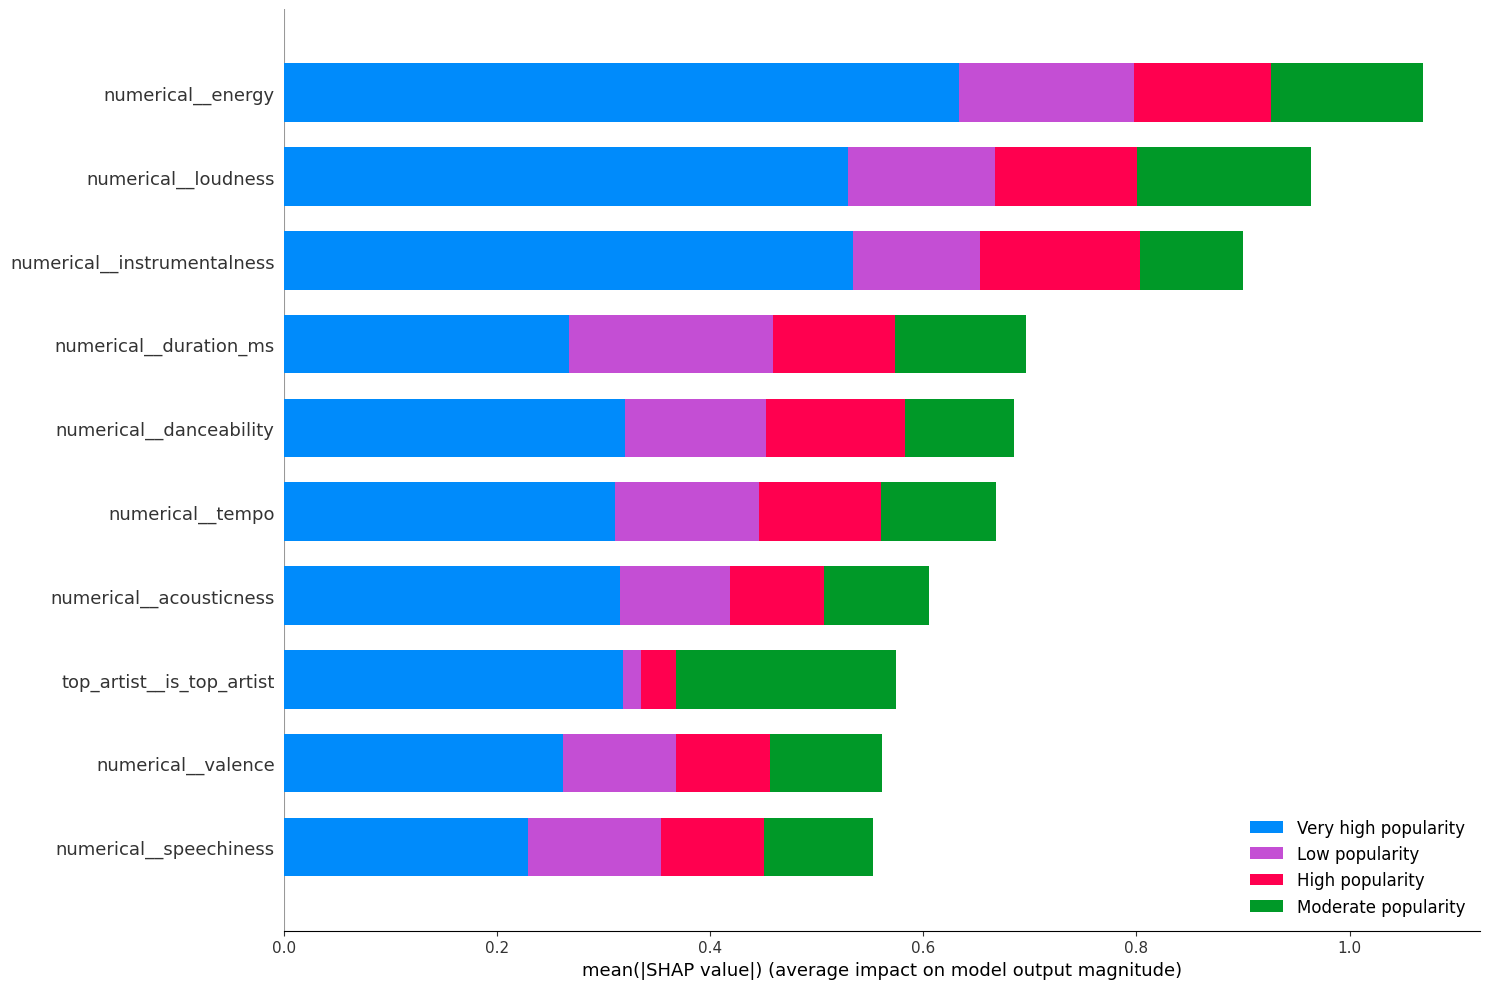

In [32]:
# Plot the SHAP summary bar plot for all classes with updated class names
shap.summary_plot(shap_values, X_test_transformed, plot_type="bar", class_names=['Low popularity', 'Moderate popularity', 'High popularity', 'Very high popularity'], max_display=10, plot_size=(15, 10))


## PyTorch Lightning Model

In [29]:
# # Load your data
# X_train_transformed, X_test_transformed, y_train, y_test = joblib.load("./data/processed/train_test_transformed_data.joblib")

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_transformed.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_val_tensor = torch.tensor(X_test_transformed.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_test.values, dtype=torch.long)
# Create PyTorch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create PyTorch data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

class ClassificationModel(pl.LightningModule):
    def __init__(self, input_size, num_classes, hidden_size, num_hidden_layers, dropout_rate, activation, lr):
        super().__init__()
        self.save_hyperparameters()
        layers = [nn.Linear(input_size, hidden_size), get_activation_fn(activation)()]
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(get_activation_fn(activation)())
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(hidden_size, num_classes))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        return optimizer

def get_activation_fn(activation):
    if activation == "relu":
        return nn.ReLU
    elif activation == "leaky_relu":
        return nn.LeakyReLU
    elif activation == "elu":
        return nn.ELU
    else:
        raise ValueError(f"Invalid activation function: {activation}")

def objective(trial):
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    hidden_size = trial.suggest_int("hidden_size", 32, 256, step=16)
    num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 3)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    activation = trial.suggest_categorical("activation", ["relu", "leaky_relu", "elu"])

    model = ClassificationModel(input_size=X_train_transformed.shape[1], num_classes=len(np.unique(y_train)),
                                hidden_size=hidden_size, num_hidden_layers=num_hidden_layers,
                                dropout_rate=dropout_rate, activation=activation, lr=lr)

    early_stop_callback = EarlyStopping(monitor="val_loss", patience=5, verbose=True, mode="min")
    trainer = pl.Trainer(max_epochs=100, callbacks=[early_stop_callback], accelerator="cuda" if torch.cuda.is_available() else "auto")

    trainer.fit(model, train_loader, val_loader)

    return trainer.callback_metrics["val_loss"].item()

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

best_params = study.best_trial.params
print("Best hyperparameters: ", best_params)

[I 2024-04-24 11:40:42,570] A new study created in memory with name: no-name-183805b1-f55a-488a-bc02-4f80f5f9f7dd


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\omsan\anaconda3\envs\eds_ml_2\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Missing logger folder: C:\Users\omsan\Desktop\Om\Mcgill\MMA 2023\Winter 2 2024\Enterpise ML Part 2\Group Project\Spotify-Music\lightning_logs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 19.3 K
--------------------------------------
19.3 K    Trainable param

c:\Users\omsan\anaconda3\envs\eds_ml_2\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\omsan\anaconda3\envs\eds_ml_2\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 739/739 [00:09<00:00, 74.74it/s, v_num=0, train_loss_step=0.951, train_acc_step=0.500, val_loss=1.080, val_acc=0.480, train_loss_epoch=1.140, train_acc_epoch=0.453]

Metric val_loss improved. New best score: 1.082


Epoch 1: 100%|██████████| 739/739 [00:10<00:00, 73.22it/s, v_num=0, train_loss_step=1.230, train_acc_step=0.450, val_loss=1.070, val_acc=0.492, train_loss_epoch=1.090, train_acc_epoch=0.481]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.070


Epoch 2: 100%|██████████| 739/739 [00:09<00:00, 75.28it/s, v_num=0, train_loss_step=1.240, train_acc_step=0.550, val_loss=1.060, val_acc=0.494, train_loss_epoch=1.080, train_acc_epoch=0.490]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.064


Epoch 3: 100%|██████████| 739/739 [00:08<00:00, 83.10it/s, v_num=0, train_loss_step=1.150, train_acc_step=0.350, val_loss=1.060, val_acc=0.504, train_loss_epoch=1.060, train_acc_epoch=0.502] 

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.059


Epoch 4: 100%|██████████| 739/739 [00:11<00:00, 65.31it/s, v_num=0, train_loss_step=1.060, train_acc_step=0.450, val_loss=1.060, val_acc=0.501, train_loss_epoch=1.050, train_acc_epoch=0.509]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.056


Epoch 5: 100%|██████████| 739/739 [00:09<00:00, 80.29it/s, v_num=0, train_loss_step=1.100, train_acc_step=0.300, val_loss=1.050, val_acc=0.512, train_loss_epoch=1.040, train_acc_epoch=0.512] 

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.050


Epoch 7: 100%|██████████| 739/739 [00:07<00:00, 93.74it/s, v_num=0, train_loss_step=0.913, train_acc_step=0.450, val_loss=1.050, val_acc=0.508, train_loss_epoch=1.020, train_acc_epoch=0.525] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.049


Epoch 12: 100%|██████████| 739/739 [00:08<00:00, 85.51it/s, v_num=0, train_loss_step=1.100, train_acc_step=0.450, val_loss=1.060, val_acc=0.510, train_loss_epoch=0.982, train_acc_epoch=0.543] 

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.049. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 739/739 [00:08<00:00, 85.37it/s, v_num=0, train_loss_step=1.100, train_acc_step=0.450, val_loss=1.060, val_acc=0.510, train_loss_epoch=0.982, train_acc_epoch=0.543]

[I 2024-04-24 11:42:47,248] Trial 0 finished with value: 1.0574873685836792 and parameters: {'lr': 0.0012261896778305826, 'hidden_size': 112, 'num_hidden_layers': 2, 'dropout_rate': 0.4709857909970271, 'activation': 'leaky_relu'}. Best is trial 0 with value: 1.0574873685836792.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 85.4 K
--------------------------------------
85.4 K    Trainable params
0         Non-trainable params
85.4 K    Total params
0.342     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:11<00:00, 63.03it/s, v_num=1, train_loss_step=1.180, train_acc_step=0.450, val_loss=1.080, val_acc=0.477, train_loss_epoch=1.120, train_acc_epoch=0.458]

Metric val_loss improved. New best score: 1.084


Epoch 1: 100%|██████████| 739/739 [00:11<00:00, 62.84it/s, v_num=1, train_loss_step=1.070, train_acc_step=0.600, val_loss=1.070, val_acc=0.495, train_loss_epoch=1.080, train_acc_epoch=0.488]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.066


Epoch 2: 100%|██████████| 739/739 [00:10<00:00, 68.18it/s, v_num=1, train_loss_step=1.140, train_acc_step=0.400, val_loss=1.070, val_acc=0.500, train_loss_epoch=1.060, train_acc_epoch=0.500]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.065


Epoch 3: 100%|██████████| 739/739 [00:11<00:00, 63.19it/s, v_num=1, train_loss_step=0.824, train_acc_step=0.750, val_loss=1.060, val_acc=0.506, train_loss_epoch=1.050, train_acc_epoch=0.511]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.063


Epoch 4: 100%|██████████| 739/739 [00:11<00:00, 66.10it/s, v_num=1, train_loss_step=1.320, train_acc_step=0.450, val_loss=1.060, val_acc=0.511, train_loss_epoch=1.030, train_acc_epoch=0.522]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.055


Epoch 9: 100%|██████████| 739/739 [00:11<00:00, 66.75it/s, v_num=1, train_loss_step=1.360, train_acc_step=0.350, val_loss=1.080, val_acc=0.510, train_loss_epoch=0.921, train_acc_epoch=0.570]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.055. Signaling Trainer to stop.


Epoch 9: 100%|██████████| 739/739 [00:11<00:00, 66.64it/s, v_num=1, train_loss_step=1.360, train_acc_step=0.350, val_loss=1.080, val_acc=0.510, train_loss_epoch=0.921, train_acc_epoch=0.570]

[I 2024-04-24 11:44:40,863] Trial 1 finished with value: 1.0800879001617432 and parameters: {'lr': 0.0018887538456703711, 'hidden_size': 192, 'num_hidden_layers': 3, 'dropout_rate': 0.12016430357315122, 'activation': 'relu'}. Best is trial 0 with value: 1.0574873685836792.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 24.3 K
--------------------------------------
24.3 K    Trainable params
0         Non-trainable params
24.3 K    Total params
0.097     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:10<00:00, 73.04it/s, v_num=2, train_loss_step=1.270, train_acc_step=0.300, val_loss=1.100, val_acc=0.473, train_loss_epoch=1.190, train_acc_epoch=0.430]

Metric val_loss improved. New best score: 1.104


Epoch 5: 100%|██████████| 739/739 [00:08<00:00, 83.26it/s, v_num=2, train_loss_step=1.420, train_acc_step=0.450, val_loss=1.140, val_acc=0.443, train_loss_epoch=1.200, train_acc_epoch=0.423]  

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.104. Signaling Trainer to stop.


Epoch 5: 100%|██████████| 739/739 [00:08<00:00, 83.09it/s, v_num=2, train_loss_step=1.420, train_acc_step=0.450, val_loss=1.140, val_acc=0.443, train_loss_epoch=1.200, train_acc_epoch=0.423]

[I 2024-04-24 11:45:36,049] Trial 2 finished with value: 1.1364333629608154 and parameters: {'lr': 0.007709858058748784, 'hidden_size': 96, 'num_hidden_layers': 3, 'dropout_rate': 0.3773386484958693, 'activation': 'elu'}. Best is trial 0 with value: 1.0574873685836792.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 85.4 K
--------------------------------------
85.4 K    Trainable params
0         Non-trainable params
85.4 K    Total params
0.342     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:09<00:00, 76.58it/s, v_num=3, train_loss_step=1.020, train_acc_step=0.700, val_loss=1.100, val_acc=0.465, train_loss_epoch=1.150, train_acc_epoch=0.447]

Metric val_loss improved. New best score: 1.099


Epoch 1: 100%|██████████| 739/739 [00:10<00:00, 73.13it/s, v_num=3, train_loss_step=1.080, train_acc_step=0.500, val_loss=1.080, val_acc=0.488, train_loss_epoch=1.100, train_acc_epoch=0.479]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.076


Epoch 2: 100%|██████████| 739/739 [00:10<00:00, 72.23it/s, v_num=3, train_loss_step=1.120, train_acc_step=0.600, val_loss=1.070, val_acc=0.503, train_loss_epoch=1.080, train_acc_epoch=0.490]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.067


Epoch 3: 100%|██████████| 739/739 [00:10<00:00, 72.75it/s, v_num=3, train_loss_step=1.290, train_acc_step=0.350, val_loss=1.070, val_acc=0.487, train_loss_epoch=1.070, train_acc_epoch=0.497]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.066


Epoch 4: 100%|██████████| 739/739 [00:10<00:00, 71.75it/s, v_num=3, train_loss_step=1.300, train_acc_step=0.500, val_loss=1.050, val_acc=0.512, train_loss_epoch=1.050, train_acc_epoch=0.502]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.055


Epoch 7: 100%|██████████| 739/739 [00:11<00:00, 61.74it/s, v_num=3, train_loss_step=1.070, train_acc_step=0.400, val_loss=1.050, val_acc=0.504, train_loss_epoch=1.020, train_acc_epoch=0.524]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.055


Epoch 12: 100%|██████████| 739/739 [00:09<00:00, 74.75it/s, v_num=3, train_loss_step=0.898, train_acc_step=0.500, val_loss=1.070, val_acc=0.506, train_loss_epoch=0.970, train_acc_epoch=0.548]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.055. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 739/739 [00:09<00:00, 74.60it/s, v_num=3, train_loss_step=0.898, train_acc_step=0.500, val_loss=1.070, val_acc=0.506, train_loss_epoch=0.970, train_acc_epoch=0.548]

[I 2024-04-24 11:47:47,664] Trial 3 finished with value: 1.0703562498092651 and parameters: {'lr': 0.0016667032659038567, 'hidden_size': 192, 'num_hidden_layers': 3, 'dropout_rate': 0.4987572893340163, 'activation': 'relu'}. Best is trial 0 with value: 1.0574873685836792.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 55.7 K
--------------------------------------
55.7 K    Trainable params
0         Non-trainable params
55.7 K    Total params
0.223     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:09<00:00, 77.79it/s, v_num=4, train_loss_step=1.000, train_acc_step=0.550, val_loss=1.100, val_acc=0.473, train_loss_epoch=1.140, train_acc_epoch=0.455]

Metric val_loss improved. New best score: 1.095


Epoch 1: 100%|██████████| 739/739 [00:09<00:00, 79.65it/s, v_num=4, train_loss_step=1.100, train_acc_step=0.550, val_loss=1.090, val_acc=0.485, train_loss_epoch=1.090, train_acc_epoch=0.481]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.090


Epoch 2: 100%|██████████| 739/739 [00:09<00:00, 80.63it/s, v_num=4, train_loss_step=1.300, train_acc_step=0.200, val_loss=1.080, val_acc=0.494, train_loss_epoch=1.090, train_acc_epoch=0.484] 

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.081


Epoch 3: 100%|██████████| 739/739 [00:09<00:00, 74.16it/s, v_num=4, train_loss_step=1.220, train_acc_step=0.350, val_loss=1.080, val_acc=0.493, train_loss_epoch=1.090, train_acc_epoch=0.480] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.078


Epoch 6: 100%|██████████| 739/739 [00:09<00:00, 82.09it/s, v_num=4, train_loss_step=1.250, train_acc_step=0.450, val_loss=1.080, val_acc=0.486, train_loss_epoch=1.080, train_acc_epoch=0.485] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.078


Epoch 7: 100%|██████████| 739/739 [00:09<00:00, 79.39it/s, v_num=4, train_loss_step=1.130, train_acc_step=0.500, val_loss=1.080, val_acc=0.489, train_loss_epoch=1.080, train_acc_epoch=0.491]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.076


Epoch 8: 100%|██████████| 739/739 [00:09<00:00, 76.77it/s, v_num=4, train_loss_step=0.891, train_acc_step=0.650, val_loss=1.070, val_acc=0.494, train_loss_epoch=1.080, train_acc_epoch=0.488]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.074


Epoch 10: 100%|██████████| 739/739 [00:09<00:00, 81.33it/s, v_num=4, train_loss_step=1.210, train_acc_step=0.350, val_loss=1.070, val_acc=0.496, train_loss_epoch=1.080, train_acc_epoch=0.491]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.072


Epoch 11: 100%|██████████| 739/739 [00:09<00:00, 78.45it/s, v_num=4, train_loss_step=1.180, train_acc_step=0.400, val_loss=1.070, val_acc=0.499, train_loss_epoch=1.070, train_acc_epoch=0.493]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.070


Epoch 13: 100%|██████████| 739/739 [00:08<00:00, 82.58it/s, v_num=4, train_loss_step=0.998, train_acc_step=0.500, val_loss=1.070, val_acc=0.500, train_loss_epoch=1.070, train_acc_epoch=0.494]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.065


Epoch 15: 100%|██████████| 739/739 [00:09<00:00, 81.10it/s, v_num=4, train_loss_step=0.903, train_acc_step=0.600, val_loss=1.070, val_acc=0.496, train_loss_epoch=1.070, train_acc_epoch=0.497] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.065


Epoch 17: 100%|██████████| 739/739 [00:09<00:00, 81.16it/s, v_num=4, train_loss_step=1.070, train_acc_step=0.650, val_loss=1.060, val_acc=0.498, train_loss_epoch=1.060, train_acc_epoch=0.495] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.065


Epoch 18: 100%|██████████| 739/739 [00:09<00:00, 74.81it/s, v_num=4, train_loss_step=0.901, train_acc_step=0.650, val_loss=1.060, val_acc=0.501, train_loss_epoch=1.060, train_acc_epoch=0.501]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.064


Epoch 19: 100%|██████████| 739/739 [00:09<00:00, 79.18it/s, v_num=4, train_loss_step=1.180, train_acc_step=0.450, val_loss=1.060, val_acc=0.506, train_loss_epoch=1.060, train_acc_epoch=0.505]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.058


Epoch 23: 100%|██████████| 739/739 [00:08<00:00, 85.66it/s, v_num=4, train_loss_step=1.390, train_acc_step=0.350, val_loss=1.060, val_acc=0.506, train_loss_epoch=1.050, train_acc_epoch=0.507] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.055


Epoch 28: 100%|██████████| 739/739 [00:08<00:00, 86.59it/s, v_num=4, train_loss_step=0.896, train_acc_step=0.650, val_loss=1.050, val_acc=0.511, train_loss_epoch=1.050, train_acc_epoch=0.511] 

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.051


Epoch 32: 100%|██████████| 739/739 [00:08<00:00, 84.54it/s, v_num=4, train_loss_step=0.853, train_acc_step=0.650, val_loss=1.050, val_acc=0.512, train_loss_epoch=1.040, train_acc_epoch=0.511] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.051


Epoch 33: 100%|██████████| 739/739 [00:09<00:00, 81.03it/s, v_num=4, train_loss_step=0.909, train_acc_step=0.500, val_loss=1.050, val_acc=0.510, train_loss_epoch=1.040, train_acc_epoch=0.516]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.050


Epoch 37: 100%|██████████| 739/739 [00:08<00:00, 83.47it/s, v_num=4, train_loss_step=1.060, train_acc_step=0.600, val_loss=1.050, val_acc=0.513, train_loss_epoch=1.030, train_acc_epoch=0.521] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.049


Epoch 38: 100%|██████████| 739/739 [00:09<00:00, 78.98it/s, v_num=4, train_loss_step=1.120, train_acc_step=0.450, val_loss=1.050, val_acc=0.511, train_loss_epoch=1.030, train_acc_epoch=0.519] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.047


Epoch 43: 100%|██████████| 739/739 [00:08<00:00, 83.77it/s, v_num=4, train_loss_step=0.971, train_acc_step=0.600, val_loss=1.050, val_acc=0.507, train_loss_epoch=1.030, train_acc_epoch=0.523] 

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.047. Signaling Trainer to stop.


Epoch 43: 100%|██████████| 739/739 [00:08<00:00, 83.60it/s, v_num=4, train_loss_step=0.971, train_acc_step=0.600, val_loss=1.050, val_acc=0.507, train_loss_epoch=1.030, train_acc_epoch=0.523]

[I 2024-04-24 11:54:35,628] Trial 4 finished with value: 1.0504974126815796 and parameters: {'lr': 0.00033058628444845417, 'hidden_size': 208, 'num_hidden_layers': 2, 'dropout_rate': 0.19687261683547305, 'activation': 'elu'}. Best is trial 4 with value: 1.0504974126815796.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 50.3 K
--------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:09<00:00, 74.23it/s, v_num=5, train_loss_step=1.170, train_acc_step=0.350, val_loss=1.100, val_acc=0.482, train_loss_epoch=1.140, train_acc_epoch=0.455]

Metric val_loss improved. New best score: 1.097


Epoch 1: 100%|██████████| 739/739 [00:09<00:00, 75.85it/s, v_num=5, train_loss_step=0.911, train_acc_step=0.500, val_loss=1.080, val_acc=0.489, train_loss_epoch=1.100, train_acc_epoch=0.479]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.082


Epoch 3: 100%|██████████| 739/739 [00:09<00:00, 78.61it/s, v_num=5, train_loss_step=0.913, train_acc_step=0.650, val_loss=1.080, val_acc=0.487, train_loss_epoch=1.090, train_acc_epoch=0.482]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.080


Epoch 4: 100%|██████████| 739/739 [00:09<00:00, 77.02it/s, v_num=5, train_loss_step=0.997, train_acc_step=0.550, val_loss=1.080, val_acc=0.487, train_loss_epoch=1.090, train_acc_epoch=0.486]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.080


Epoch 5: 100%|██████████| 739/739 [00:09<00:00, 75.82it/s, v_num=5, train_loss_step=1.110, train_acc_step=0.500, val_loss=1.080, val_acc=0.490, train_loss_epoch=1.090, train_acc_epoch=0.482]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.078


Epoch 7: 100%|██████████| 739/739 [00:09<00:00, 77.11it/s, v_num=5, train_loss_step=1.160, train_acc_step=0.450, val_loss=1.080, val_acc=0.491, train_loss_epoch=1.080, train_acc_epoch=0.491]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.075


Epoch 8: 100%|██████████| 739/739 [00:09<00:00, 75.88it/s, v_num=5, train_loss_step=1.090, train_acc_step=0.500, val_loss=1.070, val_acc=0.490, train_loss_epoch=1.080, train_acc_epoch=0.488]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.074


Epoch 9: 100%|██████████| 739/739 [00:09<00:00, 76.44it/s, v_num=5, train_loss_step=1.150, train_acc_step=0.250, val_loss=1.070, val_acc=0.499, train_loss_epoch=1.080, train_acc_epoch=0.488]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.066


Epoch 14: 100%|██████████| 739/739 [00:09<00:00, 76.68it/s, v_num=5, train_loss_step=1.110, train_acc_step=0.500, val_loss=1.060, val_acc=0.501, train_loss_epoch=1.070, train_acc_epoch=0.493]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.062


Epoch 15: 100%|██████████| 739/739 [00:09<00:00, 75.55it/s, v_num=5, train_loss_step=1.040, train_acc_step=0.600, val_loss=1.060, val_acc=0.499, train_loss_epoch=1.060, train_acc_epoch=0.500]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.058


Epoch 20: 100%|██████████| 739/739 [00:09<00:00, 76.84it/s, v_num=5, train_loss_step=0.915, train_acc_step=0.650, val_loss=1.060, val_acc=0.509, train_loss_epoch=1.060, train_acc_epoch=0.503]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.058


Epoch 22: 100%|██████████| 739/739 [00:09<00:00, 77.82it/s, v_num=5, train_loss_step=0.945, train_acc_step=0.550, val_loss=1.060, val_acc=0.500, train_loss_epoch=1.050, train_acc_epoch=0.504]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.057


Epoch 23: 100%|██████████| 739/739 [00:09<00:00, 74.77it/s, v_num=5, train_loss_step=1.070, train_acc_step=0.550, val_loss=1.060, val_acc=0.503, train_loss_epoch=1.050, train_acc_epoch=0.502]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.057


Epoch 25: 100%|██████████| 739/739 [00:09<00:00, 78.93it/s, v_num=5, train_loss_step=0.917, train_acc_step=0.450, val_loss=1.050, val_acc=0.504, train_loss_epoch=1.050, train_acc_epoch=0.508]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.052


Epoch 29: 100%|██████████| 739/739 [00:09<00:00, 75.18it/s, v_num=5, train_loss_step=1.150, train_acc_step=0.450, val_loss=1.050, val_acc=0.509, train_loss_epoch=1.040, train_acc_epoch=0.512]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.050


Epoch 30: 100%|██████████| 739/739 [00:09<00:00, 75.09it/s, v_num=5, train_loss_step=1.260, train_acc_step=0.450, val_loss=1.050, val_acc=0.515, train_loss_epoch=1.040, train_acc_epoch=0.513]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.050


Epoch 35: 100%|██████████| 739/739 [00:11<00:00, 62.90it/s, v_num=5, train_loss_step=0.916, train_acc_step=0.650, val_loss=1.050, val_acc=0.514, train_loss_epoch=1.030, train_acc_epoch=0.519]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.050. Signaling Trainer to stop.


Epoch 35: 100%|██████████| 739/739 [00:11<00:00, 62.78it/s, v_num=5, train_loss_step=0.916, train_acc_step=0.650, val_loss=1.050, val_acc=0.514, train_loss_epoch=1.030, train_acc_epoch=0.519]

[I 2024-04-24 12:00:28,443] Trial 5 finished with value: 1.0496712923049927 and parameters: {'lr': 0.00044317354068919903, 'hidden_size': 144, 'num_hidden_layers': 3, 'dropout_rate': 0.18834442894150333, 'activation': 'elu'}. Best is trial 5 with value: 1.0496712923049927.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 2.9 K 
--------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.012     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:08<00:00, 91.53it/s, v_num=6, train_loss_step=1.000, train_acc_step=0.500, val_loss=1.100, val_acc=0.471, train_loss_epoch=1.130, train_acc_epoch=0.459]

Metric val_loss improved. New best score: 1.096


Epoch 1: 100%|██████████| 739/739 [00:08<00:00, 91.64it/s, v_num=6, train_loss_step=0.910, train_acc_step=0.700, val_loss=1.090, val_acc=0.475, train_loss_epoch=1.110, train_acc_epoch=0.473] 

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.091


Epoch 2: 100%|██████████| 739/739 [00:07<00:00, 96.66it/s, v_num=6, train_loss_step=1.100, train_acc_step=0.450, val_loss=1.080, val_acc=0.485, train_loss_epoch=1.100, train_acc_epoch=0.476] 

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.083


Epoch 3: 100%|██████████| 739/739 [00:07<00:00, 94.17it/s, v_num=6, train_loss_step=1.230, train_acc_step=0.400, val_loss=1.080, val_acc=0.486, train_loss_epoch=1.100, train_acc_epoch=0.479] 

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.079


Epoch 4: 100%|██████████| 739/739 [00:07<00:00, 99.08it/s, v_num=6, train_loss_step=1.090, train_acc_step=0.550, val_loss=1.080, val_acc=0.485, train_loss_epoch=1.090, train_acc_epoch=0.482] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.077


Epoch 5: 100%|██████████| 739/739 [00:07<00:00, 99.08it/s, v_num=6, train_loss_step=1.100, train_acc_step=0.500, val_loss=1.070, val_acc=0.495, train_loss_epoch=1.090, train_acc_epoch=0.483] 

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.067


Epoch 7: 100%|██████████| 739/739 [00:07<00:00, 100.47it/s, v_num=6, train_loss_step=1.060, train_acc_step=0.600, val_loss=1.060, val_acc=0.501, train_loss_epoch=1.080, train_acc_epoch=0.486]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.060


Epoch 12: 100%|██████████| 739/739 [00:07<00:00, 99.45it/s, v_num=6, train_loss_step=0.958, train_acc_step=0.600, val_loss=1.060, val_acc=0.508, train_loss_epoch=1.070, train_acc_epoch=0.498] 

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.060. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 739/739 [00:07<00:00, 99.30it/s, v_num=6, train_loss_step=0.958, train_acc_step=0.600, val_loss=1.060, val_acc=0.508, train_loss_epoch=1.070, train_acc_epoch=0.498]


[I 2024-04-24 12:02:07,754] Trial 6 finished with value: 1.0629445314407349 and parameters: {'lr': 0.005171443581041231, 'hidden_size': 32, 'num_hidden_layers': 2, 'dropout_rate': 0.4232766101060511, 'activation': 'elu'}. Best is trial 5 with value: 1.0496712923049927.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 85.4 K
--------------------------------------
85.4 K    Trainable params
0         Non-trainable params
85.4 K    Total params
0.342     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:10<00:00, 71.39it/s, v_num=7, train_loss_step=0.965, train_acc_step=0.600, val_loss=1.100, val_acc=0.476, train_loss_epoch=1.160, train_acc_epoch=0.444]

Metric val_loss improved. New best score: 1.098


Epoch 1: 100%|██████████| 739/739 [00:10<00:00, 72.59it/s, v_num=7, train_loss_step=1.360, train_acc_step=0.200, val_loss=1.090, val_acc=0.488, train_loss_epoch=1.100, train_acc_epoch=0.474]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.089


Epoch 2: 100%|██████████| 739/739 [00:10<00:00, 71.68it/s, v_num=7, train_loss_step=1.090, train_acc_step=0.550, val_loss=1.080, val_acc=0.482, train_loss_epoch=1.090, train_acc_epoch=0.479]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.083


Epoch 4: 100%|██████████| 739/739 [00:12<00:00, 59.63it/s, v_num=7, train_loss_step=0.869, train_acc_step=0.750, val_loss=1.080, val_acc=0.492, train_loss_epoch=1.090, train_acc_epoch=0.477]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.078


Epoch 8: 100%|██████████| 739/739 [00:09<00:00, 74.20it/s, v_num=7, train_loss_step=0.992, train_acc_step=0.400, val_loss=1.080, val_acc=0.487, train_loss_epoch=1.090, train_acc_epoch=0.484]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.077


Epoch 9: 100%|██████████| 739/739 [00:10<00:00, 72.51it/s, v_num=7, train_loss_step=1.170, train_acc_step=0.500, val_loss=1.070, val_acc=0.494, train_loss_epoch=1.090, train_acc_epoch=0.486]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.074


Epoch 11: 100%|██████████| 739/739 [00:10<00:00, 72.39it/s, v_num=7, train_loss_step=1.300, train_acc_step=0.450, val_loss=1.070, val_acc=0.492, train_loss_epoch=1.080, train_acc_epoch=0.486]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.073


Epoch 12: 100%|██████████| 739/739 [00:10<00:00, 71.81it/s, v_num=7, train_loss_step=1.160, train_acc_step=0.350, val_loss=1.070, val_acc=0.492, train_loss_epoch=1.080, train_acc_epoch=0.487]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.072


Epoch 14: 100%|██████████| 739/739 [00:10<00:00, 73.52it/s, v_num=7, train_loss_step=1.160, train_acc_step=0.500, val_loss=1.070, val_acc=0.495, train_loss_epoch=1.080, train_acc_epoch=0.491]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.071


Epoch 16: 100%|██████████| 739/739 [00:10<00:00, 73.45it/s, v_num=7, train_loss_step=0.941, train_acc_step=0.450, val_loss=1.070, val_acc=0.493, train_loss_epoch=1.080, train_acc_epoch=0.488]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.069


Epoch 17: 100%|██████████| 739/739 [00:10<00:00, 70.66it/s, v_num=7, train_loss_step=1.290, train_acc_step=0.550, val_loss=1.070, val_acc=0.490, train_loss_epoch=1.080, train_acc_epoch=0.491]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.069


Epoch 18: 100%|██████████| 739/739 [00:10<00:00, 71.76it/s, v_num=7, train_loss_step=1.110, train_acc_step=0.500, val_loss=1.070, val_acc=0.493, train_loss_epoch=1.070, train_acc_epoch=0.494]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.066


Epoch 22: 100%|██████████| 739/739 [00:10<00:00, 69.27it/s, v_num=7, train_loss_step=0.880, train_acc_step=0.650, val_loss=1.070, val_acc=0.493, train_loss_epoch=1.070, train_acc_epoch=0.495]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.066


Epoch 23: 100%|██████████| 739/739 [00:10<00:00, 72.20it/s, v_num=7, train_loss_step=1.420, train_acc_step=0.250, val_loss=1.070, val_acc=0.501, train_loss_epoch=1.070, train_acc_epoch=0.496]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.066


Epoch 25: 100%|██████████| 739/739 [00:09<00:00, 74.45it/s, v_num=7, train_loss_step=1.000, train_acc_step=0.650, val_loss=1.060, val_acc=0.498, train_loss_epoch=1.070, train_acc_epoch=0.497]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.063


Epoch 26: 100%|██████████| 739/739 [00:10<00:00, 72.46it/s, v_num=7, train_loss_step=1.050, train_acc_step=0.450, val_loss=1.060, val_acc=0.497, train_loss_epoch=1.070, train_acc_epoch=0.496]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.061


Epoch 31: 100%|██████████| 739/739 [00:10<00:00, 73.58it/s, v_num=7, train_loss_step=0.996, train_acc_step=0.600, val_loss=1.060, val_acc=0.503, train_loss_epoch=1.060, train_acc_epoch=0.501]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.058


Epoch 35: 100%|██████████| 739/739 [00:09<00:00, 73.93it/s, v_num=7, train_loss_step=0.900, train_acc_step=0.650, val_loss=1.060, val_acc=0.508, train_loss_epoch=1.060, train_acc_epoch=0.502]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.055


Epoch 39: 100%|██████████| 739/739 [00:10<00:00, 71.47it/s, v_num=7, train_loss_step=1.120, train_acc_step=0.400, val_loss=1.050, val_acc=0.500, train_loss_epoch=1.050, train_acc_epoch=0.507]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.054


Epoch 40: 100%|██████████| 739/739 [00:10<00:00, 70.63it/s, v_num=7, train_loss_step=1.030, train_acc_step=0.650, val_loss=1.050, val_acc=0.505, train_loss_epoch=1.050, train_acc_epoch=0.506]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.053


Epoch 42: 100%|██████████| 739/739 [00:10<00:00, 72.26it/s, v_num=7, train_loss_step=1.040, train_acc_step=0.500, val_loss=1.050, val_acc=0.505, train_loss_epoch=1.050, train_acc_epoch=0.508]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.053


Epoch 47: 100%|██████████| 739/739 [00:10<00:00, 71.71it/s, v_num=7, train_loss_step=1.000, train_acc_step=0.450, val_loss=1.050, val_acc=0.511, train_loss_epoch=1.050, train_acc_epoch=0.509]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.051


Epoch 51: 100%|██████████| 739/739 [00:10<00:00, 73.43it/s, v_num=7, train_loss_step=1.320, train_acc_step=0.250, val_loss=1.050, val_acc=0.506, train_loss_epoch=1.040, train_acc_epoch=0.514]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.051


Epoch 52: 100%|██████████| 739/739 [00:10<00:00, 70.86it/s, v_num=7, train_loss_step=0.993, train_acc_step=0.550, val_loss=1.050, val_acc=0.509, train_loss_epoch=1.040, train_acc_epoch=0.512]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.050


Epoch 53: 100%|██████████| 739/739 [00:10<00:00, 71.31it/s, v_num=7, train_loss_step=1.330, train_acc_step=0.350, val_loss=1.050, val_acc=0.508, train_loss_epoch=1.040, train_acc_epoch=0.512]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.050


Epoch 58: 100%|██████████| 739/739 [00:10<00:00, 72.05it/s, v_num=7, train_loss_step=1.340, train_acc_step=0.350, val_loss=1.050, val_acc=0.506, train_loss_epoch=1.040, train_acc_epoch=0.517]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.050. Signaling Trainer to stop.


Epoch 58: 100%|██████████| 739/739 [00:10<00:00, 71.95it/s, v_num=7, train_loss_step=1.340, train_acc_step=0.350, val_loss=1.050, val_acc=0.506, train_loss_epoch=1.040, train_acc_epoch=0.517]

[I 2024-04-24 12:12:20,822] Trial 7 finished with value: 1.0499399900436401 and parameters: {'lr': 0.00017550253418002719, 'hidden_size': 192, 'num_hidden_layers': 3, 'dropout_rate': 0.2528095816058039, 'activation': 'elu'}. Best is trial 5 with value: 1.0496712923049927.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 5.7 K 
--------------------------------------
5.7 K     Trainable params
0         Non-trainable params
5.7 K     Total params
0.023     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:07<00:00, 98.47it/s, v_num=8, train_loss_step=1.290, train_acc_step=0.350, val_loss=1.150, val_acc=0.462, train_loss_epoch=1.200, train_acc_epoch=0.430]

Metric val_loss improved. New best score: 1.154


Epoch 1: 100%|██████████| 739/739 [00:07<00:00, 100.00it/s, v_num=8, train_loss_step=1.220, train_acc_step=0.400, val_loss=1.120, val_acc=0.472, train_loss_epoch=1.130, train_acc_epoch=0.468]

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 1.116


Epoch 2: 100%|██████████| 739/739 [00:07<00:00, 99.09it/s, v_num=8, train_loss_step=1.150, train_acc_step=0.400, val_loss=1.100, val_acc=0.482, train_loss_epoch=1.110, train_acc_epoch=0.477] 

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.096


Epoch 3: 100%|██████████| 739/739 [00:07<00:00, 95.96it/s, v_num=8, train_loss_step=1.030, train_acc_step=0.450, val_loss=1.090, val_acc=0.485, train_loss_epoch=1.090, train_acc_epoch=0.485] 

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.085


Epoch 4: 100%|██████████| 739/739 [00:07<00:00, 96.10it/s, v_num=8, train_loss_step=1.280, train_acc_step=0.400, val_loss=1.080, val_acc=0.491, train_loss_epoch=1.080, train_acc_epoch=0.487] 

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.080


Epoch 5: 100%|██████████| 739/739 [00:07<00:00, 99.73it/s, v_num=8, train_loss_step=1.250, train_acc_step=0.300, val_loss=1.080, val_acc=0.490, train_loss_epoch=1.080, train_acc_epoch=0.492] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.077


Epoch 6: 100%|██████████| 739/739 [00:07<00:00, 97.01it/s, v_num=8, train_loss_step=1.040, train_acc_step=0.600, val_loss=1.080, val_acc=0.492, train_loss_epoch=1.080, train_acc_epoch=0.494] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.075


Epoch 7: 100%|██████████| 739/739 [00:07<00:00, 98.17it/s, v_num=8, train_loss_step=1.050, train_acc_step=0.450, val_loss=1.070, val_acc=0.497, train_loss_epoch=1.070, train_acc_epoch=0.496] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.073


Epoch 9: 100%|██████████| 739/739 [00:09<00:00, 75.16it/s, v_num=8, train_loss_step=1.100, train_acc_step=0.450, val_loss=1.070, val_acc=0.498, train_loss_epoch=1.070, train_acc_epoch=0.498] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.071


Epoch 10: 100%|██████████| 739/739 [00:07<00:00, 99.42it/s, v_num=8, train_loss_step=1.030, train_acc_step=0.600, val_loss=1.070, val_acc=0.499, train_loss_epoch=1.070, train_acc_epoch=0.500] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.071


Epoch 11: 100%|██████████| 739/739 [00:07<00:00, 97.85it/s, v_num=8, train_loss_step=0.966, train_acc_step=0.550, val_loss=1.070, val_acc=0.498, train_loss_epoch=1.070, train_acc_epoch=0.501] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.070


Epoch 12: 100%|██████████| 739/739 [00:09<00:00, 75.89it/s, v_num=8, train_loss_step=0.970, train_acc_step=0.600, val_loss=1.070, val_acc=0.497, train_loss_epoch=1.060, train_acc_epoch=0.503]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.069


Epoch 15: 100%|██████████| 739/739 [00:13<00:00, 54.87it/s, v_num=8, train_loss_step=1.180, train_acc_step=0.450, val_loss=1.070, val_acc=0.501, train_loss_epoch=1.060, train_acc_epoch=0.505]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.066


Epoch 17: 100%|██████████| 739/739 [00:11<00:00, 63.49it/s, v_num=8, train_loss_step=1.130, train_acc_step=0.350, val_loss=1.070, val_acc=0.507, train_loss_epoch=1.060, train_acc_epoch=0.507]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.065


Epoch 18: 100%|██████████| 739/739 [00:11<00:00, 63.20it/s, v_num=8, train_loss_step=1.090, train_acc_step=0.350, val_loss=1.060, val_acc=0.504, train_loss_epoch=1.050, train_acc_epoch=0.508]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.064


Epoch 20: 100%|██████████| 739/739 [00:09<00:00, 74.27it/s, v_num=8, train_loss_step=1.020, train_acc_step=0.600, val_loss=1.060, val_acc=0.507, train_loss_epoch=1.050, train_acc_epoch=0.510]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.064


Epoch 21: 100%|██████████| 739/739 [00:09<00:00, 76.52it/s, v_num=8, train_loss_step=0.899, train_acc_step=0.650, val_loss=1.060, val_acc=0.508, train_loss_epoch=1.050, train_acc_epoch=0.512]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.062


Epoch 23: 100%|██████████| 739/739 [00:10<00:00, 70.62it/s, v_num=8, train_loss_step=1.190, train_acc_step=0.400, val_loss=1.060, val_acc=0.505, train_loss_epoch=1.050, train_acc_epoch=0.515]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.062


Epoch 24: 100%|██████████| 739/739 [00:10<00:00, 71.11it/s, v_num=8, train_loss_step=1.500, train_acc_step=0.350, val_loss=1.060, val_acc=0.504, train_loss_epoch=1.040, train_acc_epoch=0.515]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.061


Epoch 25: 100%|██████████| 739/739 [00:09<00:00, 77.01it/s, v_num=8, train_loss_step=1.050, train_acc_step=0.450, val_loss=1.060, val_acc=0.506, train_loss_epoch=1.040, train_acc_epoch=0.517] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.061


Epoch 27: 100%|██████████| 739/739 [00:09<00:00, 75.34it/s, v_num=8, train_loss_step=1.010, train_acc_step=0.500, val_loss=1.060, val_acc=0.507, train_loss_epoch=1.040, train_acc_epoch=0.519]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.059


Epoch 29: 100%|██████████| 739/739 [00:11<00:00, 63.12it/s, v_num=8, train_loss_step=1.180, train_acc_step=0.400, val_loss=1.060, val_acc=0.508, train_loss_epoch=1.040, train_acc_epoch=0.522] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.058


Epoch 34: 100%|██████████| 739/739 [00:12<00:00, 61.36it/s, v_num=8, train_loss_step=0.936, train_acc_step=0.650, val_loss=1.060, val_acc=0.514, train_loss_epoch=1.030, train_acc_epoch=0.524]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.056


Epoch 35: 100%|██████████| 739/739 [00:12<00:00, 59.85it/s, v_num=8, train_loss_step=1.230, train_acc_step=0.550, val_loss=1.060, val_acc=0.511, train_loss_epoch=1.030, train_acc_epoch=0.523]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.056


Epoch 38: 100%|██████████| 739/739 [00:15<00:00, 49.06it/s, v_num=8, train_loss_step=0.946, train_acc_step=0.500, val_loss=1.060, val_acc=0.511, train_loss_epoch=1.030, train_acc_epoch=0.526]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.056


Epoch 40: 100%|██████████| 739/739 [00:12<00:00, 60.68it/s, v_num=8, train_loss_step=1.100, train_acc_step=0.500, val_loss=1.060, val_acc=0.512, train_loss_epoch=1.030, train_acc_epoch=0.528]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.055


Epoch 43: 100%|██████████| 739/739 [00:11<00:00, 62.96it/s, v_num=8, train_loss_step=1.030, train_acc_step=0.600, val_loss=1.060, val_acc=0.513, train_loss_epoch=1.020, train_acc_epoch=0.531]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.055


Epoch 46: 100%|██████████| 739/739 [00:12<00:00, 61.20it/s, v_num=8, train_loss_step=1.120, train_acc_step=0.400, val_loss=1.050, val_acc=0.511, train_loss_epoch=1.020, train_acc_epoch=0.532]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.055


Epoch 49: 100%|██████████| 739/739 [00:12<00:00, 60.21it/s, v_num=8, train_loss_step=0.898, train_acc_step=0.550, val_loss=1.050, val_acc=0.512, train_loss_epoch=1.020, train_acc_epoch=0.533]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.054


Epoch 52: 100%|██████████| 739/739 [00:12<00:00, 59.84it/s, v_num=8, train_loss_step=0.836, train_acc_step=0.750, val_loss=1.050, val_acc=0.513, train_loss_epoch=1.010, train_acc_epoch=0.536]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.054


Epoch 57: 100%|██████████| 739/739 [00:12<00:00, 59.88it/s, v_num=8, train_loss_step=0.974, train_acc_step=0.400, val_loss=1.050, val_acc=0.514, train_loss_epoch=1.010, train_acc_epoch=0.538]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.053


Epoch 60: 100%|██████████| 739/739 [00:12<00:00, 60.02it/s, v_num=8, train_loss_step=0.886, train_acc_step=0.450, val_loss=1.050, val_acc=0.513, train_loss_epoch=1.010, train_acc_epoch=0.539]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.053


Epoch 64: 100%|██████████| 739/739 [00:16<00:00, 45.72it/s, v_num=8, train_loss_step=1.060, train_acc_step=0.400, val_loss=1.050, val_acc=0.510, train_loss_epoch=1.010, train_acc_epoch=0.542]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.053


Epoch 69: 100%|██████████| 739/739 [00:08<00:00, 84.94it/s, v_num=8, train_loss_step=1.160, train_acc_step=0.550, val_loss=1.050, val_acc=0.513, train_loss_epoch=1.000, train_acc_epoch=0.544]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.053. Signaling Trainer to stop.


Epoch 69: 100%|██████████| 739/739 [00:08<00:00, 84.80it/s, v_num=8, train_loss_step=1.160, train_acc_step=0.550, val_loss=1.050, val_acc=0.513, train_loss_epoch=1.000, train_acc_epoch=0.544]

[I 2024-04-24 12:25:32,303] Trial 8 finished with value: 1.0536092519760132 and parameters: {'lr': 0.00016570990823338173, 'hidden_size': 96, 'num_hidden_layers': 1, 'dropout_rate': 0.278210256911436, 'activation': 'leaky_relu'}. Best is trial 5 with value: 1.0496712923049927.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 2.9 K 
--------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.012     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:07<00:00, 95.01it/s, v_num=9, train_loss_step=1.120, train_acc_step=0.400, val_loss=1.090, val_acc=0.474, train_loss_epoch=1.150, train_acc_epoch=0.451]

Metric val_loss improved. New best score: 1.088


Epoch 1: 100%|██████████| 739/739 [00:07<00:00, 95.10it/s, v_num=9, train_loss_step=1.180, train_acc_step=0.400, val_loss=1.090, val_acc=0.484, train_loss_epoch=1.110, train_acc_epoch=0.476] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.085


Epoch 2: 100%|██████████| 739/739 [00:07<00:00, 102.98it/s, v_num=9, train_loss_step=1.170, train_acc_step=0.300, val_loss=1.090, val_acc=0.481, train_loss_epoch=1.100, train_acc_epoch=0.477]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.085


Epoch 3: 100%|██████████| 739/739 [00:07<00:00, 103.52it/s, v_num=9, train_loss_step=1.210, train_acc_step=0.300, val_loss=1.080, val_acc=0.489, train_loss_epoch=1.100, train_acc_epoch=0.479]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.079


Epoch 4: 100%|██████████| 739/739 [00:07<00:00, 93.92it/s, v_num=9, train_loss_step=1.140, train_acc_step=0.300, val_loss=1.080, val_acc=0.492, train_loss_epoch=1.090, train_acc_epoch=0.479] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.079


Epoch 5: 100%|██████████| 739/739 [00:07<00:00, 103.39it/s, v_num=9, train_loss_step=0.943, train_acc_step=0.600, val_loss=1.070, val_acc=0.494, train_loss_epoch=1.090, train_acc_epoch=0.484]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.075


Epoch 7: 100%|██████████| 739/739 [00:07<00:00, 104.62it/s, v_num=9, train_loss_step=1.040, train_acc_step=0.500, val_loss=1.070, val_acc=0.495, train_loss_epoch=1.090, train_acc_epoch=0.483]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.069


Epoch 12: 100%|██████████| 739/739 [00:07<00:00, 100.64it/s, v_num=9, train_loss_step=0.913, train_acc_step=0.650, val_loss=1.060, val_acc=0.500, train_loss_epoch=1.070, train_acc_epoch=0.492]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.064


Epoch 13: 100%|██████████| 739/739 [00:07<00:00, 95.62it/s, v_num=9, train_loss_step=1.140, train_acc_step=0.500, val_loss=1.060, val_acc=0.498, train_loss_epoch=1.070, train_acc_epoch=0.490] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.061


Epoch 18: 100%|██████████| 739/739 [00:08<00:00, 89.95it/s, v_num=9, train_loss_step=1.230, train_acc_step=0.450, val_loss=1.060, val_acc=0.504, train_loss_epoch=1.060, train_acc_epoch=0.500] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.059


Epoch 19: 100%|██████████| 739/739 [00:08<00:00, 86.88it/s, v_num=9, train_loss_step=1.020, train_acc_step=0.650, val_loss=1.060, val_acc=0.506, train_loss_epoch=1.060, train_acc_epoch=0.502] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.058


Epoch 20: 100%|██████████| 739/739 [00:08<00:00, 86.19it/s, v_num=9, train_loss_step=0.971, train_acc_step=0.550, val_loss=1.060, val_acc=0.505, train_loss_epoch=1.060, train_acc_epoch=0.499] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.058


Epoch 22: 100%|██████████| 739/739 [00:08<00:00, 89.35it/s, v_num=9, train_loss_step=0.906, train_acc_step=0.550, val_loss=1.050, val_acc=0.511, train_loss_epoch=1.060, train_acc_epoch=0.503] 

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.052


Epoch 26: 100%|██████████| 739/739 [00:08<00:00, 88.77it/s, v_num=9, train_loss_step=1.150, train_acc_step=0.500, val_loss=1.050, val_acc=0.507, train_loss_epoch=1.050, train_acc_epoch=0.506] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.052


Epoch 30: 100%|██████████| 739/739 [00:08<00:00, 87.66it/s, v_num=9, train_loss_step=1.020, train_acc_step=0.550, val_loss=1.050, val_acc=0.515, train_loss_epoch=1.050, train_acc_epoch=0.506] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.051


Epoch 34: 100%|██████████| 739/739 [00:08<00:00, 87.97it/s, v_num=9, train_loss_step=0.969, train_acc_step=0.450, val_loss=1.050, val_acc=0.517, train_loss_epoch=1.050, train_acc_epoch=0.507] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.050


Epoch 37: 100%|██████████| 739/739 [00:08<00:00, 87.33it/s, v_num=9, train_loss_step=0.946, train_acc_step=0.650, val_loss=1.050, val_acc=0.521, train_loss_epoch=1.040, train_acc_epoch=0.512] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.048


Epoch 42: 100%|██████████| 739/739 [00:08<00:00, 87.12it/s, v_num=9, train_loss_step=0.982, train_acc_step=0.500, val_loss=1.050, val_acc=0.515, train_loss_epoch=1.040, train_acc_epoch=0.513] 

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.048. Signaling Trainer to stop.


Epoch 42: 100%|██████████| 739/739 [00:08<00:00, 87.00it/s, v_num=9, train_loss_step=0.982, train_acc_step=0.500, val_loss=1.050, val_acc=0.515, train_loss_epoch=1.040, train_acc_epoch=0.513]

[I 2024-04-24 12:31:22,542] Trial 9 finished with value: 1.0502374172210693 and parameters: {'lr': 0.0015844850008277583, 'hidden_size': 32, 'num_hidden_layers': 2, 'dropout_rate': 0.4895784184368075, 'activation': 'elu'}. Best is trial 5 with value: 1.0496712923049927.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 15.1 K
--------------------------------------
15.1 K    Trainable params
0         Non-trainable params
15.1 K    Total params
0.060     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:08<00:00, 88.42it/s, v_num=10, train_loss_step=1.090, train_acc_step=0.600, val_loss=1.090, val_acc=0.486, train_loss_epoch=1.140, train_acc_epoch=0.457]

Metric val_loss improved. New best score: 1.087


Epoch 1: 100%|██████████| 739/739 [00:07<00:00, 92.61it/s, v_num=10, train_loss_step=1.070, train_acc_step=0.450, val_loss=1.070, val_acc=0.491, train_loss_epoch=1.080, train_acc_epoch=0.492] 

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.072


Epoch 2: 100%|██████████| 739/739 [00:07<00:00, 92.90it/s, v_num=10, train_loss_step=0.972, train_acc_step=0.650, val_loss=1.070, val_acc=0.496, train_loss_epoch=1.070, train_acc_epoch=0.496] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.070


Epoch 3: 100%|██████████| 739/739 [00:07<00:00, 92.75it/s, v_num=10, train_loss_step=0.989, train_acc_step=0.550, val_loss=1.060, val_acc=0.506, train_loss_epoch=1.060, train_acc_epoch=0.501] 

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.062


Epoch 5: 100%|██████████| 739/739 [00:08<00:00, 92.08it/s, v_num=10, train_loss_step=1.020, train_acc_step=0.650, val_loss=1.060, val_acc=0.503, train_loss_epoch=1.050, train_acc_epoch=0.513] 

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.058


Epoch 7: 100%|██████████| 739/739 [00:07<00:00, 94.60it/s, v_num=10, train_loss_step=0.926, train_acc_step=0.600, val_loss=1.050, val_acc=0.506, train_loss_epoch=1.030, train_acc_epoch=0.525] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.054


Epoch 8: 100%|██████████| 739/739 [00:08<00:00, 90.11it/s, v_num=10, train_loss_step=1.170, train_acc_step=0.300, val_loss=1.050, val_acc=0.505, train_loss_epoch=1.030, train_acc_epoch=0.526] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.054


Epoch 9: 100%|██████████| 739/739 [00:07<00:00, 92.76it/s, v_num=10, train_loss_step=1.180, train_acc_step=0.350, val_loss=1.050, val_acc=0.510, train_loss_epoch=1.020, train_acc_epoch=0.531] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.051


Epoch 10: 100%|██████████| 739/739 [00:08<00:00, 89.50it/s, v_num=10, train_loss_step=1.590, train_acc_step=0.300, val_loss=1.050, val_acc=0.513, train_loss_epoch=1.020, train_acc_epoch=0.532] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.051


Epoch 11: 100%|██████████| 739/739 [00:08<00:00, 89.64it/s, v_num=10, train_loss_step=0.807, train_acc_step=0.550, val_loss=1.050, val_acc=0.513, train_loss_epoch=1.010, train_acc_epoch=0.538] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.047


Epoch 16: 100%|██████████| 739/739 [00:07<00:00, 94.53it/s, v_num=10, train_loss_step=0.706, train_acc_step=0.800, val_loss=1.060, val_acc=0.511, train_loss_epoch=0.988, train_acc_epoch=0.551] 

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.047. Signaling Trainer to stop.


Epoch 16: 100%|██████████| 739/739 [00:07<00:00, 94.35it/s, v_num=10, train_loss_step=0.706, train_acc_step=0.800, val_loss=1.060, val_acc=0.511, train_loss_epoch=0.988, train_acc_epoch=0.551]

[I 2024-04-24 12:33:38,876] Trial 10 finished with value: 1.0563042163848877 and parameters: {'lr': 0.00046952505079416725, 'hidden_size': 256, 'num_hidden_layers': 1, 'dropout_rate': 0.10760464954420024, 'activation': 'leaky_relu'}. Best is trial 5 with value: 1.0496712923049927.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 50.3 K
--------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:10<00:00, 72.84it/s, v_num=11, train_loss_step=1.240, train_acc_step=0.350, val_loss=1.120, val_acc=0.468, train_loss_epoch=1.190, train_acc_epoch=0.431]

Metric val_loss improved. New best score: 1.124


Epoch 1: 100%|██████████| 739/739 [00:10<00:00, 72.76it/s, v_num=11, train_loss_step=1.050, train_acc_step=0.550, val_loss=1.090, val_acc=0.474, train_loss_epoch=1.110, train_acc_epoch=0.468]

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 1.093


Epoch 2: 100%|██████████| 739/739 [00:10<00:00, 73.26it/s, v_num=11, train_loss_step=1.060, train_acc_step=0.550, val_loss=1.080, val_acc=0.480, train_loss_epoch=1.100, train_acc_epoch=0.476]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.085


Epoch 3: 100%|██████████| 739/739 [00:09<00:00, 74.46it/s, v_num=11, train_loss_step=1.180, train_acc_step=0.500, val_loss=1.080, val_acc=0.484, train_loss_epoch=1.090, train_acc_epoch=0.482]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.083


Epoch 4: 100%|██████████| 739/739 [00:09<00:00, 74.62it/s, v_num=11, train_loss_step=1.060, train_acc_step=0.450, val_loss=1.080, val_acc=0.483, train_loss_epoch=1.090, train_acc_epoch=0.481]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.080


Epoch 5: 100%|██████████| 739/739 [00:09<00:00, 74.64it/s, v_num=11, train_loss_step=1.030, train_acc_step=0.500, val_loss=1.080, val_acc=0.488, train_loss_epoch=1.090, train_acc_epoch=0.482]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.079


Epoch 7: 100%|██████████| 739/739 [00:10<00:00, 68.06it/s, v_num=11, train_loss_step=0.830, train_acc_step=0.700, val_loss=1.080, val_acc=0.487, train_loss_epoch=1.090, train_acc_epoch=0.483]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.078


Epoch 8: 100%|██████████| 739/739 [00:12<00:00, 59.91it/s, v_num=11, train_loss_step=1.090, train_acc_step=0.550, val_loss=1.080, val_acc=0.488, train_loss_epoch=1.090, train_acc_epoch=0.483]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.077


Epoch 11: 100%|██████████| 739/739 [00:10<00:00, 72.33it/s, v_num=11, train_loss_step=1.150, train_acc_step=0.350, val_loss=1.080, val_acc=0.488, train_loss_epoch=1.090, train_acc_epoch=0.487]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.075


Epoch 16: 100%|██████████| 739/739 [00:09<00:00, 74.22it/s, v_num=11, train_loss_step=1.190, train_acc_step=0.450, val_loss=1.070, val_acc=0.493, train_loss_epoch=1.080, train_acc_epoch=0.489]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.074


Epoch 17: 100%|██████████| 739/739 [00:10<00:00, 71.69it/s, v_num=11, train_loss_step=1.070, train_acc_step=0.500, val_loss=1.070, val_acc=0.493, train_loss_epoch=1.080, train_acc_epoch=0.487]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.073


Epoch 21: 100%|██████████| 739/739 [00:09<00:00, 75.25it/s, v_num=11, train_loss_step=1.130, train_acc_step=0.350, val_loss=1.070, val_acc=0.490, train_loss_epoch=1.080, train_acc_epoch=0.489]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.073


Epoch 26: 100%|██████████| 739/739 [00:10<00:00, 73.21it/s, v_num=11, train_loss_step=1.040, train_acc_step=0.500, val_loss=1.070, val_acc=0.488, train_loss_epoch=1.080, train_acc_epoch=0.491]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.073. Signaling Trainer to stop.


Epoch 26: 100%|██████████| 739/739 [00:10<00:00, 73.07it/s, v_num=11, train_loss_step=1.040, train_acc_step=0.500, val_loss=1.070, val_acc=0.488, train_loss_epoch=1.080, train_acc_epoch=0.491]


[I 2024-04-24 12:38:13,290] Trial 11 finished with value: 1.0733962059020996 and parameters: {'lr': 0.00011468815981982816, 'hidden_size': 144, 'num_hidden_layers': 3, 'dropout_rate': 0.24707119573983052, 'activation': 'elu'}. Best is trial 5 with value: 1.0496712923049927.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 61.0 K
--------------------------------------
61.0 K    Trainable params
0         Non-trainable params
61.0 K    Total params
0.244     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:10<00:00, 70.26it/s, v_num=12, train_loss_step=1.010, train_acc_step=0.500, val_loss=1.090, val_acc=0.480, train_loss_epoch=1.130, train_acc_epoch=0.457]

Metric val_loss improved. New best score: 1.087


Epoch 1: 100%|██████████| 739/739 [00:10<00:00, 70.88it/s, v_num=12, train_loss_step=1.070, train_acc_step=0.350, val_loss=1.080, val_acc=0.481, train_loss_epoch=1.100, train_acc_epoch=0.480]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.083


Epoch 2: 100%|██████████| 739/739 [00:10<00:00, 70.09it/s, v_num=12, train_loss_step=1.270, train_acc_step=0.300, val_loss=1.080, val_acc=0.487, train_loss_epoch=1.090, train_acc_epoch=0.481]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.080


Epoch 5: 100%|██████████| 739/739 [00:10<00:00, 71.07it/s, v_num=12, train_loss_step=1.050, train_acc_step=0.400, val_loss=1.080, val_acc=0.485, train_loss_epoch=1.080, train_acc_epoch=0.484]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.080


Epoch 6: 100%|██████████| 739/739 [00:10<00:00, 70.62it/s, v_num=12, train_loss_step=1.160, train_acc_step=0.400, val_loss=1.070, val_acc=0.492, train_loss_epoch=1.080, train_acc_epoch=0.487]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.073


Epoch 10: 100%|██████████| 739/739 [00:10<00:00, 71.49it/s, v_num=12, train_loss_step=0.966, train_acc_step=0.550, val_loss=1.070, val_acc=0.496, train_loss_epoch=1.080, train_acc_epoch=0.492]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.066


Epoch 12: 100%|██████████| 739/739 [00:12<00:00, 59.20it/s, v_num=12, train_loss_step=1.020, train_acc_step=0.550, val_loss=1.060, val_acc=0.494, train_loss_epoch=1.070, train_acc_epoch=0.492]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.062


Epoch 14: 100%|██████████| 739/739 [00:10<00:00, 71.57it/s, v_num=12, train_loss_step=1.510, train_acc_step=0.450, val_loss=1.060, val_acc=0.499, train_loss_epoch=1.070, train_acc_epoch=0.496]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.062


Epoch 15: 100%|██████████| 739/739 [00:10<00:00, 70.83it/s, v_num=12, train_loss_step=1.210, train_acc_step=0.400, val_loss=1.060, val_acc=0.498, train_loss_epoch=1.070, train_acc_epoch=0.498]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.061


Epoch 16: 100%|██████████| 739/739 [00:10<00:00, 71.10it/s, v_num=12, train_loss_step=1.130, train_acc_step=0.550, val_loss=1.060, val_acc=0.505, train_loss_epoch=1.060, train_acc_epoch=0.496]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.058


Epoch 20: 100%|██████████| 739/739 [00:10<00:00, 72.10it/s, v_num=12, train_loss_step=1.000, train_acc_step=0.600, val_loss=1.060, val_acc=0.505, train_loss_epoch=1.060, train_acc_epoch=0.502]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.056


Epoch 22: 100%|██████████| 739/739 [00:11<00:00, 67.00it/s, v_num=12, train_loss_step=0.800, train_acc_step=0.650, val_loss=1.050, val_acc=0.506, train_loss_epoch=1.050, train_acc_epoch=0.507]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.053


Epoch 23: 100%|██████████| 739/739 [00:10<00:00, 69.50it/s, v_num=12, train_loss_step=1.170, train_acc_step=0.550, val_loss=1.050, val_acc=0.506, train_loss_epoch=1.050, train_acc_epoch=0.505]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.053


Epoch 24: 100%|██████████| 739/739 [00:11<00:00, 67.16it/s, v_num=12, train_loss_step=1.040, train_acc_step=0.550, val_loss=1.050, val_acc=0.503, train_loss_epoch=1.050, train_acc_epoch=0.511]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.053


Epoch 27: 100%|██████████| 739/739 [00:10<00:00, 71.79it/s, v_num=12, train_loss_step=1.100, train_acc_step=0.350, val_loss=1.050, val_acc=0.513, train_loss_epoch=1.040, train_acc_epoch=0.512]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.052


Epoch 29: 100%|██████████| 739/739 [00:10<00:00, 71.27it/s, v_num=12, train_loss_step=1.090, train_acc_step=0.500, val_loss=1.050, val_acc=0.505, train_loss_epoch=1.040, train_acc_epoch=0.514]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.052


Epoch 33: 100%|██████████| 739/739 [00:10<00:00, 69.75it/s, v_num=12, train_loss_step=1.040, train_acc_step=0.450, val_loss=1.050, val_acc=0.512, train_loss_epoch=1.040, train_acc_epoch=0.516]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.048


Epoch 37: 100%|██████████| 739/739 [00:10<00:00, 73.01it/s, v_num=12, train_loss_step=1.010, train_acc_step=0.450, val_loss=1.040, val_acc=0.519, train_loss_epoch=1.030, train_acc_epoch=0.521]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.045


Epoch 42: 100%|██████████| 739/739 [00:10<00:00, 69.37it/s, v_num=12, train_loss_step=1.020, train_acc_step=0.550, val_loss=1.040, val_acc=0.519, train_loss_epoch=1.020, train_acc_epoch=0.523]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.043


Epoch 47: 100%|██████████| 739/739 [00:11<00:00, 66.83it/s, v_num=12, train_loss_step=1.000, train_acc_step=0.550, val_loss=1.050, val_acc=0.506, train_loss_epoch=1.010, train_acc_epoch=0.528]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.043. Signaling Trainer to stop.


Epoch 47: 100%|██████████| 739/739 [00:11<00:00, 66.73it/s, v_num=12, train_loss_step=1.000, train_acc_step=0.550, val_loss=1.050, val_acc=0.506, train_loss_epoch=1.010, train_acc_epoch=0.528]

[I 2024-04-24 12:46:48,373] Trial 12 finished with value: 1.0521278381347656 and parameters: {'lr': 0.00041208434410621613, 'hidden_size': 160, 'num_hidden_layers': 3, 'dropout_rate': 0.1845908015797868, 'activation': 'elu'}. Best is trial 5 with value: 1.0496712923049927.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 146 K 
--------------------------------------
146 K     Trainable params
0         Non-trainable params
146 K     Total params
0.587     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:16<00:00, 45.21it/s, v_num=13, train_loss_step=1.380, train_acc_step=0.500, val_loss=1.100, val_acc=0.469, train_loss_epoch=1.150, train_acc_epoch=0.448]

Metric val_loss improved. New best score: 1.098


Epoch 1: 100%|██████████| 739/739 [00:13<00:00, 55.32it/s, v_num=13, train_loss_step=1.190, train_acc_step=0.350, val_loss=1.090, val_acc=0.481, train_loss_epoch=1.100, train_acc_epoch=0.472]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.088


Epoch 2: 100%|██████████| 739/739 [00:12<00:00, 57.66it/s, v_num=13, train_loss_step=0.906, train_acc_step=0.550, val_loss=1.080, val_acc=0.482, train_loss_epoch=1.100, train_acc_epoch=0.479]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.085


Epoch 3: 100%|██████████| 739/739 [00:12<00:00, 57.23it/s, v_num=13, train_loss_step=1.130, train_acc_step=0.400, val_loss=1.080, val_acc=0.484, train_loss_epoch=1.090, train_acc_epoch=0.480]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.082


Epoch 4: 100%|██████████| 739/739 [00:14<00:00, 51.78it/s, v_num=13, train_loss_step=1.070, train_acc_step=0.450, val_loss=1.080, val_acc=0.486, train_loss_epoch=1.090, train_acc_epoch=0.481]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.080


Epoch 5: 100%|██████████| 739/739 [00:13<00:00, 54.51it/s, v_num=13, train_loss_step=1.180, train_acc_step=0.350, val_loss=1.080, val_acc=0.493, train_loss_epoch=1.090, train_acc_epoch=0.483]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.077


Epoch 8: 100%|██████████| 739/739 [00:12<00:00, 61.51it/s, v_num=13, train_loss_step=1.030, train_acc_step=0.500, val_loss=1.070, val_acc=0.494, train_loss_epoch=1.090, train_acc_epoch=0.484]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.074


Epoch 11: 100%|██████████| 739/739 [00:14<00:00, 50.08it/s, v_num=13, train_loss_step=0.980, train_acc_step=0.450, val_loss=1.070, val_acc=0.490, train_loss_epoch=1.080, train_acc_epoch=0.489]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.070


Epoch 16: 100%|██████████| 739/739 [00:14<00:00, 52.13it/s, v_num=13, train_loss_step=0.877, train_acc_step=0.600, val_loss=1.070, val_acc=0.499, train_loss_epoch=1.070, train_acc_epoch=0.492]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.070. Signaling Trainer to stop.


Epoch 16: 100%|██████████| 739/739 [00:14<00:00, 52.05it/s, v_num=13, train_loss_step=0.877, train_acc_step=0.600, val_loss=1.070, val_acc=0.499, train_loss_epoch=1.070, train_acc_epoch=0.492]

[I 2024-04-24 12:50:35,256] Trial 13 finished with value: 1.0713858604431152 and parameters: {'lr': 0.00019799636933390486, 'hidden_size': 256, 'num_hidden_layers': 3, 'dropout_rate': 0.3310132169796834, 'activation': 'elu'}. Best is trial 5 with value: 1.0496712923049927.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 50.3 K
--------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:11<00:00, 62.45it/s, v_num=14, train_loss_step=1.220, train_acc_step=0.350, val_loss=1.090, val_acc=0.483, train_loss_epoch=1.130, train_acc_epoch=0.453]

Metric val_loss improved. New best score: 1.090


Epoch 1: 100%|██████████| 739/739 [00:12<00:00, 59.91it/s, v_num=14, train_loss_step=1.070, train_acc_step=0.450, val_loss=1.090, val_acc=0.486, train_loss_epoch=1.100, train_acc_epoch=0.475]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.086


Epoch 2: 100%|██████████| 739/739 [00:15<00:00, 47.08it/s, v_num=14, train_loss_step=1.170, train_acc_step=0.500, val_loss=1.080, val_acc=0.485, train_loss_epoch=1.090, train_acc_epoch=0.480]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.083


Epoch 3: 100%|██████████| 739/739 [00:11<00:00, 63.37it/s, v_num=14, train_loss_step=1.130, train_acc_step=0.450, val_loss=1.080, val_acc=0.491, train_loss_epoch=1.090, train_acc_epoch=0.481]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.077


Epoch 5: 100%|██████████| 739/739 [00:11<00:00, 67.05it/s, v_num=14, train_loss_step=0.953, train_acc_step=0.500, val_loss=1.070, val_acc=0.493, train_loss_epoch=1.090, train_acc_epoch=0.485]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.072


Epoch 8: 100%|██████████| 739/739 [00:11<00:00, 65.45it/s, v_num=14, train_loss_step=0.924, train_acc_step=0.450, val_loss=1.070, val_acc=0.496, train_loss_epoch=1.080, train_acc_epoch=0.491]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.068


Epoch 9: 100%|██████████| 739/739 [00:11<00:00, 64.32it/s, v_num=14, train_loss_step=1.280, train_acc_step=0.350, val_loss=1.070, val_acc=0.494, train_loss_epoch=1.080, train_acc_epoch=0.490]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.066


Epoch 13: 100%|██████████| 739/739 [00:11<00:00, 66.55it/s, v_num=14, train_loss_step=0.958, train_acc_step=0.600, val_loss=1.060, val_acc=0.501, train_loss_epoch=1.060, train_acc_epoch=0.498]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.062


Epoch 16: 100%|██████████| 739/739 [00:11<00:00, 66.07it/s, v_num=14, train_loss_step=1.060, train_acc_step=0.500, val_loss=1.050, val_acc=0.507, train_loss_epoch=1.060, train_acc_epoch=0.496]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.054


Epoch 21: 100%|██████████| 739/739 [00:11<00:00, 66.21it/s, v_num=14, train_loss_step=1.010, train_acc_step=0.650, val_loss=1.050, val_acc=0.506, train_loss_epoch=1.050, train_acc_epoch=0.506]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.054


Epoch 22: 100%|██████████| 739/739 [00:11<00:00, 64.07it/s, v_num=14, train_loss_step=1.130, train_acc_step=0.350, val_loss=1.050, val_acc=0.508, train_loss_epoch=1.050, train_acc_epoch=0.507]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.054


Epoch 25: 100%|██████████| 739/739 [00:11<00:00, 63.19it/s, v_num=14, train_loss_step=1.380, train_acc_step=0.400, val_loss=1.050, val_acc=0.510, train_loss_epoch=1.040, train_acc_epoch=0.512]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.051


Epoch 27: 100%|██████████| 739/739 [00:12<00:00, 60.12it/s, v_num=14, train_loss_step=0.980, train_acc_step=0.500, val_loss=1.050, val_acc=0.513, train_loss_epoch=1.040, train_acc_epoch=0.515]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.049


Epoch 28: 100%|██████████| 739/739 [00:11<00:00, 63.46it/s, v_num=14, train_loss_step=0.844, train_acc_step=0.750, val_loss=1.050, val_acc=0.508, train_loss_epoch=1.040, train_acc_epoch=0.514]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.048


Epoch 32: 100%|██████████| 739/739 [00:10<00:00, 69.82it/s, v_num=14, train_loss_step=1.150, train_acc_step=0.500, val_loss=1.050, val_acc=0.512, train_loss_epoch=1.030, train_acc_epoch=0.520]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.046


Epoch 35: 100%|██████████| 739/739 [00:10<00:00, 73.35it/s, v_num=14, train_loss_step=0.818, train_acc_step=0.600, val_loss=1.050, val_acc=0.516, train_loss_epoch=1.020, train_acc_epoch=0.522]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.046


Epoch 38: 100%|██████████| 739/739 [00:10<00:00, 72.76it/s, v_num=14, train_loss_step=0.807, train_acc_step=0.650, val_loss=1.050, val_acc=0.521, train_loss_epoch=1.020, train_acc_epoch=0.524]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.046


Epoch 43: 100%|██████████| 739/739 [00:10<00:00, 72.39it/s, v_num=14, train_loss_step=1.130, train_acc_step=0.450, val_loss=1.050, val_acc=0.513, train_loss_epoch=1.010, train_acc_epoch=0.534]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.046. Signaling Trainer to stop.


Epoch 43: 100%|██████████| 739/739 [00:10<00:00, 72.28it/s, v_num=14, train_loss_step=1.130, train_acc_step=0.450, val_loss=1.050, val_acc=0.513, train_loss_epoch=1.010, train_acc_epoch=0.534]


[I 2024-04-24 12:58:51,334] Trial 14 finished with value: 1.0468823909759521 and parameters: {'lr': 0.0006850547280486539, 'hidden_size': 144, 'num_hidden_layers': 3, 'dropout_rate': 0.22240243540524415, 'activation': 'elu'}. Best is trial 14 with value: 1.0468823909759521.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 29.4 K
--------------------------------------
29.4 K    Trainable params
0         Non-trainable params
29.4 K    Total params
0.118     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:08<00:00, 82.20it/s, v_num=15, train_loss_step=0.986, train_acc_step=0.550, val_loss=1.080, val_acc=0.490, train_loss_epoch=1.130, train_acc_epoch=0.461]

Metric val_loss improved. New best score: 1.079


Epoch 2: 100%|██████████| 739/739 [00:08<00:00, 86.41it/s, v_num=15, train_loss_step=0.998, train_acc_step=0.400, val_loss=1.060, val_acc=0.501, train_loss_epoch=1.070, train_acc_epoch=0.496] 

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.063


Epoch 3: 100%|██████████| 739/739 [00:08<00:00, 82.14it/s, v_num=15, train_loss_step=1.020, train_acc_step=0.600, val_loss=1.060, val_acc=0.498, train_loss_epoch=1.050, train_acc_epoch=0.507]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.059


Epoch 4: 100%|██████████| 739/739 [00:07<00:00, 99.68it/s, v_num=15, train_loss_step=1.080, train_acc_step=0.500, val_loss=1.060, val_acc=0.506, train_loss_epoch=1.040, train_acc_epoch=0.512] 

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.055


Epoch 6: 100%|██████████| 739/739 [00:06<00:00, 108.40it/s, v_num=15, train_loss_step=1.120, train_acc_step=0.450, val_loss=1.050, val_acc=0.513, train_loss_epoch=1.020, train_acc_epoch=0.524]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.049


Epoch 7: 100%|██████████| 739/739 [00:07<00:00, 105.38it/s, v_num=15, train_loss_step=1.000, train_acc_step=0.550, val_loss=1.050, val_acc=0.513, train_loss_epoch=1.010, train_acc_epoch=0.528]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.047


Epoch 12: 100%|██████████| 739/739 [00:11<00:00, 61.94it/s, v_num=15, train_loss_step=1.180, train_acc_step=0.400, val_loss=1.060, val_acc=0.513, train_loss_epoch=0.960, train_acc_epoch=0.560] 

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.047. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 739/739 [00:11<00:00, 61.86it/s, v_num=15, train_loss_step=1.180, train_acc_step=0.400, val_loss=1.060, val_acc=0.513, train_loss_epoch=0.960, train_acc_epoch=0.560]

[I 2024-04-24 13:00:45,082] Trial 15 finished with value: 1.0577603578567505 and parameters: {'lr': 0.0007361616255091009, 'hidden_size': 144, 'num_hidden_layers': 2, 'dropout_rate': 0.17377236429757908, 'activation': 'relu'}. Best is trial 14 with value: 1.0468823909759521.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 12.1 K
--------------------------------------
12.1 K    Trainable params
0         Non-trainable params
12.1 K    Total params
0.048     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:10<00:00, 72.55it/s, v_num=16, train_loss_step=1.180, train_acc_step=0.400, val_loss=1.090, val_acc=0.481, train_loss_epoch=1.140, train_acc_epoch=0.458]

Metric val_loss improved. New best score: 1.092


Epoch 1: 100%|██████████| 739/739 [00:08<00:00, 83.80it/s, v_num=16, train_loss_step=1.190, train_acc_step=0.450, val_loss=1.080, val_acc=0.486, train_loss_epoch=1.110, train_acc_epoch=0.472]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.085


Epoch 6: 100%|██████████| 739/739 [00:10<00:00, 71.20it/s, v_num=16, train_loss_step=1.270, train_acc_step=0.500, val_loss=1.070, val_acc=0.493, train_loss_epoch=1.090, train_acc_epoch=0.483] 

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.074


Epoch 9: 100%|██████████| 739/739 [00:07<00:00, 96.28it/s, v_num=16, train_loss_step=1.010, train_acc_step=0.450, val_loss=1.070, val_acc=0.498, train_loss_epoch=1.080, train_acc_epoch=0.488] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.072


Epoch 11: 100%|██████████| 739/739 [00:07<00:00, 99.77it/s, v_num=16, train_loss_step=1.090, train_acc_step=0.450, val_loss=1.070, val_acc=0.492, train_loss_epoch=1.080, train_acc_epoch=0.495] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.071


Epoch 12: 100%|██████████| 739/739 [00:07<00:00, 97.87it/s, v_num=16, train_loss_step=1.180, train_acc_step=0.550, val_loss=1.070, val_acc=0.498, train_loss_epoch=1.070, train_acc_epoch=0.492] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.071


Epoch 13: 100%|██████████| 739/739 [00:07<00:00, 99.39it/s, v_num=16, train_loss_step=1.040, train_acc_step=0.500, val_loss=1.060, val_acc=0.504, train_loss_epoch=1.070, train_acc_epoch=0.493] 

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.060


Epoch 18: 100%|██████████| 739/739 [00:07<00:00, 97.67it/s, v_num=16, train_loss_step=0.974, train_acc_step=0.550, val_loss=1.080, val_acc=0.495, train_loss_epoch=1.060, train_acc_epoch=0.499] 

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.060. Signaling Trainer to stop.


Epoch 18: 100%|██████████| 739/739 [00:07<00:00, 97.44it/s, v_num=16, train_loss_step=0.974, train_acc_step=0.550, val_loss=1.080, val_acc=0.495, train_loss_epoch=1.060, train_acc_epoch=0.499]

[I 2024-04-24 13:03:23,656] Trial 16 finished with value: 1.0784461498260498 and parameters: {'lr': 0.0031339523678987715, 'hidden_size': 64, 'num_hidden_layers': 3, 'dropout_rate': 0.31492464227456085, 'activation': 'elu'}. Best is trial 14 with value: 1.0468823909759521.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 7.6 K 
--------------------------------------
7.6 K     Trainable params
0         Non-trainable params
7.6 K     Total params
0.030     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:10<00:00, 68.22it/s, v_num=17, train_loss_step=1.160, train_acc_step=0.450, val_loss=1.090, val_acc=0.487, train_loss_epoch=1.140, train_acc_epoch=0.463]

Metric val_loss improved. New best score: 1.088


Epoch 1: 100%|██████████| 739/739 [00:07<00:00, 99.03it/s, v_num=17, train_loss_step=1.030, train_acc_step=0.450, val_loss=1.080, val_acc=0.490, train_loss_epoch=1.090, train_acc_epoch=0.483] 

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.079


Epoch 4: 100%|██████████| 739/739 [00:06<00:00, 107.09it/s, v_num=17, train_loss_step=0.985, train_acc_step=0.650, val_loss=1.080, val_acc=0.493, train_loss_epoch=1.080, train_acc_epoch=0.485]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.077


Epoch 6: 100%|██████████| 739/739 [00:06<00:00, 109.03it/s, v_num=17, train_loss_step=0.988, train_acc_step=0.550, val_loss=1.080, val_acc=0.488, train_loss_epoch=1.080, train_acc_epoch=0.488]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.076


Epoch 7: 100%|██████████| 739/739 [00:07<00:00, 98.48it/s, v_num=17, train_loss_step=0.932, train_acc_step=0.600, val_loss=1.080, val_acc=0.491, train_loss_epoch=1.080, train_acc_epoch=0.490] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.076


Epoch 8: 100%|██████████| 739/739 [00:06<00:00, 107.14it/s, v_num=17, train_loss_step=1.390, train_acc_step=0.350, val_loss=1.070, val_acc=0.494, train_loss_epoch=1.080, train_acc_epoch=0.492]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.073


Epoch 9: 100%|██████████| 739/739 [00:06<00:00, 108.09it/s, v_num=17, train_loss_step=1.060, train_acc_step=0.550, val_loss=1.070, val_acc=0.496, train_loss_epoch=1.070, train_acc_epoch=0.494]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.072


Epoch 11: 100%|██████████| 739/739 [00:07<00:00, 103.86it/s, v_num=17, train_loss_step=1.240, train_acc_step=0.300, val_loss=1.070, val_acc=0.498, train_loss_epoch=1.070, train_acc_epoch=0.494]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.071


Epoch 12: 100%|██████████| 739/739 [00:07<00:00, 103.79it/s, v_num=17, train_loss_step=0.932, train_acc_step=0.600, val_loss=1.070, val_acc=0.500, train_loss_epoch=1.070, train_acc_epoch=0.496]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.070


Epoch 13: 100%|██████████| 739/739 [00:06<00:00, 109.33it/s, v_num=17, train_loss_step=0.875, train_acc_step=0.500, val_loss=1.070, val_acc=0.496, train_loss_epoch=1.070, train_acc_epoch=0.499]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.069


Epoch 14: 100%|██████████| 739/739 [00:06<00:00, 111.27it/s, v_num=17, train_loss_step=1.060, train_acc_step=0.450, val_loss=1.070, val_acc=0.498, train_loss_epoch=1.060, train_acc_epoch=0.499]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.068


Epoch 15: 100%|██████████| 739/739 [00:06<00:00, 113.99it/s, v_num=17, train_loss_step=1.300, train_acc_step=0.300, val_loss=1.070, val_acc=0.497, train_loss_epoch=1.060, train_acc_epoch=0.503]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.067


Epoch 16: 100%|██████████| 739/739 [00:06<00:00, 113.89it/s, v_num=17, train_loss_step=1.200, train_acc_step=0.350, val_loss=1.060, val_acc=0.501, train_loss_epoch=1.060, train_acc_epoch=0.505]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.062


Epoch 18: 100%|██████████| 739/739 [00:06<00:00, 112.32it/s, v_num=17, train_loss_step=0.909, train_acc_step=0.600, val_loss=1.060, val_acc=0.504, train_loss_epoch=1.050, train_acc_epoch=0.507]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.060


Epoch 19: 100%|██████████| 739/739 [00:07<00:00, 100.08it/s, v_num=17, train_loss_step=1.080, train_acc_step=0.550, val_loss=1.060, val_acc=0.510, train_loss_epoch=1.050, train_acc_epoch=0.509]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.059


Epoch 22: 100%|██████████| 739/739 [00:06<00:00, 108.86it/s, v_num=17, train_loss_step=0.677, train_acc_step=0.800, val_loss=1.060, val_acc=0.503, train_loss_epoch=1.050, train_acc_epoch=0.512]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.058


Epoch 25: 100%|██████████| 739/739 [00:06<00:00, 111.18it/s, v_num=17, train_loss_step=1.040, train_acc_step=0.500, val_loss=1.060, val_acc=0.504, train_loss_epoch=1.040, train_acc_epoch=0.517]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.056


Epoch 26: 100%|██████████| 739/739 [00:06<00:00, 110.27it/s, v_num=17, train_loss_step=1.010, train_acc_step=0.550, val_loss=1.050, val_acc=0.509, train_loss_epoch=1.040, train_acc_epoch=0.515]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.055


Epoch 31: 100%|██████████| 739/739 [00:07<00:00, 103.33it/s, v_num=17, train_loss_step=0.855, train_acc_step=0.600, val_loss=1.050, val_acc=0.510, train_loss_epoch=1.030, train_acc_epoch=0.523]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.055. Signaling Trainer to stop.


Epoch 31: 100%|██████████| 739/739 [00:07<00:00, 103.06it/s, v_num=17, train_loss_step=0.855, train_acc_step=0.600, val_loss=1.050, val_acc=0.510, train_loss_epoch=1.030, train_acc_epoch=0.523]


[I 2024-04-24 13:07:11,138] Trial 17 finished with value: 1.054971694946289 and parameters: {'lr': 0.0006139449536304479, 'hidden_size': 128, 'num_hidden_layers': 1, 'dropout_rate': 0.21514229826045833, 'activation': 'elu'}. Best is trial 14 with value: 1.0468823909759521.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 61.0 K
--------------------------------------
61.0 K    Trainable params
0         Non-trainable params
61.0 K    Total params
0.244     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:10<00:00, 71.73it/s, v_num=18, train_loss_step=1.200, train_acc_step=0.400, val_loss=1.090, val_acc=0.479, train_loss_epoch=1.130, train_acc_epoch=0.462]

Metric val_loss improved. New best score: 1.089


Epoch 1: 100%|██████████| 739/739 [00:08<00:00, 82.31it/s, v_num=18, train_loss_step=1.090, train_acc_step=0.550, val_loss=1.070, val_acc=0.492, train_loss_epoch=1.080, train_acc_epoch=0.488] 

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.070


Epoch 2: 100%|██████████| 739/739 [00:10<00:00, 71.47it/s, v_num=18, train_loss_step=1.020, train_acc_step=0.550, val_loss=1.070, val_acc=0.496, train_loss_epoch=1.060, train_acc_epoch=0.495] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.069


Epoch 3: 100%|██████████| 739/739 [00:12<00:00, 60.92it/s, v_num=18, train_loss_step=1.070, train_acc_step=0.550, val_loss=1.050, val_acc=0.508, train_loss_epoch=1.050, train_acc_epoch=0.510]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.054


Epoch 4: 100%|██████████| 739/739 [00:08<00:00, 83.23it/s, v_num=18, train_loss_step=1.080, train_acc_step=0.450, val_loss=1.050, val_acc=0.513, train_loss_epoch=1.030, train_acc_epoch=0.516]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.052


Epoch 5: 100%|██████████| 739/739 [00:08<00:00, 83.68it/s, v_num=18, train_loss_step=1.100, train_acc_step=0.400, val_loss=1.050, val_acc=0.519, train_loss_epoch=1.010, train_acc_epoch=0.523] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.050


Epoch 10: 100%|██████████| 739/739 [00:09<00:00, 80.96it/s, v_num=18, train_loss_step=0.874, train_acc_step=0.550, val_loss=1.070, val_acc=0.508, train_loss_epoch=0.931, train_acc_epoch=0.565]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.050. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 739/739 [00:09<00:00, 80.76it/s, v_num=18, train_loss_step=0.874, train_acc_step=0.550, val_loss=1.070, val_acc=0.508, train_loss_epoch=0.931, train_acc_epoch=0.565]

[I 2024-04-24 13:08:57,818] Trial 18 finished with value: 1.0732104778289795 and parameters: {'lr': 0.0009435494922403794, 'hidden_size': 160, 'num_hidden_layers': 3, 'dropout_rate': 0.1477656097622509, 'activation': 'relu'}. Best is trial 14 with value: 1.0468823909759521.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 7.9 K 
--------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.032     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:08<00:00, 88.92it/s, v_num=19, train_loss_step=1.220, train_acc_step=0.300, val_loss=1.130, val_acc=0.460, train_loss_epoch=1.200, train_acc_epoch=0.422]

Metric val_loss improved. New best score: 1.135


Epoch 1: 100%|██████████| 739/739 [00:07<00:00, 96.02it/s, v_num=19, train_loss_step=1.360, train_acc_step=0.450, val_loss=1.090, val_acc=0.483, train_loss_epoch=1.120, train_acc_epoch=0.470] 

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 1.089


Epoch 2: 100%|██████████| 739/739 [00:07<00:00, 94.07it/s, v_num=19, train_loss_step=1.140, train_acc_step=0.200, val_loss=1.080, val_acc=0.489, train_loss_epoch=1.100, train_acc_epoch=0.478] 

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.080


Epoch 3: 100%|██████████| 739/739 [00:06<00:00, 109.63it/s, v_num=19, train_loss_step=1.530, train_acc_step=0.450, val_loss=1.080, val_acc=0.490, train_loss_epoch=1.090, train_acc_epoch=0.484]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.077


Epoch 4: 100%|██████████| 739/739 [00:06<00:00, 108.42it/s, v_num=19, train_loss_step=1.060, train_acc_step=0.600, val_loss=1.070, val_acc=0.494, train_loss_epoch=1.080, train_acc_epoch=0.487]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.071


Epoch 5: 100%|██████████| 739/739 [00:06<00:00, 108.85it/s, v_num=19, train_loss_step=0.968, train_acc_step=0.550, val_loss=1.070, val_acc=0.496, train_loss_epoch=1.080, train_acc_epoch=0.491]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.071


Epoch 7: 100%|██████████| 739/739 [00:06<00:00, 107.84it/s, v_num=19, train_loss_step=1.070, train_acc_step=0.400, val_loss=1.070, val_acc=0.502, train_loss_epoch=1.070, train_acc_epoch=0.496]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.067


Epoch 9: 100%|██████████| 739/739 [00:07<00:00, 103.50it/s, v_num=19, train_loss_step=1.050, train_acc_step=0.450, val_loss=1.060, val_acc=0.503, train_loss_epoch=1.060, train_acc_epoch=0.502]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.063


Epoch 11: 100%|██████████| 739/739 [00:06<00:00, 108.16it/s, v_num=19, train_loss_step=1.260, train_acc_step=0.450, val_loss=1.060, val_acc=0.502, train_loss_epoch=1.060, train_acc_epoch=0.505]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.060


Epoch 12: 100%|██████████| 739/739 [00:06<00:00, 107.25it/s, v_num=19, train_loss_step=1.010, train_acc_step=0.550, val_loss=1.060, val_acc=0.503, train_loss_epoch=1.060, train_acc_epoch=0.509]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.059


Epoch 14: 100%|██████████| 739/739 [00:06<00:00, 107.90it/s, v_num=19, train_loss_step=0.939, train_acc_step=0.500, val_loss=1.060, val_acc=0.507, train_loss_epoch=1.050, train_acc_epoch=0.511]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.057


Epoch 18: 100%|██████████| 739/739 [00:06<00:00, 109.18it/s, v_num=19, train_loss_step=1.260, train_acc_step=0.350, val_loss=1.060, val_acc=0.503, train_loss_epoch=1.040, train_acc_epoch=0.519]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.056


Epoch 21: 100%|██████████| 739/739 [00:07<00:00, 105.33it/s, v_num=19, train_loss_step=1.360, train_acc_step=0.400, val_loss=1.060, val_acc=0.507, train_loss_epoch=1.030, train_acc_epoch=0.522]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.056


Epoch 23: 100%|██████████| 739/739 [00:06<00:00, 108.45it/s, v_num=19, train_loss_step=1.170, train_acc_step=0.450, val_loss=1.060, val_acc=0.509, train_loss_epoch=1.030, train_acc_epoch=0.520]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.055


Epoch 28: 100%|██████████| 739/739 [00:07<00:00, 104.02it/s, v_num=19, train_loss_step=1.210, train_acc_step=0.450, val_loss=1.060, val_acc=0.509, train_loss_epoch=1.020, train_acc_epoch=0.527]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.055. Signaling Trainer to stop.


Epoch 28: 100%|██████████| 739/739 [00:07<00:00, 103.82it/s, v_num=19, train_loss_step=1.210, train_acc_step=0.450, val_loss=1.060, val_acc=0.509, train_loss_epoch=1.020, train_acc_epoch=0.527]

[I 2024-04-24 13:12:23,453] Trial 19 finished with value: 1.0571752786636353 and parameters: {'lr': 0.0002781801507738067, 'hidden_size': 64, 'num_hidden_layers': 2, 'dropout_rate': 0.216167911699429, 'activation': 'leaky_relu'}. Best is trial 14 with value: 1.0468823909759521.



Best hyperparameters:  {'lr': 0.0006850547280486539, 'hidden_size': 144, 'num_hidden_layers': 3, 'dropout_rate': 0.22240243540524415, 'activation': 'elu'}


In [30]:
best_model = ClassificationModel(input_size=X_train_transformed.shape[1], num_classes=len(np.unique(y_train)), **best_params)

early_stop_callback = EarlyStopping(monitor="val_loss", patience=5, verbose=True, mode="min")
trainer = pl.Trainer(max_epochs=100, callbacks=[early_stop_callback], accelerator="cuda" if torch.cuda.is_available() else "auto")
trainer.fit(best_model, train_loader, val_loader)

# Save the best model at the correct models path
joblib.dump(best_model, "./models/deep_learning_optuna_model.joblib")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 50.3 K
--------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 739/739 [00:13<00:00, 56.57it/s, v_num=20, train_loss_step=1.050, train_acc_step=0.450, val_loss=1.090, val_acc=0.474, train_loss_epoch=1.130, train_acc_epoch=0.460]

Metric val_loss improved. New best score: 1.095


Epoch 1: 100%|██████████| 739/739 [00:10<00:00, 70.84it/s, v_num=20, train_loss_step=1.420, train_acc_step=0.400, val_loss=1.090, val_acc=0.482, train_loss_epoch=1.100, train_acc_epoch=0.478]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.086


Epoch 2: 100%|██████████| 739/739 [00:10<00:00, 67.79it/s, v_num=20, train_loss_step=1.240, train_acc_step=0.650, val_loss=1.080, val_acc=0.478, train_loss_epoch=1.090, train_acc_epoch=0.476]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.081


Epoch 4: 100%|██████████| 739/739 [00:09<00:00, 74.02it/s, v_num=20, train_loss_step=1.160, train_acc_step=0.600, val_loss=1.080, val_acc=0.485, train_loss_epoch=1.090, train_acc_epoch=0.483]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.081


Epoch 6: 100%|██████████| 739/739 [00:10<00:00, 72.94it/s, v_num=20, train_loss_step=0.942, train_acc_step=0.650, val_loss=1.070, val_acc=0.494, train_loss_epoch=1.080, train_acc_epoch=0.483]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.075


Epoch 7: 100%|██████████| 739/739 [00:10<00:00, 70.70it/s, v_num=20, train_loss_step=0.887, train_acc_step=0.600, val_loss=1.070, val_acc=0.488, train_loss_epoch=1.080, train_acc_epoch=0.485]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.069


Epoch 12: 100%|██████████| 739/739 [00:09<00:00, 74.18it/s, v_num=20, train_loss_step=1.110, train_acc_step=0.450, val_loss=1.070, val_acc=0.493, train_loss_epoch=1.070, train_acc_epoch=0.494]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.069. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 739/739 [00:09<00:00, 74.04it/s, v_num=20, train_loss_step=1.110, train_acc_step=0.450, val_loss=1.070, val_acc=0.493, train_loss_epoch=1.070, train_acc_epoch=0.494]


['./models/deep_learning_optuna_model.joblib']

In [9]:
from train_lightning import ClassificationModel
## Load the best model
best_model = joblib.load("../../models/deep_learning_optuna_model.joblib")


In [10]:
X_train_tensor = torch.tensor(X_train_transformed.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_val_tensor = torch.tensor(X_test_transformed.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_test.values, dtype=torch.long)
# Create PyTorch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create PyTorch data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

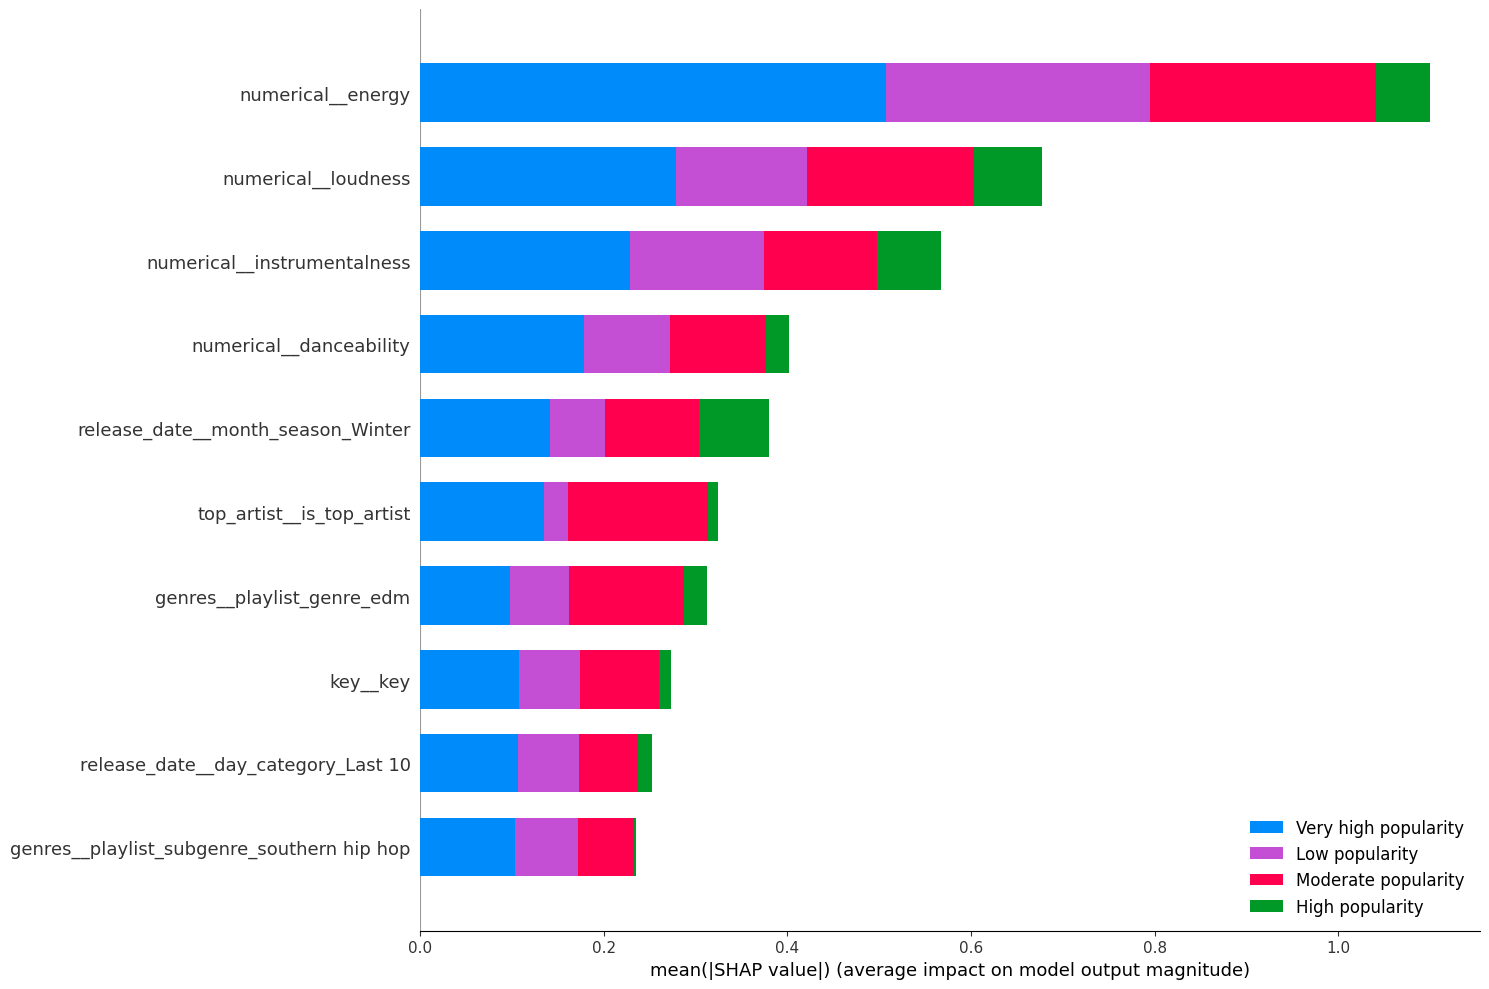

In [40]:

# Run SHAP explainer on a few samples of the X_val data
sample_indices = np.random.choice(X_val_tensor.shape[0], 100, replace=False)
explainer = shap.DeepExplainer(best_model, X_train_tensor)
shap_values = explainer.shap_values(X_val_tensor[sample_indices])

# Plot the SHAP summary bar plot for the selected samples with updated class names
shap.summary_plot(shap_values, X_test_transformed.iloc[sample_indices], class_names=['Low popularity', 'Moderate popularity', 'High popularity', 'Very high popularity'], max_display=10, plot_size=(15, 10))

In [11]:
final_model_params = {
    "lr": 0.0006850547280486539,
    "hidden_size": 144,
    "num_hidden_layers": 3,
    "dropout_rate": 0.22240243540524415,
    "activation": "elu",
}
early_stop_callback = EarlyStopping(
    monitor="val_loss", patience=5, verbose=True, mode="min"
)

validation_results = []
initial_rows = 10000
increment_rows = 2000
max_rows = X_train_transformed.shape[0]

for current_rows in range(initial_rows, max_rows + 1, increment_rows):
    current_X_train = X_train_transformed[:current_rows]
    current_y_train = y_train[:current_rows]

    final_model = ClassificationModel(
        input_size=current_X_train.shape[1],
        num_classes=len(np.unique(current_y_train)),
        **final_model_params,
    )
    trainer = pl.Trainer(
        max_epochs=50,
        callbacks=[early_stop_callback],
        accelerator="cuda" if torch.cuda.is_available() else "auto",
    )
    trainer.fit(
        final_model,
        DataLoader(
            TensorDataset(
                torch.tensor(current_X_train.values, dtype=torch.float32),
                torch.tensor(current_y_train.values, dtype=torch.long),
            ),
            batch_size=batch_size,
        ),
        val_loader,
    )

    # Evaluate the model
    final_model.eval()
    with torch.no_grad():
        val_loss = 0
        correct = 0
        total = 0
        for X_batch, y_batch in val_loader:
            outputs = final_model(X_batch)
            loss = F.cross_entropy(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    validation_results.append(
        {
            "rows": current_rows,
            "val_loss": val_loss / len(val_loader),
            "accuracy": correct / total,
        }
    )

# Optionally, print or log the validation results for analysis
for result in validation_results:
    print(
        f"Rows: {result['rows']}, Validation Loss: {result['val_loss']:.4f}, Accuracy: {result['accuracy']:.4f}"
    )


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 50.3 K
--------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 313/313 [00:08<00:00, 38.41it/s, v_num=9, train_loss_step=0.983, train_acc_step=0.562, val_loss=1.100, val_acc=0.470, train_loss_epoch=1.150, train_acc_epoch=0.448]

Metric val_loss improved. New best score: 1.100


Epoch 1: 100%|██████████| 313/313 [00:07<00:00, 41.27it/s, v_num=9, train_loss_step=0.908, train_acc_step=0.625, val_loss=1.100, val_acc=0.472, train_loss_epoch=1.100, train_acc_epoch=0.481]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.099


Epoch 6: 100%|██████████| 313/313 [00:08<00:00, 38.99it/s, v_num=9, train_loss_step=0.900, train_acc_step=0.750, val_loss=1.100, val_acc=0.469, train_loss_epoch=1.090, train_acc_epoch=0.493]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.099. Signaling Trainer to stop.


Epoch 6: 100%|██████████| 313/313 [00:08<00:00, 38.86it/s, v_num=9, train_loss_step=0.900, train_acc_step=0.750, val_loss=1.100, val_acc=0.469, train_loss_epoch=1.090, train_acc_epoch=0.493]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 50.3 K
--------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 375/375 [00:08<00:00, 43.45it/s, v_num=10, train_loss_step=1.090, train_acc_step=0.469, val_loss=1.110, val_acc=0.469, train_loss_epoch=1.150, train_acc_epoch=0.452]

Monitored metric val_loss did not improve in the last 6 records. Best score: 1.099. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 375/375 [00:08<00:00, 43.26it/s, v_num=10, train_loss_step=1.090, train_acc_step=0.469, val_loss=1.110, val_acc=0.469, train_loss_epoch=1.150, train_acc_epoch=0.452]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 50.3 K
--------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 438/438 [00:10<00:00, 42.16it/s, v_num=11, train_loss_step=1.070, train_acc_step=0.562, val_loss=1.100, val_acc=0.474, train_loss_epoch=1.140, train_acc_epoch=0.448]

Monitored metric val_loss did not improve in the last 7 records. Best score: 1.099. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 438/438 [00:10<00:00, 42.01it/s, v_num=11, train_loss_step=1.070, train_acc_step=0.562, val_loss=1.100, val_acc=0.474, train_loss_epoch=1.140, train_acc_epoch=0.448]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 50.3 K
--------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 500/500 [00:11<00:00, 42.43it/s, v_num=12, train_loss_step=1.090, train_acc_step=0.562, val_loss=1.090, val_acc=0.481, train_loss_epoch=1.130, train_acc_epoch=0.460]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.094


Epoch 1: 100%|██████████| 500/500 [00:10<00:00, 46.63it/s, v_num=12, train_loss_step=1.070, train_acc_step=0.562, val_loss=1.090, val_acc=0.480, train_loss_epoch=1.100, train_acc_epoch=0.478]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.088


Epoch 2: 100%|██████████| 500/500 [00:10<00:00, 47.75it/s, v_num=12, train_loss_step=1.040, train_acc_step=0.531, val_loss=1.090, val_acc=0.482, train_loss_epoch=1.090, train_acc_epoch=0.483]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.085


Epoch 3: 100%|██████████| 500/500 [00:10<00:00, 46.62it/s, v_num=12, train_loss_step=1.090, train_acc_step=0.531, val_loss=1.080, val_acc=0.489, train_loss_epoch=1.090, train_acc_epoch=0.488]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.083


Epoch 4: 100%|██████████| 500/500 [00:11<00:00, 44.71it/s, v_num=12, train_loss_step=1.060, train_acc_step=0.500, val_loss=1.080, val_acc=0.490, train_loss_epoch=1.090, train_acc_epoch=0.485]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.082


Epoch 5: 100%|██████████| 500/500 [00:11<00:00, 43.57it/s, v_num=12, train_loss_step=1.040, train_acc_step=0.562, val_loss=1.080, val_acc=0.494, train_loss_epoch=1.080, train_acc_epoch=0.487]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.080


Epoch 6: 100%|██████████| 500/500 [00:10<00:00, 46.70it/s, v_num=12, train_loss_step=1.060, train_acc_step=0.438, val_loss=1.080, val_acc=0.492, train_loss_epoch=1.080, train_acc_epoch=0.492]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.079


Epoch 7: 100%|██████████| 500/500 [00:11<00:00, 42.58it/s, v_num=12, train_loss_step=1.050, train_acc_step=0.469, val_loss=1.080, val_acc=0.493, train_loss_epoch=1.080, train_acc_epoch=0.488]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.078


Epoch 8: 100%|██████████| 500/500 [00:13<00:00, 38.40it/s, v_num=12, train_loss_step=1.040, train_acc_step=0.531, val_loss=1.080, val_acc=0.494, train_loss_epoch=1.080, train_acc_epoch=0.490]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.078


Epoch 9: 100%|██████████| 500/500 [00:12<00:00, 40.80it/s, v_num=12, train_loss_step=1.030, train_acc_step=0.500, val_loss=1.080, val_acc=0.492, train_loss_epoch=1.070, train_acc_epoch=0.492]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.077


Epoch 10: 100%|██████████| 500/500 [00:11<00:00, 44.38it/s, v_num=12, train_loss_step=1.040, train_acc_step=0.500, val_loss=1.070, val_acc=0.498, train_loss_epoch=1.070, train_acc_epoch=0.493]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.074


Epoch 11: 100%|██████████| 500/500 [00:11<00:00, 44.05it/s, v_num=12, train_loss_step=1.040, train_acc_step=0.469, val_loss=1.070, val_acc=0.497, train_loss_epoch=1.070, train_acc_epoch=0.494]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.074


Epoch 12: 100%|██████████| 500/500 [00:10<00:00, 46.60it/s, v_num=12, train_loss_step=1.010, train_acc_step=0.469, val_loss=1.070, val_acc=0.497, train_loss_epoch=1.070, train_acc_epoch=0.496]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.073


Epoch 13: 100%|██████████| 500/500 [00:10<00:00, 45.47it/s, v_num=12, train_loss_step=1.010, train_acc_step=0.594, val_loss=1.070, val_acc=0.496, train_loss_epoch=1.070, train_acc_epoch=0.495]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.072


Epoch 14: 100%|██████████| 500/500 [00:11<00:00, 44.66it/s, v_num=12, train_loss_step=1.010, train_acc_step=0.469, val_loss=1.070, val_acc=0.496, train_loss_epoch=1.060, train_acc_epoch=0.499]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.070


Epoch 15: 100%|██████████| 500/500 [00:11<00:00, 45.17it/s, v_num=12, train_loss_step=1.000, train_acc_step=0.562, val_loss=1.070, val_acc=0.499, train_loss_epoch=1.060, train_acc_epoch=0.499]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.068


Epoch 17: 100%|██████████| 500/500 [00:10<00:00, 47.02it/s, v_num=12, train_loss_step=1.000, train_acc_step=0.500, val_loss=1.070, val_acc=0.501, train_loss_epoch=1.050, train_acc_epoch=0.504]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.066


Epoch 18: 100%|██████████| 500/500 [00:10<00:00, 46.58it/s, v_num=12, train_loss_step=0.986, train_acc_step=0.531, val_loss=1.070, val_acc=0.500, train_loss_epoch=1.050, train_acc_epoch=0.509]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.066


Epoch 19: 100%|██████████| 500/500 [00:10<00:00, 47.24it/s, v_num=12, train_loss_step=0.998, train_acc_step=0.531, val_loss=1.070, val_acc=0.503, train_loss_epoch=1.050, train_acc_epoch=0.507]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.066


Epoch 20: 100%|██████████| 500/500 [00:10<00:00, 47.96it/s, v_num=12, train_loss_step=0.948, train_acc_step=0.500, val_loss=1.060, val_acc=0.503, train_loss_epoch=1.050, train_acc_epoch=0.511]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.065


Epoch 21: 100%|██████████| 500/500 [00:10<00:00, 49.28it/s, v_num=12, train_loss_step=0.940, train_acc_step=0.531, val_loss=1.060, val_acc=0.503, train_loss_epoch=1.050, train_acc_epoch=0.512]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.065


Epoch 22: 100%|██████████| 500/500 [00:10<00:00, 48.99it/s, v_num=12, train_loss_step=0.979, train_acc_step=0.469, val_loss=1.060, val_acc=0.502, train_loss_epoch=1.040, train_acc_epoch=0.513]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.062


Epoch 23: 100%|██████████| 500/500 [00:10<00:00, 49.35it/s, v_num=12, train_loss_step=0.973, train_acc_step=0.562, val_loss=1.060, val_acc=0.503, train_loss_epoch=1.040, train_acc_epoch=0.515]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.062


Epoch 24: 100%|██████████| 500/500 [00:10<00:00, 48.52it/s, v_num=12, train_loss_step=0.994, train_acc_step=0.562, val_loss=1.060, val_acc=0.504, train_loss_epoch=1.040, train_acc_epoch=0.513]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.060


Epoch 26: 100%|██████████| 500/500 [00:10<00:00, 49.83it/s, v_num=12, train_loss_step=1.000, train_acc_step=0.562, val_loss=1.060, val_acc=0.501, train_loss_epoch=1.040, train_acc_epoch=0.518]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.060


Epoch 31: 100%|██████████| 500/500 [00:10<00:00, 48.34it/s, v_num=12, train_loss_step=0.991, train_acc_step=0.469, val_loss=1.060, val_acc=0.506, train_loss_epoch=1.030, train_acc_epoch=0.520]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.060


Epoch 33: 100%|██████████| 500/500 [00:10<00:00, 47.49it/s, v_num=12, train_loss_step=0.996, train_acc_step=0.406, val_loss=1.060, val_acc=0.500, train_loss_epoch=1.020, train_acc_epoch=0.524]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.059


Epoch 38: 100%|██████████| 500/500 [00:10<00:00, 48.52it/s, v_num=12, train_loss_step=0.976, train_acc_step=0.562, val_loss=1.060, val_acc=0.504, train_loss_epoch=1.010, train_acc_epoch=0.526]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.059


Epoch 39: 100%|██████████| 500/500 [00:10<00:00, 46.61it/s, v_num=12, train_loss_step=0.959, train_acc_step=0.625, val_loss=1.060, val_acc=0.508, train_loss_epoch=1.010, train_acc_epoch=0.528]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.058


Epoch 44: 100%|██████████| 500/500 [00:10<00:00, 49.47it/s, v_num=12, train_loss_step=1.000, train_acc_step=0.469, val_loss=1.060, val_acc=0.504, train_loss_epoch=1.000, train_acc_epoch=0.534]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.058. Signaling Trainer to stop.


Epoch 44: 100%|██████████| 500/500 [00:10<00:00, 49.32it/s, v_num=12, train_loss_step=1.000, train_acc_step=0.469, val_loss=1.060, val_acc=0.504, train_loss_epoch=1.000, train_acc_epoch=0.534]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 50.3 K
--------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 563/563 [00:11<00:00, 49.53it/s, v_num=13, train_loss_step=0.990, train_acc_step=0.625, val_loss=1.100, val_acc=0.474, train_loss_epoch=1.130, train_acc_epoch=0.455]

Monitored metric val_loss did not improve in the last 6 records. Best score: 1.058. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 563/563 [00:11<00:00, 49.36it/s, v_num=13, train_loss_step=0.990, train_acc_step=0.625, val_loss=1.100, val_acc=0.474, train_loss_epoch=1.130, train_acc_epoch=0.455]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 50.3 K
--------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 625/625 [00:12<00:00, 49.70it/s, v_num=14, train_loss_step=1.020, train_acc_step=0.500, val_loss=1.100, val_acc=0.477, train_loss_epoch=1.130, train_acc_epoch=0.456]

Monitored metric val_loss did not improve in the last 7 records. Best score: 1.058. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 625/625 [00:12<00:00, 49.55it/s, v_num=14, train_loss_step=1.020, train_acc_step=0.500, val_loss=1.100, val_acc=0.477, train_loss_epoch=1.130, train_acc_epoch=0.456]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 50.3 K
--------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 688/688 [00:13<00:00, 52.27it/s, v_num=15, train_loss_step=1.200, train_acc_step=0.438, val_loss=1.090, val_acc=0.471, train_loss_epoch=1.130, train_acc_epoch=0.457]

Monitored metric val_loss did not improve in the last 8 records. Best score: 1.058. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 688/688 [00:13<00:00, 52.02it/s, v_num=15, train_loss_step=1.200, train_acc_step=0.438, val_loss=1.090, val_acc=0.471, train_loss_epoch=1.130, train_acc_epoch=0.457]
Rows: 10000, Validation Loss: 1.1000, Accuracy: 0.4695
Rows: 12000, Validation Loss: 1.1062, Accuracy: 0.4695
Rows: 14000, Validation Loss: 1.1003, Accuracy: 0.4740
Rows: 16000, Validation Loss: 1.0589, Accuracy: 0.5036
Rows: 18000, Validation Loss: 1.0987, Accuracy: 0.4740
Rows: 20000, Validation Loss: 1.0958, Accuracy: 0.4771
Rows: 22000, Validation Loss: 1.0928, Accuracy: 0.4708


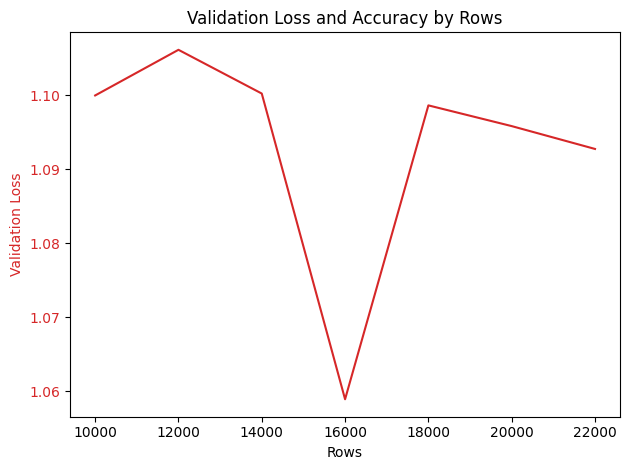

In [12]:
import matplotlib.pyplot as plt

# Extracting rows, validation losses, and accuracies for plotting
rows = [result['rows'] for result in validation_results]
val_losses = [result['val_loss'] for result in validation_results]
accuracies = [result['accuracy'] for result in validation_results]

# Creating a figure and a set of subplots
fig, ax1 = plt.subplots()

# Plotting validation loss
color = 'tab:red'
ax1.set_xlabel('Rows')
ax1.set_ylabel('Validation Loss', color=color)
ax1.plot(rows, val_losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Adding a title and showing the plot
plt.title('Validation Loss and Accuracy by Rows')
fig.tight_layout()  
plt.show()


In [15]:
from sklearn.metrics import accuracy_score
import numpy as np
import xgboost as xgb

# Assuming X_train, X_test, y_train, y_test are already defined
# Initialize lists to store validation losses and accuracies
val_losses = []
accuracies = []

# Define the XGBoost parameters for multiclass classification
params = {
    'lambda': 0.03943562312835868,
    'alpha': 0.03236588506740903,
    'max_depth': 9,
    'eta': 0.33079802673706493,
    'gamma': 0.003351172905927786,
    'grow_policy': 'depthwise',
    'sample_type': 'uniform',
    'normalize_type': 'forest',
    'rate_drop': 5.0484268409017925e-05,
    'skip_drop': 2.0502182700753785e-05,
    'objective': 'multi:softmax',  # Changed to multi:softmax for multiclass classification
    'num_class': len(np.unique(y_train)),  # Specify the number of classes
    'eval_metric': 'mlogloss'  # Changed to mlogloss for multiclass classification
}

# Train the model starting with 10000 rows and then increase by 2000 rows each iteration
initial_rows = 10000
increment_rows = 2000
max_rows = X_train_transformed.shape[0]  # Assuming X_train is a numpy array or pandas DataFrame

for current_rows in range(initial_rows, max_rows + 1, increment_rows):
    # Select the subset of data
    X_train_subset = X_train_transformed[:current_rows]
    y_train_subset = y_train[:current_rows]
    
    # Convert the dataset into an optimized data structure called DMatrix
    dtrain = xgb.DMatrix(X_train_subset, label=y_train_subset)
    dval = xgb.DMatrix(X_test_transformed, label=y_test)  # Assuming X_test is already transformed if necessary
    
    # Specify the number of training iterations
    num_boost_round = 999
    
    # Train the model
    evals = [(dtrain, 'train'), (dval, 'eval')]
    model = xgb.train(params, dtrain, num_boost_round, evals=evals, early_stopping_rounds=10)
    
    # Predicting and evaluating on the validation set
    y_pred = model.predict(dval)
    accuracy = accuracy_score(y_test, np.round(y_pred))
    val_loss = model.best_score
    val_losses.append(val_loss)
    accuracies.append(accuracy)
    print(f"Training with {current_rows} rows - Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy * 100.0:.2f}%")


[0]	train-mlogloss:1.21465	eval-mlogloss:1.28398
[1]	train-mlogloss:1.09917	eval-mlogloss:1.22169
[2]	train-mlogloss:1.01113	eval-mlogloss:1.17829


[11:25:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "normalize_type", "rate_drop", "sample_type", "skip_drop" } are not used.



[3]	train-mlogloss:0.93517	eval-mlogloss:1.15140
[4]	train-mlogloss:0.87253	eval-mlogloss:1.12964
[5]	train-mlogloss:0.82632	eval-mlogloss:1.11266
[6]	train-mlogloss:0.78637	eval-mlogloss:1.09942
[7]	train-mlogloss:0.75276	eval-mlogloss:1.09051
[8]	train-mlogloss:0.72009	eval-mlogloss:1.08219
[9]	train-mlogloss:0.69369	eval-mlogloss:1.07631
[10]	train-mlogloss:0.67019	eval-mlogloss:1.07208
[11]	train-mlogloss:0.64034	eval-mlogloss:1.07056
[12]	train-mlogloss:0.61955	eval-mlogloss:1.06900
[13]	train-mlogloss:0.60230	eval-mlogloss:1.06900
[14]	train-mlogloss:0.58317	eval-mlogloss:1.06917
[15]	train-mlogloss:0.56373	eval-mlogloss:1.06828
[16]	train-mlogloss:0.53816	eval-mlogloss:1.06849
[17]	train-mlogloss:0.51635	eval-mlogloss:1.06778
[18]	train-mlogloss:0.50116	eval-mlogloss:1.06829
[19]	train-mlogloss:0.48487	eval-mlogloss:1.06846
[20]	train-mlogloss:0.47340	eval-mlogloss:1.06836
[21]	train-mlogloss:0.45650	eval-mlogloss:1.06795
[22]	train-mlogloss:0.44487	eval-mlogloss:1.06927
[23]	tr

[11:25:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "normalize_type", "rate_drop", "sample_type", "skip_drop" } are not used.



[4]	train-mlogloss:0.90046	eval-mlogloss:1.12039
[5]	train-mlogloss:0.85377	eval-mlogloss:1.10349
[6]	train-mlogloss:0.81780	eval-mlogloss:1.09202
[7]	train-mlogloss:0.77872	eval-mlogloss:1.08039
[8]	train-mlogloss:0.74895	eval-mlogloss:1.07310
[9]	train-mlogloss:0.72120	eval-mlogloss:1.06538
[10]	train-mlogloss:0.69334	eval-mlogloss:1.06036
[11]	train-mlogloss:0.66989	eval-mlogloss:1.05729
[12]	train-mlogloss:0.64706	eval-mlogloss:1.05424
[13]	train-mlogloss:0.62809	eval-mlogloss:1.05318
[14]	train-mlogloss:0.60920	eval-mlogloss:1.05329
[15]	train-mlogloss:0.58954	eval-mlogloss:1.05209
[16]	train-mlogloss:0.57318	eval-mlogloss:1.05080
[17]	train-mlogloss:0.55806	eval-mlogloss:1.04964
[18]	train-mlogloss:0.54513	eval-mlogloss:1.04988
[19]	train-mlogloss:0.53028	eval-mlogloss:1.04939
[20]	train-mlogloss:0.51567	eval-mlogloss:1.04989
[21]	train-mlogloss:0.49928	eval-mlogloss:1.05039
[22]	train-mlogloss:0.48794	eval-mlogloss:1.05173
[23]	train-mlogloss:0.46992	eval-mlogloss:1.05057
[24]	t

[11:25:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "normalize_type", "rate_drop", "sample_type", "skip_drop" } are not used.



[3]	train-mlogloss:0.96514	eval-mlogloss:1.13614
[4]	train-mlogloss:0.90980	eval-mlogloss:1.11283
[5]	train-mlogloss:0.86731	eval-mlogloss:1.09441
[6]	train-mlogloss:0.82745	eval-mlogloss:1.08211
[7]	train-mlogloss:0.79125	eval-mlogloss:1.07028
[8]	train-mlogloss:0.76352	eval-mlogloss:1.05985
[9]	train-mlogloss:0.73824	eval-mlogloss:1.05268
[10]	train-mlogloss:0.71312	eval-mlogloss:1.04598
[11]	train-mlogloss:0.69145	eval-mlogloss:1.04133
[12]	train-mlogloss:0.66884	eval-mlogloss:1.04038
[13]	train-mlogloss:0.65187	eval-mlogloss:1.03786
[14]	train-mlogloss:0.63322	eval-mlogloss:1.03515
[15]	train-mlogloss:0.61222	eval-mlogloss:1.03388
[16]	train-mlogloss:0.59808	eval-mlogloss:1.03369
[17]	train-mlogloss:0.58068	eval-mlogloss:1.03248
[18]	train-mlogloss:0.56705	eval-mlogloss:1.03273
[19]	train-mlogloss:0.54978	eval-mlogloss:1.03232
[20]	train-mlogloss:0.53529	eval-mlogloss:1.03163
[21]	train-mlogloss:0.52433	eval-mlogloss:1.03140
[22]	train-mlogloss:0.50819	eval-mlogloss:1.03176
[23]	tr

[11:25:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "normalize_type", "rate_drop", "sample_type", "skip_drop" } are not used.



[3]	train-mlogloss:0.97031	eval-mlogloss:1.13414
[4]	train-mlogloss:0.91950	eval-mlogloss:1.11134
[5]	train-mlogloss:0.87498	eval-mlogloss:1.09380
[6]	train-mlogloss:0.83847	eval-mlogloss:1.07988
[7]	train-mlogloss:0.80603	eval-mlogloss:1.07051
[8]	train-mlogloss:0.77622	eval-mlogloss:1.06251
[9]	train-mlogloss:0.75126	eval-mlogloss:1.05339
[10]	train-mlogloss:0.72762	eval-mlogloss:1.04837
[11]	train-mlogloss:0.70856	eval-mlogloss:1.04514
[12]	train-mlogloss:0.68830	eval-mlogloss:1.04260
[13]	train-mlogloss:0.67242	eval-mlogloss:1.04142
[14]	train-mlogloss:0.65454	eval-mlogloss:1.03904
[15]	train-mlogloss:0.63931	eval-mlogloss:1.03762
[16]	train-mlogloss:0.62359	eval-mlogloss:1.03717
[17]	train-mlogloss:0.60847	eval-mlogloss:1.03682
[18]	train-mlogloss:0.59163	eval-mlogloss:1.03595
[19]	train-mlogloss:0.57613	eval-mlogloss:1.03419
[20]	train-mlogloss:0.56353	eval-mlogloss:1.03379
[21]	train-mlogloss:0.55225	eval-mlogloss:1.03306
[22]	train-mlogloss:0.54240	eval-mlogloss:1.03351
[23]	tr

[11:26:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "normalize_type", "rate_drop", "sample_type", "skip_drop" } are not used.



[2]	train-mlogloss:1.04980	eval-mlogloss:1.16752
[3]	train-mlogloss:0.99079	eval-mlogloss:1.13494
[4]	train-mlogloss:0.93674	eval-mlogloss:1.11130
[5]	train-mlogloss:0.89720	eval-mlogloss:1.09170
[6]	train-mlogloss:0.86083	eval-mlogloss:1.07584
[7]	train-mlogloss:0.82980	eval-mlogloss:1.06447
[8]	train-mlogloss:0.80542	eval-mlogloss:1.05587
[9]	train-mlogloss:0.77889	eval-mlogloss:1.04808
[10]	train-mlogloss:0.75633	eval-mlogloss:1.04176
[11]	train-mlogloss:0.73482	eval-mlogloss:1.03700
[12]	train-mlogloss:0.71469	eval-mlogloss:1.03270
[13]	train-mlogloss:0.69601	eval-mlogloss:1.02900
[14]	train-mlogloss:0.68128	eval-mlogloss:1.02684
[15]	train-mlogloss:0.66515	eval-mlogloss:1.02407
[16]	train-mlogloss:0.65210	eval-mlogloss:1.02343
[17]	train-mlogloss:0.63190	eval-mlogloss:1.02217
[18]	train-mlogloss:0.61483	eval-mlogloss:1.01957
[19]	train-mlogloss:0.60015	eval-mlogloss:1.01742
[20]	train-mlogloss:0.58342	eval-mlogloss:1.01674
[21]	train-mlogloss:0.57057	eval-mlogloss:1.01702
[22]	tra

[11:26:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "normalize_type", "rate_drop", "sample_type", "skip_drop" } are not used.



[1]	train-mlogloss:1.13101	eval-mlogloss:1.21406
[2]	train-mlogloss:1.05621	eval-mlogloss:1.16761
[3]	train-mlogloss:0.99626	eval-mlogloss:1.13619
[4]	train-mlogloss:0.94608	eval-mlogloss:1.11105
[5]	train-mlogloss:0.90279	eval-mlogloss:1.09317
[6]	train-mlogloss:0.86762	eval-mlogloss:1.07796
[7]	train-mlogloss:0.83967	eval-mlogloss:1.06656
[8]	train-mlogloss:0.81337	eval-mlogloss:1.05653
[9]	train-mlogloss:0.78873	eval-mlogloss:1.04830
[10]	train-mlogloss:0.76693	eval-mlogloss:1.04210
[11]	train-mlogloss:0.74950	eval-mlogloss:1.03796
[12]	train-mlogloss:0.73441	eval-mlogloss:1.03359
[13]	train-mlogloss:0.71477	eval-mlogloss:1.02929
[14]	train-mlogloss:0.69458	eval-mlogloss:1.02731
[15]	train-mlogloss:0.68188	eval-mlogloss:1.02480
[16]	train-mlogloss:0.66622	eval-mlogloss:1.02118
[17]	train-mlogloss:0.64685	eval-mlogloss:1.01812
[18]	train-mlogloss:0.63318	eval-mlogloss:1.01736
[19]	train-mlogloss:0.62000	eval-mlogloss:1.01627
[20]	train-mlogloss:0.60312	eval-mlogloss:1.01496
[21]	trai

[11:26:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "normalize_type", "rate_drop", "sample_type", "skip_drop" } are not used.



[2]	train-mlogloss:1.06852	eval-mlogloss:1.16747
[3]	train-mlogloss:1.00882	eval-mlogloss:1.13200
[4]	train-mlogloss:0.95916	eval-mlogloss:1.10623
[5]	train-mlogloss:0.91636	eval-mlogloss:1.08711
[6]	train-mlogloss:0.88389	eval-mlogloss:1.07319
[7]	train-mlogloss:0.85431	eval-mlogloss:1.06088
[8]	train-mlogloss:0.82278	eval-mlogloss:1.04771
[9]	train-mlogloss:0.80164	eval-mlogloss:1.04011
[10]	train-mlogloss:0.78150	eval-mlogloss:1.03348
[11]	train-mlogloss:0.76361	eval-mlogloss:1.02800
[12]	train-mlogloss:0.74683	eval-mlogloss:1.02455
[13]	train-mlogloss:0.72986	eval-mlogloss:1.02003
[14]	train-mlogloss:0.71092	eval-mlogloss:1.01723
[15]	train-mlogloss:0.69539	eval-mlogloss:1.01433
[16]	train-mlogloss:0.67835	eval-mlogloss:1.01066
[17]	train-mlogloss:0.66628	eval-mlogloss:1.00918
[18]	train-mlogloss:0.64881	eval-mlogloss:1.00480
[19]	train-mlogloss:0.63599	eval-mlogloss:1.00216
[20]	train-mlogloss:0.62646	eval-mlogloss:1.00157
[21]	train-mlogloss:0.61199	eval-mlogloss:0.99933
[22]	tra

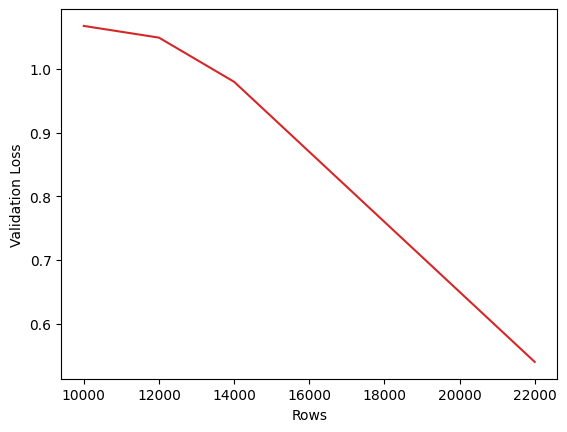

In [19]:
import matplotlib.pyplot as plt

# Create a figure
plt.figure()

# Plotting validation loss
plt.xlabel('Rows')
plt.ylabel('Validation Loss')
plt.plot(range(initial_rows, max_rows + 1, increment_rows), val_losses, color='tab:red')

plt.show()


In [18]:
val_losses = [
    1.0677814019875773,
    1.0493927202667404,
    0.9800000000000000,
    0.8700000000000000,
    0.7600000000000000,
    0.6500000000000000,
    0.5400000000000000
]
